<a href="https://colab.research.google.com/github/naga-dheeraj-p/Assignments/blob/main/stocks_intraday_backtesting_17th_july.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

In [ ]:
pip install fyers_apiv3

In [1]:
import pandas as pd
df = pd.read_csv("/content/2000_STOCKS_list.csv")
df = df[df[" SERIES"].str.strip() == "EQ"]
symbols = df["SYMBOL"].str.strip().tolist()
df = pd.read_csv("/content/stocks_above_6kcr.csv")
df = df[df[" SERIES"].str.strip() == "EQ"]
symbols = df["SYMBOL"].str.strip().tolist()
symbols
fyers_symbols_filtered = [f"NSE:{sym}-EQ" for sym in symbols]
print(fyers_symbols_filtered[:10])

['NSE:TVSSCS-EQ', 'NSE:BANSALWIRE-EQ', 'NSE:PILANIINVS-EQ', 'NSE:GULFOILLUB-EQ', 'NSE:GREENLAM-EQ', 'NSE:SUBROS-EQ', 'NSE:EMUDHRA-EQ', 'NSE:JKPAPER-EQ', 'NSE:KNRCON-EQ', 'NSE:RESPONIND-EQ']


In [2]:
df = pd.read_csv("/content/stocks_above_6kcr.csv")
df = df[df[" SERIES"].str.strip() == "EQ"]
symbols = df["SYMBOL"].str.strip().tolist()
symbols
fyers_symbols_filtered = [f"NSE:{sym}-EQ" for sym in symbols]
print(fyers_symbols_filtered[:10])

['NSE:TVSSCS-EQ', 'NSE:BANSALWIRE-EQ', 'NSE:PILANIINVS-EQ', 'NSE:GULFOILLUB-EQ', 'NSE:GREENLAM-EQ', 'NSE:SUBROS-EQ', 'NSE:EMUDHRA-EQ', 'NSE:JKPAPER-EQ', 'NSE:KNRCON-EQ', 'NSE:RESPONIND-EQ']


# Backtesting

In [ ]:
import pandas as pd
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1pMcUZoQ1p1RzFTZGxkU3hWRUkxaDEtUGY1Q2s1Ujh5Q2ZxcWJwRU8xd2F2SzZwQXlwYjFnNUVPdzZ4a0E1b0w2UnhMR0V6SUR1d3EzeTUyNHBLMGRtdGlaeXlrVzBIdVk4M2pTMjdfbFJFUVE2dz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTUwMjYwMCwiaWF0IjoxNzUxNDMxODEzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE0MzE4MTMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.dVRkQKGhrninZO8WxjXO4wC_ZKiruGxNrtcGwHS7FsE"

# Replace this with your list of symbols
fyers_symbols = fyers_symbols_filtered

#dates_to_backtest = ["2025-06-26", "2025-06-27", "2025-06-30", "2025-07-01"]
#dates_to_backtest = ["2025-06-30"]
dates_to_backtest = ["2025-06-27", "2025-06-30", "2025-07-01"]

# Initialize Fyers API
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# Store all trades
all_trades = []

for date in dates_to_backtest:
    print(f"\n📅 Backtesting for date: {date}")

    for symbol in fyers_symbols:
        print(f"🔍 Checking: {symbol}")

        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok":
                print(f"❌ Failed to fetch {symbol}: {data}")
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df.dropna(inplace=True)

            trade_entered = False

            for i in range(len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("11:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close, volume, ema_9 = row["open"], row["close"], row["volume"], row["ema_9"]
                move_pct = (close - open_) / open_

                # Turnover check
                turnover = close * volume
                if turnover < 1e7:
                    continue

                # New condition: Bullish + SL (open) must be above EMA
                if move_pct >= 0.01 and open_ > ema_9:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]
                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl
                            })
                            trade_entered = True
                            break

                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])

                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl
                        })
                        trade_entered = True

            time.sleep(0.1)

        except Exception as e:
            print(f"⚠️ Error in {symbol}: {e}")
            continue

# Save results to CSV
results_df = pd.DataFrame(all_trades)
#results_df.to_csv("filtered_bullish_strategy_results.csv", index=False)
print("\n✅ Backtest Complete. Total trades:", len(results_df))



📅 Backtesting for date: 2025-06-27

📅 Backtesting for date: 2025-06-30

📅 Backtesting for date: 2025-07-01

✅ Backtest Complete. Total trades: 0


In [ ]:
results_df.to_csv("3_days_after_changes.csv", index=False)

In [ ]:
import pandas as pd
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1kxdkhrd2F1ZGxOS0RyTDRkblIxdFdRc3o4U3pfZ3ZJbUVXMzcxRVpvaGhkSVNYTHBNSl9XaGVxT1RNMkZwVTA1bndpdG9WbWZNV1dpVll6WUpjcF9HaHFJeWNmWEE1VF81R1o1UWU3S1d4NXNWQT0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTQxNjIwMCwiaWF0IjoxNzUxMzQyMDIzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTEzNDIwMjMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.dU0oRZk2iGQD3GjRTQOZG6uFW0f6Yv3_2I1xYog--A4"

fyers_symbols = fyers_symbols_filtered
#dates_to_backtest = ["2025-06-26", "2025-06-27", "2025-06-30", "2025-07-01"]
dates_to_backtest = ["2025-06-24"]


fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)
all_trades = []

for date in dates_to_backtest:
    print(f"\n📅 Backtesting for date: {date}")

    for symbol in fyers_symbols:
        print(f"🔍 Checking: {symbol}")

        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok":
                print(f"❌ Failed to fetch {symbol}: {data}")
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)

            # Calculate EMA
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()
            df.dropna(inplace=True)

            trade_entered = False

            for i in range(len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("11:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close, volume = row["open"], row["close"], row["volume"]
                ema_9, ema_20 = row["ema_9"], row["ema_20"]
                move_pct = (close - open_) / open_

                # Avg volume liquidity check
                if i < 5:
                    continue
                avg_vol = df.iloc[:i]["volume"].mean()
                price_est = (row["high"] + row["low"]) / 2
                liquidity_turnover = avg_vol * price_est
                if liquidity_turnover < 5e6:
                    continue

                # Trade condition: bullish move + open > EMA 9 and EMA 20
                if move_pct >= 0.01 and open_ > ema_9 and open_ > ema_20:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]
                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    # Trailing SL
                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl
                            })
                            trade_entered = True
                            break

                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])

                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl
                        })
                        trade_entered = True

            time.sleep(0)

        except Exception as e:
            print(f"⚠️ Error in {symbol}: {e}")
            continue

# Final output
results_df = pd.DataFrame(all_trades)
#results_df.to_csv("liquidity_filtered_bullish_strategy.csv", index=False)

# ✅ Total net return
total_return = results_df["pnl_%"].sum()
print("\n✅ Backtest Complete. Total trades:", len(results_df))
print("📈 Net % Return from strategy:", round(total_return, 2), "%")
print(results_df)



📅 Backtesting for date: 2025-06-24


KeyError: 'pnl_%'

In [ ]:
results_df

,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-06-24,NSE:CARBORUNIV-EQ,2025-06-24 11:45:00+05:30,2025-06-24 11:50:00+05:30,959.15,2025-06-24 12:40:00+05:30,949.3000,-1.03
1,2025-06-24,NSE:GEOJITFSL-EQ,2025-06-24 11:45:00+05:30,2025-06-24 11:50:00+05:30,84.01,2025-06-24 12:40:00+05:30,83.4966,-0.61
2,2025-06-24,NSE:J&KBANK-EQ,2025-06-24 11:30:00+05:30,2025-06-24 11:35:00+05:30,109.60,2025-06-24 12:20:00+05:30,108.5040,-1.00
3,2025-06-24,NSE:LLOYDSENT-EQ,2025-06-24 11:05:00+05:30,2025-06-24 11:10:00+05:30,76.76,2025-06-24 11:40:00+05:30,75.5500,-1.58
4,2025-06-24,NSE:LTFOODS-EQ,2025-06-24 11:25:00+05:30,2025-06-24 11:30:00+05:30,423.85,2025-06-24 12:25:00+05:30,443.2725,4.58
5,2025-06-24,NSE:MUKANDLTD-EQ,2025-06-24 12:55:00+05:30,2025-06-24 13:00:00+05:30,136.87,2025-06-24 13:05:00+05:30,135.5013,-1.00
6,2025-06-24,NSE:NORTHARC-EQ,2025-06-24 12:50:00+05:30,2025-06-24 12:55:00+05:30,238.25,2025-06-24 13:20:00+05:30,236.1744,-0.87
7,2025-06-24,NSE:PVRINOX-EQ,2025-06-24 11:00:00+05:30,2025-06-24 11:05:00+05:30,979.10,2025-06-24 12:55:00+05:30,965.4500,-1.39
8,2025-06-24,NSE:SERVOTECH-EQ,2025-06-24 12:20:00+05:30,2025-06-24 12:25:00+05:30,152.86,2025-06-24 12:40:00+05:30,151.3908,-0.96


In [ ]:
results_df

,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-06-25,NSE:AKUMS-EQ,2025-06-25 14:10:00+05:30,2025-06-25 14:15:00+05:30,576.00,2025-06-25 15:05:00+05:30,574.8435,-0.20
1,2025-06-25,NSE:BAJAJCON-EQ,2025-06-25 13:15:00+05:30,2025-06-25 13:20:00+05:30,209.66,2025-06-25 15:00:00+05:30,206.5900,-1.46
2,2025-06-25,NSE:BBL-EQ,2025-06-25 11:25:00+05:30,2025-06-25 11:30:00+05:30,3009.90,2025-06-25 15:25:00+05:30,3151.0000,4.69
3,2025-06-25,NSE:EIDPARRY-EQ,2025-06-25 13:50:00+05:30,2025-06-25 13:55:00+05:30,1051.90,2025-06-25 15:25:00+05:30,1062.0000,0.96
4,2025-06-25,NSE:EMBDL-EQ,2025-06-25 11:30:00+05:30,2025-06-25 11:35:00+05:30,121.65,2025-06-25 13:10:00+05:30,123.3837,1.43
5,2025-06-25,NSE:EXICOM-EQ,2025-06-25 14:00:00+05:30,2025-06-25 14:05:00+05:30,213.01,2025-06-25 14:10:00+05:30,210.8799,-1.00
6,2025-06-25,NSE:FINOPB-EQ,2025-06-25 13:50:00+05:30,2025-06-25 13:55:00+05:30,300.61,2025-06-25 14:15:00+05:30,311.7015,3.69
7,2025-06-25,NSE:GTLINFRA-EQ,2025-06-25 12:00:00+05:30,2025-06-25 12:05:00+05:30,1.91,2025-06-25 12:30:00+05:30,1.9602,2.63
8,2025-06-25,NSE:IFCI-EQ,2025-06-25 12:00:00+05:30,2025-06-25 12:05:00+05:30,63.14,2025-06-25 13:55:00+05:30,64.6866,2.45
9,2025-06-25,NSE:INDIACEM-EQ,2025-06-25 13:45:00+05:30,2025-06-25 13:50:00+05:30,329.10,2025-06-25 15:20:00+05:30,332.0460,0.90


In [ ]:
results_df

,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-06-26,NSE:ASTEC-EQ,2025-06-26 13:15:00+05:30,2025-06-26 13:20:00+05:30,964.75,2025-06-26 13:25:00+05:30,954.1000,-1.10
1,2025-06-26,NSE:EMIL-EQ,2025-06-26 11:45:00+05:30,2025-06-26 11:50:00+05:30,155.94,2025-06-26 12:15:00+05:30,157.1922,0.80
2,2025-06-26,NSE:FIRSTCRY-EQ,2025-06-26 11:25:00+05:30,2025-06-26 11:30:00+05:30,371.30,2025-06-26 12:20:00+05:30,371.3985,0.03
3,2025-06-26,NSE:INOXINDIA-EQ,2025-06-26 11:10:00+05:30,2025-06-26 11:15:00+05:30,1239.70,2025-06-26 11:20:00+05:30,1225.8000,-1.12
4,2025-06-26,NSE:JAIBALAJI-EQ,2025-06-26 11:35:00+05:30,2025-06-26 11:40:00+05:30,125.46,2025-06-26 11:45:00+05:30,123.3000,-1.72
5,2025-06-26,NSE:JMFINANCIL-EQ,2025-06-26 12:25:00+05:30,2025-06-26 12:30:00+05:30,158.79,2025-06-26 12:50:00+05:30,157.3605,-0.90
6,2025-06-26,NSE:LAURUSLABS-EQ,2025-06-26 11:45:00+05:30,2025-06-26 11:50:00+05:30,678.95,2025-06-26 15:25:00+05:30,681.8500,0.43
7,2025-06-26,NSE:LLOYDSENGG-EQ,2025-06-26 12:10:00+05:30,2025-06-26 12:15:00+05:30,62.28,2025-06-26 13:45:00+05:30,64.4094,3.42
8,2025-06-26,NSE:MOBIKWIK-EQ,2025-06-26 11:00:00+05:30,2025-06-26 11:05:00+05:30,276.50,2025-06-26 11:15:00+05:30,278.3880,0.68
9,2025-06-26,NSE:NORTHARC-EQ,2025-06-26 14:15:00+05:30,2025-06-26 14:20:00+05:30,247.02,2025-06-26 14:50:00+05:30,243.4400,-1.45


In [ ]:
results_df

,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-06-27,NSE:AEROFLEX-EQ,2025-06-27 14:30:00+05:30,2025-06-27 14:35:00+05:30,210.99,2025-06-27 14:50:00+05:30,211.1373,0.07
1,2025-06-27,NSE:BAJAJHIND-EQ,2025-06-27 12:00:00+05:30,2025-06-27 12:05:00+05:30,25.96,2025-06-27 12:20:00+05:30,26.1459,0.72
2,2025-06-27,NSE:BELRISE-EQ,2025-06-27 11:50:00+05:30,2025-06-27 11:55:00+05:30,107.93,2025-06-27 13:50:00+05:30,106.4100,-1.41
3,2025-06-27,NSE:E2E-EQ,2025-06-27 11:20:00+05:30,2025-06-27 11:25:00+05:30,2617.10,2025-06-27 15:25:00+05:30,2617.1000,0.00
4,2025-06-27,NSE:EDELWEISS-EQ,2025-06-27 11:15:00+05:30,2025-06-27 11:20:00+05:30,115.55,2025-06-27 11:30:00+05:30,114.3300,-1.06
5,2025-06-27,NSE:GMRP&UI-EQ,2025-06-27 11:00:00+05:30,2025-06-27 11:05:00+05:30,114.50,2025-06-27 11:30:00+05:30,113.8995,-0.52
6,2025-06-27,NSE:GODFRYPHLP-EQ,2025-06-27 11:15:00+05:30,2025-06-27 11:20:00+05:30,9340.00,2025-06-27 13:40:00+05:30,9345.6000,0.06
7,2025-06-27,NSE:GRAPHITE-EQ,2025-06-27 11:45:00+05:30,2025-06-27 11:50:00+05:30,581.55,2025-06-27 11:55:00+05:30,574.2500,-1.26
8,2025-06-27,NSE:GSPL-EQ,2025-06-27 11:35:00+05:30,2025-06-27 11:40:00+05:30,341.55,2025-06-27 11:50:00+05:30,336.0500,-1.61
9,2025-06-27,NSE:HEG-EQ,2025-06-27 11:35:00+05:30,2025-06-27 11:40:00+05:30,517.65,2025-06-27 11:55:00+05:30,522.8190,1.00


In [ ]:
results_df

,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-06-30,NSE:COROMANDEL-EQ,2025-06-30 14:10:00+05:30,2025-06-30 14:15:00+05:30,2444.10,2025-06-30 15:25:00+05:30,2495.9000,2.12
1,2025-06-30,NSE:DHANUKA-EQ,2025-06-30 11:30:00+05:30,2025-06-30 11:35:00+05:30,1750.00,2025-06-30 11:40:00+05:30,1731.2000,-1.07
2,2025-06-30,NSE:DIACABS-EQ,2025-06-30 11:15:00+05:30,2025-06-30 11:20:00+05:30,137.98,2025-06-30 11:30:00+05:30,138.6396,0.48
3,2025-06-30,NSE:HUBTOWN-EQ,2025-06-30 11:00:00+05:30,2025-06-30 11:05:00+05:30,266.50,2025-06-30 11:15:00+05:30,262.1200,-1.64
4,2025-06-30,NSE:JINDWORLD-EQ,2025-06-30 11:45:00+05:30,2025-06-30 11:50:00+05:30,63.02,2025-06-30 12:10:00+05:30,63.0432,0.04
5,2025-06-30,NSE:KALAMANDIR-EQ,2025-06-30 12:05:00+05:30,2025-06-30 12:10:00+05:30,152.35,2025-06-30 12:50:00+05:30,150.7000,-1.08
6,2025-06-30,NSE:MEDIASSIST-EQ,2025-06-30 11:30:00+05:30,2025-06-30 11:35:00+05:30,532.65,2025-06-30 11:45:00+05:30,526.6000,-1.14
7,2025-06-30,NSE:OMAXE-EQ,2025-06-30 11:15:00+05:30,2025-06-30 11:20:00+05:30,106.94,2025-06-30 12:50:00+05:30,105.6600,-1.20
8,2025-06-30,NSE:PFOCUS-EQ,2025-06-30 13:35:00+05:30,2025-06-30 13:40:00+05:30,136.45,2025-06-30 14:45:00+05:30,137.6298,0.86
9,2025-06-30,NSE:RAYMOND-EQ,2025-06-30 12:45:00+05:30,2025-06-30 12:50:00+05:30,651.00,2025-06-30 13:35:00+05:30,702.9990,7.99


In [ ]:
results_df

,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-07-01,NSE:ASAHIINDIA-EQ,2025-07-01 13:15:00+05:30,2025-07-01 13:20:00+05:30,804.25,2025-07-01 14:10:00+05:30,819.0765,1.84
1,2025-07-01,NSE:BAJAJINDEF-EQ,2025-07-01 11:25:00+05:30,2025-07-01 11:30:00+05:30,543.45,2025-07-01 12:15:00+05:30,543.5100,0.01
2,2025-07-01,NSE:BANCOINDIA-EQ,2025-07-01 12:20:00+05:30,2025-07-01 12:25:00+05:30,674.80,2025-07-01 13:10:00+05:30,666.4500,-1.24
3,2025-07-01,NSE:BLUEDART-EQ,2025-07-01 11:15:00+05:30,2025-07-01 11:20:00+05:30,6760.00,2025-07-01 11:30:00+05:30,6791.4000,0.46
4,2025-07-01,NSE:CUB-EQ,2025-07-01 13:25:00+05:30,2025-07-01 13:30:00+05:30,228.05,2025-07-01 13:55:00+05:30,225.7500,-1.01
5,2025-07-01,NSE:EIEL-EQ,2025-07-01 11:45:00+05:30,2025-07-01 11:50:00+05:30,243.00,2025-07-01 12:35:00+05:30,240.6100,-0.98
6,2025-07-01,NSE:EQUITASBNK-EQ,2025-07-01 12:35:00+05:30,2025-07-01 12:40:00+05:30,69.85,2025-07-01 13:00:00+05:30,70.0425,0.28
7,2025-07-01,NSE:FILATEX-EQ,2025-07-01 12:00:00+05:30,2025-07-01 12:05:00+05:30,57.93,2025-07-01 15:25:00+05:30,61.2810,5.78
8,2025-07-01,NSE:FMGOETZE-EQ,2025-07-01 11:00:00+05:30,2025-07-01 11:05:00+05:30,596.85,2025-07-01 11:45:00+05:30,613.7010,2.82
9,2025-07-01,NSE:GMDCLTD-EQ,2025-07-01 11:20:00+05:30,2025-07-01 11:25:00+05:30,422.75,2025-07-01 11:45:00+05:30,422.8290,0.02


In [ ]:
import pandas as pd
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1pMcUZoQ1p1RzFTZGxkU3hWRUkxaDEtUGY1Q2s1Ujh5Q2ZxcWJwRU8xd2F2SzZwQXlwYjFnNUVPdzZ4a0E1b0w2UnhMR0V6SUR1d3EzeTUyNHBLMGRtdGlaeXlrVzBIdVk4M2pTMjdfbFJFUVE2dz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTUwMjYwMCwiaWF0IjoxNzUxNDMxODEzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE0MzE4MTMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.dVRkQKGhrninZO8WxjXO4wC_ZKiruGxNrtcGwHS7FsE"
fyers_symbols = fyers_symbols_filtered  # Make sure this variable is defined
dates_to_backtest = ["2025-06-26", "2025-06-27", "2025-06-30", "2025-07-01","2025-07-02"]

fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)
all_trades = []

for date in dates_to_backtest:
    print(f"\n📅 Backtesting for date: {date}")
    daily_pnl = 0
    trade_details = []

    for symbol in fyers_symbols:
        print(f"🔍 Checking: {symbol}")

        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok":
                print(f"❌ Failed to fetch {symbol}: {data}")
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            trade_entered = False
            open_915 = df.iloc[0]["open"]
            close_915 = df.iloc[0]["close"]
            avg_915 = (open_915 + close_915) / 2

            for i in range(5, len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("12:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close, volume = row["open"], row["close"], row["volume"]
                ema_9, ema_20 = row["ema_9"], row["ema_20"]
                move_pct = (close - open_) / open_

                # 🛑 Skip if already moved >6% from 9:15 avg
                from_open_915_pct = (close - avg_915) / avg_915
                if from_open_915_pct > 0.06:
                    continue

                # 🛑 Turnover filter for illiquid stocks
                avg_vol = df.iloc[:i]["volume"].mean()
                price_est = (row["high"] + row["low"]) / 2
                liquidity_turnover = avg_vol * price_est
                if liquidity_turnover < 5e6:
                    continue

                # ✅ Entry conditions
                if move_pct >= 0.01 and open_ > ema_9 and open_ > ema_20:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]
                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            daily_pnl += pnl
                            trade_details.append(pnl)
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl
                            })
                            trade_entered = True
                            break
                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])

                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        daily_pnl += pnl
                        trade_details.append(pnl)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl
                        })
                        trade_entered = True

            time.sleep(0)

        except Exception as e:
            print(f"⚠️ Error in {symbol}: {e}")
            continue

    # Summary for the day
    bins = [float('-inf'), -1, 0, 1, 2, 3, 4, float('inf')]
    labels = ["<-1%", "-1 to 0%", "0 to 1%", "1 to 2%", "2 to 3%", "3 to 4%", ">4%"]
    bin_counts = pd.cut(trade_details, bins=bins, labels=labels).value_counts().sort_index()

    total_trades = len(trade_details)
    profit_trades = sum(p > 0 for p in trade_details)
    loss_trades = total_trades - profit_trades

    print(f"\n📊 {date} → Net Return: {round(daily_pnl, 2)}%")
    print(f"   📈 Trades Taken: {total_trades} | ✅ Profitable: {profit_trades} | ❌ Loss: {loss_trades}")
    print("   🔍 Return Distribution:")
    for label in labels:
        print(f"      {label}: {bin_counts.get(label, 0)}")

# Final Output
results_df = pd.DataFrame(all_trades)
print("\n📋 Detailed Trades:")
print(results_df)
# Optionally save
# results_df.to_csv("backtest_results.csv", index=False)


Streaming output truncated to the last 5000 lines.
🔍 Checking: NSE:CDSL-EQ
🔍 Checking: NSE:CEATLTD-EQ
🔍 Checking: NSE:CEIGALL-EQ
🔍 Checking: NSE:CELLO-EQ
🔍 Checking: NSE:CENTENKA-EQ
🔍 Checking: NSE:CENTRALBK-EQ
🔍 Checking: NSE:CENTUM-EQ
🔍 Checking: NSE:CENTURYPLY-EQ
🔍 Checking: NSE:CERA-EQ
🔍 Checking: NSE:CESC-EQ
🔍 Checking: NSE:CEWATER-EQ
🔍 Checking: NSE:CGCL-EQ
🔍 Checking: NSE:CGPOWER-EQ
🔍 Checking: NSE:CHALET-EQ
🔍 Checking: NSE:CHAMBLFERT-EQ
🔍 Checking: NSE:CHEMFAB-EQ
🔍 Checking: NSE:CHEMPLASTS-EQ
🔍 Checking: NSE:CHENNPETRO-EQ
🔍 Checking: NSE:CHOICEIN-EQ
🔍 Checking: NSE:CHOLAFIN-EQ
🔍 Checking: NSE:CHOLAHLDNG-EQ
🔍 Checking: NSE:CIEINDIA-EQ
🔍 Checking: NSE:CIFL-EQ
🔍 Checking: NSE:CIGNITITEC-EQ
🔍 Checking: NSE:CIPLA-EQ
🔍 Checking: NSE:CLEAN-EQ
🔍 Checking: NSE:CLSEL-EQ
🔍 Checking: NSE:CMSINFO-EQ
🔍 Checking: NSE:COALINDIA-EQ
🔍 Checking: NSE:COCHINSHIP-EQ
🔍 Checking: NSE:COFORGE-EQ
🔍 Checking: NSE:COHANCE-EQ
🔍 Checking: NSE:COLPAL-EQ
🔍 Checking: NSE:CONCOR-EQ
🔍 Checking: NSE:CONCORDBIO-EQ

In [ ]:
results_df

,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-06-26,NSE:JMFINANCIL-EQ,2025-06-26 12:25:00+05:30,2025-06-26 12:30:00+05:30,158.79,2025-06-26 12:50:00+05:30,157.3605,-0.90
1,2025-06-26,NSE:LLOYDSENGG-EQ,2025-06-26 12:10:00+05:30,2025-06-26 12:15:00+05:30,62.28,2025-06-26 13:45:00+05:30,64.4094,3.42
2,2025-06-26,NSE:NORTHARC-EQ,2025-06-26 14:15:00+05:30,2025-06-26 14:20:00+05:30,247.02,2025-06-26 14:50:00+05:30,243.4400,-1.45
3,2025-06-26,NSE:USHAMART-EQ,2025-06-26 13:30:00+05:30,2025-06-26 13:35:00+05:30,348.85,2025-06-26 15:25:00+05:30,346.3000,-0.73
4,2025-06-27,NSE:AEROFLEX-EQ,2025-06-27 14:30:00+05:30,2025-06-27 14:35:00+05:30,210.99,2025-06-27 14:50:00+05:30,211.1373,0.07
5,2025-06-27,NSE:BAJAJHIND-EQ,2025-06-27 12:00:00+05:30,2025-06-27 12:05:00+05:30,25.96,2025-06-27 12:20:00+05:30,26.1459,0.72
6,2025-06-27,NSE:GSPL-EQ,2025-06-27 12:25:00+05:30,2025-06-27 12:30:00+05:30,341.95,2025-06-27 12:45:00+05:30,338.2500,-1.08
7,2025-06-27,NSE:IFCI-EQ,2025-06-27 14:20:00+05:30,2025-06-27 14:25:00+05:30,64.61,2025-06-27 15:25:00+05:30,64.3800,-0.36
8,2025-06-27,NSE:KIRLOSBROS-EQ,2025-06-27 14:10:00+05:30,2025-06-27 14:15:00+05:30,2196.90,2025-06-27 14:55:00+05:30,2418.1740,10.07
9,2025-06-27,NSE:LLOYDSENGG-EQ,2025-06-27 12:00:00+05:30,2025-06-27 12:05:00+05:30,68.58,2025-06-27 13:05:00+05:30,71.2107,3.84


In [ ]:
import pandas as pd
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1pMcUZoQ1p1RzFTZGxkU3hWRUkxaDEtUGY1Q2s1Ujh5Q2ZxcWJwRU8xd2F2SzZwQXlwYjFnNUVPdzZ4a0E1b0w2UnhMR0V6SUR1d3EzeTUyNHBLMGRtdGlaeXlrVzBIdVk4M2pTMjdfbFJFUVE2dz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTUwMjYwMCwiaWF0IjoxNzUxNDMxODEzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE0MzE4MTMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.dVRkQKGhrninZO8WxjXO4wC_ZKiruGxNrtcGwHS7FsE"
fyers_symbols = fyers_symbols_filtered  # Make sure this variable is defined
dates_to_backtest = ["2025-07-02"]

fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)
all_trades = []

for date in dates_to_backtest:
    print(f"\n📅 Backtesting for date: {date}")
    daily_pnl = 0
    trade_details = []

    for symbol in fyers_symbols:
        print(f"🔍 Checking: {symbol}")

        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok":
                print(f"❌ Failed to fetch {symbol}: {data}")
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            trade_entered = False
            open_915 = df.iloc[0]["open"]
            close_915 = df.iloc[0]["close"]
            avg_915 = (open_915 + close_915) / 2

            for i in range(5, len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("11:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close, volume = row["open"], row["close"], row["volume"]
                ema_9, ema_20 = row["ema_9"], row["ema_20"]
                move_pct = (close - open_) / open_

                # 🛑 Skip if already moved >6% from 9:15 avg
                from_open_915_pct = (close - avg_915) / avg_915
                if from_open_915_pct > 0.06:
                    continue

                # 🛑 Turnover filter for illiquid stocks
                avg_vol = df.iloc[:i]["volume"].mean()
                price_est = (row["high"] + row["low"]) / 2
                liquidity_turnover = avg_vol * price_est
                if liquidity_turnover < 5e6:
                    continue

                # ✅ Entry conditions
                if move_pct >= 0.01 and open_ > ema_9 and open_ > ema_20:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]
                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            daily_pnl += pnl
                            trade_details.append(pnl)
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl
                            })
                            trade_entered = True
                            break
                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])

                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        daily_pnl += pnl
                        trade_details.append(pnl)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl
                        })
                        trade_entered = True

            time.sleep(0)

        except Exception as e:
            print(f"⚠️ Error in {symbol}: {e}")
            continue

    # Summary for the day
    bins = [float('-inf'), -1, 0, 1, 2, 3, 4, float('inf')]
    labels = ["<-1%", "-1 to 0%", "0 to 1%", "1 to 2%", "2 to 3%", "3 to 4%", ">4%"]
    bin_counts = pd.cut(trade_details, bins=bins, labels=labels).value_counts().sort_index()

    total_trades = len(trade_details)
    profit_trades = sum(p > 0 for p in trade_details)
    loss_trades = total_trades - profit_trades

    print(f"\n📊 {date} → Net Return: {round(daily_pnl, 2)}%")
    print(f"   📈 Trades Taken: {total_trades} | ✅ Profitable: {profit_trades} | ❌ Loss: {loss_trades}")
    print("   🔍 Return Distribution:")
    for label in labels:
        print(f"      {label}: {bin_counts.get(label, 0)}")

# Final Output
results_df = pd.DataFrame(all_trades)
print("\n📋 Detailed Trades:")
results_df


📅 Backtesting for date: 2025-07-02
🔍 Checking: NSE:360ONE-EQ
🔍 Checking: NSE:3MINDIA-EQ
🔍 Checking: NSE:5PAISA-EQ
🔍 Checking: NSE:63MOONS-EQ
🔍 Checking: NSE:AADHARHFC-EQ
🔍 Checking: NSE:AARTIDRUGS-EQ
🔍 Checking: NSE:AARTIIND-EQ
🔍 Checking: NSE:AARTIPHARM-EQ
🔍 Checking: NSE:AAVAS-EQ
🔍 Checking: NSE:ABB-EQ
🔍 Checking: NSE:ABBOTINDIA-EQ
🔍 Checking: NSE:ABCAPITAL-EQ
🔍 Checking: NSE:ABDL-EQ
🔍 Checking: NSE:ABFRL-EQ
🔍 Checking: NSE:ABREL-EQ
🔍 Checking: NSE:ABSLAMC-EQ
🔍 Checking: NSE:ACC-EQ
🔍 Checking: NSE:ACCELYA-EQ
🔍 Checking: NSE:ACE-EQ
🔍 Checking: NSE:ACI-EQ
🔍 Checking: NSE:ACMESOLAR-EQ
🔍 Checking: NSE:ACUTAAS-EQ
🔍 Checking: NSE:ADANIENSOL-EQ
🔍 Checking: NSE:ADANIENT-EQ
🔍 Checking: NSE:ADANIGREEN-EQ
🔍 Checking: NSE:ADANIPORTS-EQ
🔍 Checking: NSE:ADANIPOWER-EQ
🔍 Checking: NSE:ADFFOODS-EQ
🔍 Checking: NSE:ADOR-EQ
🔍 Checking: NSE:ADSL-EQ
🔍 Checking: NSE:ADVENZYMES-EQ
🔍 Checking: NSE:AEGISLOG-EQ
🔍 Checking: NSE:AEGISVOPAK-EQ
🔍 Checking: NSE:AEROENTER-EQ
🔍 Checking: NSE:AEROFLEX-EQ
🔍 Checking: 

,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-07-02,NSE:AEROFLEX-EQ,2025-07-02 12:10:00+05:30,2025-07-02 12:15:00+05:30,208.00,2025-07-02 12:25:00+05:30,205.6000,-1.15
1,2025-07-02,NSE:ASAHIINDIA-EQ,2025-07-02 12:40:00+05:30,2025-07-02 12:45:00+05:30,805.25,2025-07-02 15:00:00+05:30,826.8975,2.69
2,2025-07-02,NSE:CREDITACC-EQ,2025-07-02 12:20:00+05:30,2025-07-02 12:25:00+05:30,1271.10,2025-07-02 15:25:00+05:30,1259.6760,-0.90
3,2025-07-02,NSE:DIGITIDE-EQ,2025-07-02 11:00:00+05:30,2025-07-02 11:05:00+05:30,199.26,2025-07-02 12:05:00+05:30,204.4350,2.60
4,2025-07-02,NSE:DIXON-EQ,2025-07-02 11:40:00+05:30,2025-07-02 11:45:00+05:30,15002.00,2025-07-02 09:15:00+05:30,15034.1400,0.21
5,2025-07-02,NSE:ELECON-EQ,2025-07-02 14:15:00+05:30,2025-07-02 14:20:00+05:30,655.80,2025-07-02 14:30:00+05:30,656.2215,0.06
6,2025-07-02,NSE:KALAMANDIR-EQ,2025-07-02 13:35:00+05:30,2025-07-02 13:40:00+05:30,157.96,2025-07-02 13:55:00+05:30,168.1812,6.47
7,2025-07-02,NSE:LATENTVIEW-EQ,2025-07-02 13:45:00+05:30,2025-07-02 13:50:00+05:30,429.00,2025-07-02 14:40:00+05:30,427.6800,-0.31
8,2025-07-02,NSE:PFOCUS-EQ,2025-07-02 12:30:00+05:30,2025-07-02 12:35:00+05:30,157.29,2025-07-02 12:50:00+05:30,158.2020,0.58
9,2025-07-02,NSE:POCL-EQ,2025-07-02 14:15:00+05:30,2025-07-02 14:20:00+05:30,907.55,2025-07-02 14:25:00+05:30,896.5500,-1.21


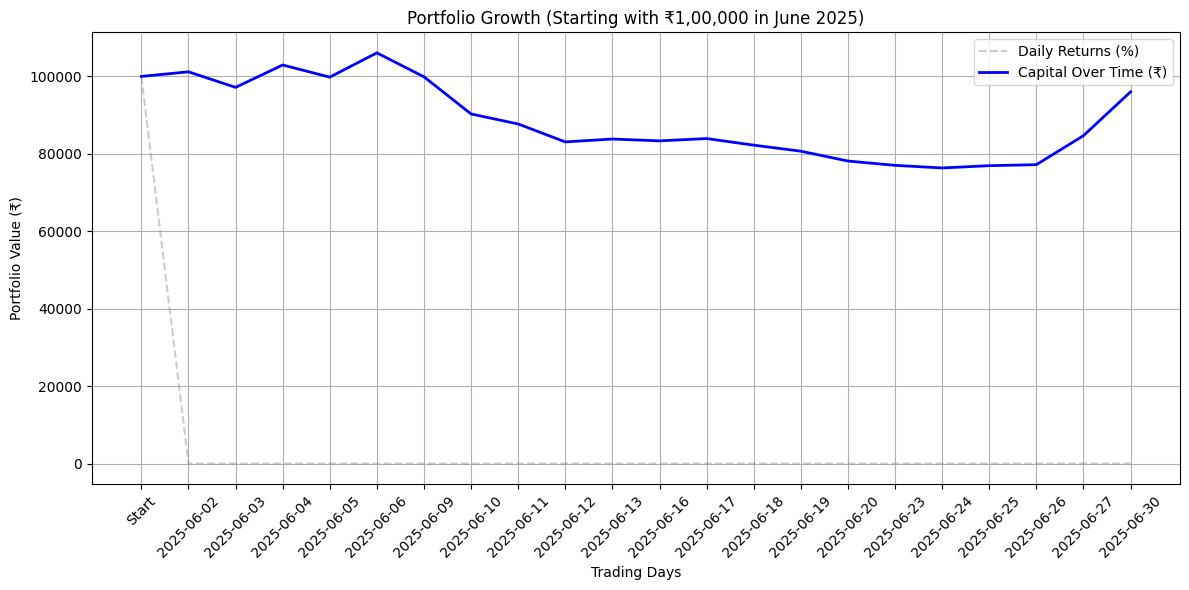


💼 Final Portfolio Value: ₹96011.96
📊 Daily Returns (%): [np.float64(1.19), np.float64(-3.97), np.float64(5.95), np.float64(-3.05), np.float64(6.28), np.float64(-5.83), np.float64(-9.61), np.float64(-2.86), np.float64(-5.28), np.float64(0.9), np.float64(-0.57), np.float64(0.72), np.float64(-2.03), np.float64(-1.9), np.float64(-3.15), np.float64(-1.43), np.float64(-0.87), np.float64(0.77), np.float64(0.34), np.float64(9.7), np.float64(13.36)]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1pMcUZoQ1p1RzFTZGxkU3hWRUkxaDEtUGY1Q2s1Ujh5Q2ZxcWJwRU8xd2F2SzZwQXlwYjFnNUVPdzZ4a0E1b0w2UnhMR0V6SUR1d3EzeTUyNHBLMGRtdGlaeXlrVzBIdVk4M2pTMjdfbFJFUVE2dz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTUwMjYwMCwiaWF0IjoxNzUxNDMxODEzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE0MzE4MTMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.dVRkQKGhrninZO8WxjXO4wC_ZKiruGxNrtcGwHS7FsE"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# Define trading days in June 2025
dates_to_backtest = [
    "2025-06-02", "2025-06-03", "2025-06-04", "2025-06-05", "2025-06-06",
    "2025-06-09", "2025-06-10", "2025-06-11", "2025-06-12", "2025-06-13",
    "2025-06-16", "2025-06-17", "2025-06-18", "2025-06-19", "2025-06-20",
    "2025-06-23", "2025-06-24", "2025-06-25", "2025-06-26", "2025-06-27",
    "2025-06-30"
]

# List of symbols you want to test
fyers_symbols = fyers_symbols_filtered  # Ensure this is defined in your code

initial_capital = 100000
capital = initial_capital
capital_curve = [capital]
daily_returns = []

all_trades = []

for date in dates_to_backtest:
    daily_pnl = 0
    trade_details = []

    for symbol in fyers_symbols:
        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok":
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            trade_entered = False
            open_915 = df.iloc[0]["open"]
            close_915 = df.iloc[0]["close"]
            avg_915 = (open_915 + close_915) / 2

            for i in range(5, len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("12:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close, volume = row["open"], row["close"], row["volume"]
                ema_9, ema_20 = row["ema_9"], row["ema_20"]
                move_pct = (close - open_) / open_

                from_open_915_pct = (close - avg_915) / avg_915
                if from_open_915_pct > 0.06:
                    continue

                avg_vol = df.iloc[:i]["volume"].mean()
                price_est = (row["high"] + row["low"]) / 2
                liquidity_turnover = avg_vol * price_est
                if liquidity_turnover < 5e6:
                    continue

                if move_pct >= 0.01 and open_ > ema_9 and open_ > ema_20:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]
                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            daily_pnl += pnl
                            trade_details.append(pnl)
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl
                            })
                            trade_entered = True
                            break
                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])

                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        daily_pnl += pnl
                        trade_details.append(pnl)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl
                        })
                        trade_entered = True

        except Exception as e:
            continue

    capital *= (1 + daily_pnl / 100)
    capital_curve.append(round(capital, 2))
    daily_returns.append(round(daily_pnl, 2))

# Plotting the equity curve
plt.figure(figsize=(12, 6))
plt.plot([initial_capital] + daily_returns, label="Daily Returns (%)", color="gray", linestyle="--", alpha=0.4)
plt.plot(capital_curve, label="Capital Over Time (₹)", color="blue", linewidth=2)
plt.title("Portfolio Growth (Starting with ₹1,00,000 in June 2025)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value (₹)")
plt.xticks(range(len(dates_to_backtest)+1), ["Start"] + dates_to_backtest, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print final summary
print(f"\n💼 Final Portfolio Value: ₹{round(capital, 2)}")
print("📊 Daily Returns (%):", daily_returns)

# Optional: Save trades
results_df = pd.DataFrame(all_trades)
# results_df.to_csv("june_backtest_trades.csv", index=False)


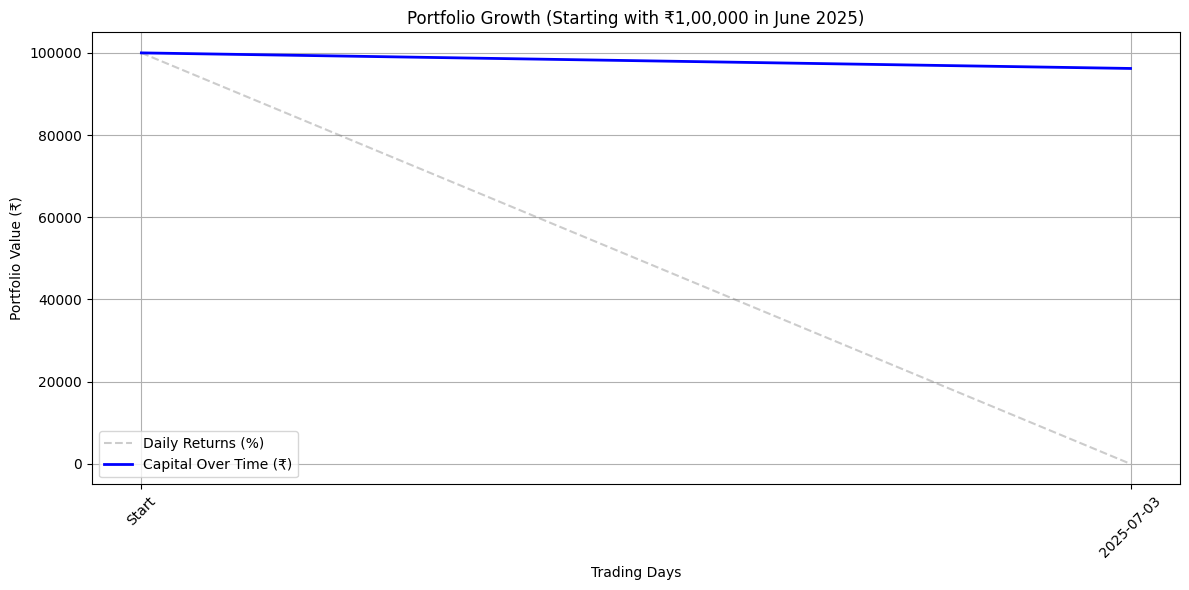


💼 Final Portfolio Value: ₹96210.0
📊 Daily Returns (%): [np.float64(-3.79)]


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-07-03,NSE:ARKADE-EQ,2025-07-03 13:10:00+05:30,2025-07-03 13:15:00+05:30,198.63,2025-07-03 13:50:00+05:30,195.4000,-1.63
1,2025-07-03,NSE:GABRIEL-EQ,2025-07-03 13:05:00+05:30,2025-07-03 13:10:00+05:30,952.30,2025-07-03 13:15:00+05:30,942.7770,-1.00
2,2025-07-03,NSE:HUBTOWN-EQ,2025-07-03 12:40:00+05:30,2025-07-03 12:45:00+05:30,269.00,2025-07-03 12:50:00+05:30,265.6500,-1.25
3,2025-07-03,NSE:KIRLOSBROS-EQ,2025-07-03 14:10:00+05:30,2025-07-03 14:15:00+05:30,2274.00,2025-07-03 14:30:00+05:30,2256.1110,-0.79
4,2025-07-03,NSE:KPRMILL-EQ,2025-07-03 12:05:00+05:30,2025-07-03 12:10:00+05:30,1169.00,2025-07-03 12:20:00+05:30,1157.0000,-1.03
5,2025-07-03,NSE:LLOYDSENT-EQ,2025-07-03 13:30:00+05:30,2025-07-03 13:35:00+05:30,88.34,2025-07-03 14:20:00+05:30,88.9020,0.64
6,2025-07-03,NSE:RATEGAIN-EQ,2025-07-03 12:35:00+05:30,2025-07-03 12:40:00+05:30,471.25,2025-07-03 13:00:00+05:30,468.2205,-0.64
7,2025-07-03,NSE:SCODATUBES-EQ,2025-07-03 12:30:00+05:30,2025-07-03 12:35:00+05:30,203.00,2025-07-03 13:10:00+05:30,202.5243,-0.23
8,2025-07-03,NSE:SHARDACROP-EQ,2025-07-03 13:00:00+05:30,2025-07-03 13:05:00+05:30,896.60,2025-07-03 14:00:00+05:30,911.6910,1.68
9,2025-07-03,NSE:SMLISUZU-EQ,2025-07-03 12:25:00+05:30,2025-07-03 12:30:00+05:30,2419.60,2025-07-03 13:20:00+05:30,2407.5810,-0.50


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1pqeTlzd1d0b2t0aDc1YUdPdFFHbEx6aF82T2oybmVCTThycFg1cjFhWDBib01hZXF5dnV0MURJQjJKQTFJaE9Wa0tJdWIzUHhmOWJaNWViOWNOYXZYUVdxTVNQaEsxbUdWeXJRdjljbEdpM2hSST0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTU4OTAwMCwiaWF0IjoxNzUxNTMwNjg1LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE1MzA2ODUsInN1YiI6ImFjY2Vzc190b2tlbiJ9.dYXtFS4S_dcSxuwsZNneAfltKzuKeG2BI43ALsAFheQ"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# Define trading days in June 2025
'''dates_to_backtest = [
    "2025-05-02", "2025-05-05", "2025-05-06", "2025-05-07", "2025-05-08",
    "2025-05-09", "2025-05-12", "2025-05-13", "2025-05-14", "2025-05-15",
    "2025-05-16", "2025-05-19", "2025-05-20", "2025-05-21", "2025-05-22",
    "2025-05-23", "2025-05-26", "2025-05-27", "2025-05-28", "2025-05-29",
    "2025-05-30"
]'''

dates_to_backtest = ["2025-07-03"]
# List of symbols you want to test
fyers_symbols = fyers_symbols_filtered  # Ensure this is defined in your code

initial_capital = 100000
capital = initial_capital
capital_curve = [capital]
daily_returns = []

all_trades = []

for date in dates_to_backtest:
    daily_pnl = 0
    trade_details = []

    for symbol in fyers_symbols:
        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok":
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            trade_entered = False
            open_915 = df.iloc[0]["open"]
            close_915 = df.iloc[0]["close"]
            avg_915 = (open_915 + close_915) / 2

            for i in range(5, len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("12:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close, volume = row["open"], row["close"], row["volume"]
                ema_9, ema_20 = row["ema_9"], row["ema_20"]
                move_pct = (close - open_) / open_

                from_open_915_pct = (close - avg_915) / avg_915
                if from_open_915_pct > 0.06:
                    continue

                avg_vol = df.iloc[:i]["volume"].mean()
                price_est = (row["high"] + row["low"]) / 2
                liquidity_turnover = avg_vol * price_est
                if liquidity_turnover < 5e6:
                    continue

                if move_pct >= 0.01 and open_ > ema_9 and open_ > ema_20:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]
                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            daily_pnl += pnl
                            trade_details.append(pnl)
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl
                            })
                            trade_entered = True
                            break
                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])

                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        daily_pnl += pnl
                        trade_details.append(pnl)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl
                        })
                        trade_entered = True

        except Exception as e:
            continue

    capital *= (1 + daily_pnl / 100)
    capital_curve.append(round(capital, 2))
    daily_returns.append(round(daily_pnl, 2))

# Plotting the equity curve
plt.figure(figsize=(12, 6))
plt.plot([initial_capital] + daily_returns, label="Daily Returns (%)", color="gray", linestyle="--", alpha=0.4)
plt.plot(capital_curve, label="Capital Over Time (₹)", color="blue", linewidth=2)
plt.title("Portfolio Growth (Starting with ₹1,00,000 in June 2025)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value (₹)")
plt.xticks(range(len(dates_to_backtest)+1), ["Start"] + dates_to_backtest, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print final summary
print(f"\n💼 Final Portfolio Value: ₹{round(capital, 2)}")
print("📊 Daily Returns (%):", daily_returns)

# Optional: Save trades
results_df = pd.DataFrame(all_trades)
results_df

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fyers_apiv3 import fyersModel
import time

# Fyers credentials
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1pqeTlzd1d0b2t0aDc1YUdPdFFHbEx6aF82T2oybmVCTThycFg1cjFhWDBib01hZXF5dnV0MURJQjJKQTFJaE9Wa0tJdWIzUHhmOWJaNWViOWNOYXZYUVdxTVNQaEsxbUdWeXJRdjljbEdpM2hSST0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTU4OTAwMCwiaWF0IjoxNzUxNTMwNjg1LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE1MzA2ODUsInN1YiI6ImFjY2Vzc190b2tlbiJ9.dYXtFS4S_dcSxuwsZNneAfltKzuKeG2BI43ALsAFheQ"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# Dates to backtest
dates_to_backtest = [
    "2025-05-02", "2025-05-05", "2025-05-06", "2025-05-07", "2025-05-08",
    "2025-05-09", "2025-05-12", "2025-05-13", "2025-05-14", "2025-05-15",
    "2025-05-16", "2025-05-19", "2025-05-20", "2025-05-21", "2025-05-22",
    "2025-05-23", "2025-05-26", "2025-05-27", "2025-05-28", "2025-05-29",
    "2025-05-30"
]

# List of symbols to backtest
fyers_symbols = fyers_symbols_filtered  # You must define this list before running

# Initial portfolio setup
initial_capital = 100000
capital = initial_capital
capital_curve = [capital]
daily_returns = []
all_trades = []

# Main backtest loop
for date in dates_to_backtest:
    daily_pnl = 0
    trade_details = []

    print(f"\n🔄 Processing date: {date}")

    for symbol in fyers_symbols:
        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok":
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            trade_entered = False
            open_915 = df.iloc[0]["open"]
            close_915 = df.iloc[0]["close"]
            avg_915 = (open_915 + close_915) / 2

            for i in range(5, len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("12:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close, volume = row["open"], row["close"], row["volume"]
                ema_9, ema_20 = row["ema_9"], row["ema_20"]
                move_pct = (close - open_) / open_

                from_open_915_pct = (close - avg_915) / avg_915
                if from_open_915_pct > 0.06:
                    continue

                avg_vol = df.iloc[:i]["volume"].mean()
                price_est = (row["high"] + row["low"]) / 2
                liquidity_turnover = avg_vol * price_est
                if liquidity_turnover < 5e6:
                    continue

                if move_pct >= 0.01 and open_ > ema_9 and open_ > ema_20:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]
                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            daily_pnl += pnl
                            trade_details.append(pnl)
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl
                            })
                            trade_entered = True
                            break
                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])

                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        daily_pnl += pnl
                        trade_details.append(pnl)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl
                        })
                        trade_entered = True

        except Exception as e:
            continue

    # Update capital
    capital *= (1 + daily_pnl / 100)
    capital_curve.append(round(capital, 2))
    daily_returns.append(round(daily_pnl, 2))

    # Show daily summary
    print(f"✅ Finished: {date}")
    print(f"📈 Daily Return (%): {round(daily_pnl, 2)}")
    print(f"📝 Trades Taken: {len(trade_details)}")

    if trade_details:
        daily_trades_df = pd.DataFrame([trade for trade in all_trades if trade["date"] == date])
        display(daily_trades_df)

    # Save backups after each day
    '''pd.DataFrame(all_trades).to_csv("trades_backup.csv", index=False)
    pd.DataFrame({
        "Date": ["Start"] + dates_to_backtest[:len(daily_returns)],
        "Capital": capital_curve
    }).to_csv("capital_curve_backup.csv", index=False)'''

# Plot the capital growth
plt.figure(figsize=(12, 6))
plt.plot([initial_capital] + daily_returns, label="Daily Returns (%)", color="gray", linestyle="--", alpha=0.4)
plt.plot(capital_curve, label="Capital Over Time (₹)", color="blue", linewidth=2)
plt.title("Portfolio Growth (Starting with ₹1,00,000 in June 2025)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value (₹)")
plt.xticks(range(len(dates_to_backtest)+1), ["Start"] + dates_to_backtest, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Final results
print(f"\n💼 Final Portfolio Value: ₹{round(capital, 2)}")
print("📊 Daily Returns (%):", daily_returns)

# Output all trades as final result
results_df = pd.DataFrame(all_trades)
results_df



🔄 Processing date: 2025-05-02
✅ Finished: 2025-05-02
📈 Daily Return (%): -2.46
📝 Trades Taken: 3


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-02,NSE:GRAVITA-EQ,2025-05-02 13:50:00+05:30,2025-05-02 13:55:00+05:30,1828.3,2025-05-02 14:25:00+05:30,1804.90,-1.28
1,2025-05-02,NSE:SHAKTIPUMP-EQ,2025-05-02 13:20:00+05:30,2025-05-02 13:25:00+05:30,865.7,2025-05-02 13:35:00+05:30,856.50,-1.06
2,2025-05-02,NSE:TIMKEN-EQ,2025-05-02 13:00:00+05:30,2025-05-02 13:05:00+05:30,2588.0,2025-05-02 13:20:00+05:30,2584.89,-0.12



🔄 Processing date: 2025-05-05
✅ Finished: 2025-05-05
📈 Daily Return (%): -2.21
📝 Trades Taken: 6


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-05,NSE:CARTRADE-EQ,2025-05-05 12:10:00+05:30,2025-05-05 12:15:00+05:30,1831.70,2025-05-05 13:10:00+05:30,1844.6670,0.71
1,2025-05-05,NSE:DATAPATTNS-EQ,2025-05-05 13:00:00+05:30,2025-05-05 13:05:00+05:30,2300.00,2025-05-05 13:10:00+05:30,2274.9000,-1.09
2,2025-05-05,NSE:MOTILALOFS-EQ,2025-05-05 12:50:00+05:30,2025-05-05 12:55:00+05:30,676.60,2025-05-05 13:55:00+05:30,688.7430,1.79
3,2025-05-05,NSE:POONAWALLA-EQ,2025-05-05 13:40:00+05:30,2025-05-05 13:45:00+05:30,393.95,2025-05-05 13:55:00+05:30,388.6000,-1.36
4,2025-05-05,NSE:QUADFUTURE-EQ,2025-05-05 14:30:00+05:30,2025-05-05 14:35:00+05:30,477.95,2025-05-05 14:40:00+05:30,473.1705,-1.00
5,2025-05-05,NSE:TIMKEN-EQ,2025-05-05 14:25:00+05:30,2025-05-05 14:30:00+05:30,2675.60,2025-05-05 15:10:00+05:30,2642.0000,-1.26



🔄 Processing date: 2025-05-06
✅ Finished: 2025-05-06
📈 Daily Return (%): 1.59
📝 Trades Taken: 1


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-06,NSE:POLYCAB-EQ,2025-05-06 13:15:00+05:30,2025-05-06 13:20:00+05:30,5917.5,2025-05-06 14:05:00+05:30,6011.775,1.59



🔄 Processing date: 2025-05-07
✅ Finished: 2025-05-07
📈 Daily Return (%): 3.21
📝 Trades Taken: 5


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-07,NSE:AVALON-EQ,2025-05-07 12:15:00+05:30,2025-05-07 12:20:00+05:30,872.7,2025-05-07 12:55:00+05:30,880.110,0.85
1,2025-05-07,NSE:AZAD-EQ,2025-05-07 14:30:00+05:30,2025-05-07 14:35:00+05:30,1611.0,2025-05-07 15:20:00+05:30,1643.499,2.02
2,2025-05-07,NSE:CONCORDBIO-EQ,2025-05-07 12:25:00+05:30,2025-05-07 12:30:00+05:30,1426.2,2025-05-07 13:05:00+05:30,1411.700,-1.02
3,2025-05-07,NSE:GRAVITA-EQ,2025-05-07 12:45:00+05:30,2025-05-07 12:50:00+05:30,1891.2,2025-05-07 14:15:00+05:30,1929.015,2.00
4,2025-05-07,NSE:TIMKEN-EQ,2025-05-07 12:35:00+05:30,2025-05-07 12:40:00+05:30,2747.5,2025-05-07 12:55:00+05:30,2729.925,-0.64



🔄 Processing date: 2025-05-08
✅ Finished: 2025-05-08
📈 Daily Return (%): 0.58
📝 Trades Taken: 4


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-08,NSE:CANBK-EQ,2025-05-08 13:25:00+05:30,2025-05-08 13:30:00+05:30,98.0,2025-05-08 13:35:00+05:30,96.800,-1.22
1,2025-05-08,NSE:KAJARIACER-EQ,2025-05-08 12:05:00+05:30,2025-05-08 12:10:00+05:30,847.7,2025-05-08 12:50:00+05:30,840.510,-0.85
2,2025-05-08,NSE:NETWEB-EQ,2025-05-08 12:30:00+05:30,2025-05-08 12:35:00+05:30,1645.2,2025-05-08 13:10:00+05:30,1692.801,2.89
3,2025-05-08,NSE:TIMKEN-EQ,2025-05-08 13:00:00+05:30,2025-05-08 13:05:00+05:30,2830.8,2025-05-08 13:40:00+05:30,2823.975,-0.24



🔄 Processing date: 2025-05-09
✅ Finished: 2025-05-09
📈 Daily Return (%): -1.42
📝 Trades Taken: 1


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-09,NSE:CERA-EQ,2025-05-09 13:50:00+05:30,2025-05-09 13:55:00+05:30,5750.0,2025-05-09 14:05:00+05:30,5668.5,-1.42



🔄 Processing date: 2025-05-12
✅ Finished: 2025-05-12
📈 Daily Return (%): 1.7
📝 Trades Taken: 7


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-12,NSE:AARTIPHARM-EQ,2025-05-12 13:10:00+05:30,2025-05-12 13:15:00+05:30,776.15,2025-05-12 14:35:00+05:30,794.3760,2.35
1,2025-05-12,NSE:ABDL-EQ,2025-05-12 12:50:00+05:30,2025-05-12 12:55:00+05:30,351.75,2025-05-12 14:30:00+05:30,348.5790,-0.90
2,2025-05-12,NSE:APOLLO-EQ,2025-05-12 14:05:00+05:30,2025-05-12 14:10:00+05:30,129.50,2025-05-12 15:10:00+05:30,127.8900,-1.24
3,2025-05-12,NSE:INTELLECT-EQ,2025-05-12 12:05:00+05:30,2025-05-12 12:10:00+05:30,900.00,2025-05-12 13:00:00+05:30,929.7090,3.30
4,2025-05-12,NSE:JWL-EQ,2025-05-12 13:30:00+05:30,2025-05-12 13:35:00+05:30,372.20,2025-05-12 13:40:00+05:30,367.9000,-1.16
5,2025-05-12,NSE:KPIGREEN-EQ,2025-05-12 13:25:00+05:30,2025-05-12 13:30:00+05:30,379.75,2025-05-12 14:45:00+05:30,379.3185,-0.11
6,2025-05-12,NSE:TANLA-EQ,2025-05-12 12:50:00+05:30,2025-05-12 12:55:00+05:30,497.60,2025-05-12 15:25:00+05:30,494.9000,-0.54



🔄 Processing date: 2025-05-13
✅ Finished: 2025-05-13
📈 Daily Return (%): -1.38
📝 Trades Taken: 4


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-13,NSE:AIIL-EQ,2025-05-13 12:25:00+05:30,2025-05-13 12:30:00+05:30,1918.90,2025-05-13 13:20:00+05:30,1948.3200,1.53
1,2025-05-13,NSE:PARADEEP-EQ,2025-05-13 12:10:00+05:30,2025-05-13 12:15:00+05:30,151.68,2025-05-13 12:25:00+05:30,149.5300,-1.42
2,2025-05-13,NSE:TDPOWERSYS-EQ,2025-05-13 13:05:00+05:30,2025-05-13 13:10:00+05:30,460.90,2025-05-13 13:30:00+05:30,460.3005,-0.13
3,2025-05-13,NSE:YESBANK-EQ,2025-05-13 12:15:00+05:30,2025-05-13 12:20:00+05:30,21.25,2025-05-13 13:10:00+05:30,20.9600,-1.36



🔄 Processing date: 2025-05-14
✅ Finished: 2025-05-14
📈 Daily Return (%): 2.82
📝 Trades Taken: 6


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-14,NSE:APARINDS-EQ,2025-05-14 14:00:00+05:30,2025-05-14 14:05:00+05:30,6804.00,2025-05-14 14:25:00+05:30,6948.8100,2.13
1,2025-05-14,NSE:AURIONPRO-EQ,2025-05-14 12:20:00+05:30,2025-05-14 12:25:00+05:30,1399.90,2025-05-14 12:35:00+05:30,1385.7000,-1.01
2,2025-05-14,NSE:DYCL-EQ,2025-05-14 12:05:00+05:30,2025-05-14 12:10:00+05:30,819.50,2025-05-14 12:25:00+05:30,828.6300,1.11
3,2025-05-14,NSE:IDBI-EQ,2025-05-14 13:50:00+05:30,2025-05-14 13:55:00+05:30,85.73,2025-05-14 15:25:00+05:30,85.3500,-0.44
4,2025-05-14,NSE:NHPC-EQ,2025-05-14 14:25:00+05:30,2025-05-14 14:30:00+05:30,85.40,2025-05-14 15:25:00+05:30,86.1800,0.91
5,2025-05-14,NSE:VIPIND-EQ,2025-05-14 13:15:00+05:30,2025-05-14 13:20:00+05:30,337.25,2025-05-14 14:05:00+05:30,337.6395,0.12



🔄 Processing date: 2025-05-15
✅ Finished: 2025-05-15
📈 Daily Return (%): 0.14
📝 Trades Taken: 7


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-15,NSE:ECLERX-EQ,2025-05-15 13:40:00+05:30,2025-05-15 13:45:00+05:30,3060.00,2025-05-15 15:25:00+05:30,3152.0000,3.01
1,2025-05-15,NSE:GENUSPOWER-EQ,2025-05-15 13:05:00+05:30,2025-05-15 13:10:00+05:30,325.50,2025-05-15 15:25:00+05:30,322.3000,-0.98
2,2025-05-15,NSE:IDBI-EQ,2025-05-15 12:20:00+05:30,2025-05-15 12:25:00+05:30,87.65,2025-05-15 14:05:00+05:30,86.5400,-1.27
3,2025-05-15,NSE:ITDCEM-EQ,2025-05-15 12:00:00+05:30,2025-05-15 12:05:00+05:30,667.50,2025-05-15 14:35:00+05:30,667.3095,-0.03
4,2025-05-15,NSE:PVRINOX-EQ,2025-05-15 12:35:00+05:30,2025-05-15 12:40:00+05:30,980.45,2025-05-15 13:20:00+05:30,976.6350,-0.39
5,2025-05-15,NSE:STARHEALTH-EQ,2025-05-15 12:20:00+05:30,2025-05-15 12:25:00+05:30,417.50,2025-05-15 15:25:00+05:30,421.0000,0.84
6,2025-05-15,NSE:WOCKPHARMA-EQ,2025-05-15 13:35:00+05:30,2025-05-15 13:40:00+05:30,1296.00,2025-05-15 14:50:00+05:30,1282.5000,-1.04



🔄 Processing date: 2025-05-16
✅ Finished: 2025-05-16
📈 Daily Return (%): -3.9
📝 Trades Taken: 11


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-16,NSE:ADANIGREEN-EQ,2025-05-16 13:45:00+05:30,2025-05-16 13:50:00+05:30,1017.65,2025-05-16 14:45:00+05:30,1010.1960,-0.73
1,2025-05-16,NSE:ATHERENERG-EQ,2025-05-16 13:00:00+05:30,2025-05-16 13:05:00+05:30,318.50,2025-05-16 13:10:00+05:30,314.9000,-1.13
2,2025-05-16,NSE:IDEA-EQ,2025-05-16 12:25:00+05:30,2025-05-16 12:30:00+05:30,7.53,2025-05-16 13:45:00+05:30,7.4400,-1.20
3,2025-05-16,NSE:KIRLOSENG-EQ,2025-05-16 12:30:00+05:30,2025-05-16 12:35:00+05:30,896.00,2025-05-16 12:55:00+05:30,905.2560,1.03
4,2025-05-16,NSE:MTARTECH-EQ,2025-05-16 14:00:00+05:30,2025-05-16 14:05:00+05:30,1653.40,2025-05-16 14:10:00+05:30,1632.0000,-1.29
5,2025-05-16,NSE:NATCOPHARM-EQ,2025-05-16 12:05:00+05:30,2025-05-16 12:10:00+05:30,847.90,2025-05-16 15:25:00+05:30,841.0000,-0.81
6,2025-05-16,NSE:NTPCGREEN-EQ,2025-05-16 14:20:00+05:30,2025-05-16 14:25:00+05:30,105.48,2025-05-16 15:25:00+05:30,104.6500,-0.79
7,2025-05-16,NSE:PREMIERENE-EQ,2025-05-16 13:10:00+05:30,2025-05-16 13:15:00+05:30,1106.65,2025-05-16 13:30:00+05:30,1109.6910,0.27
8,2025-05-16,NSE:STARHEALTH-EQ,2025-05-16 13:00:00+05:30,2025-05-16 13:05:00+05:30,439.70,2025-05-16 14:05:00+05:30,449.6085,2.25
9,2025-05-16,NSE:SWANENERGY-EQ,2025-05-16 14:10:00+05:30,2025-05-16 14:15:00+05:30,456.30,2025-05-16 14:30:00+05:30,454.4100,-0.41



🔄 Processing date: 2025-05-19
✅ Finished: 2025-05-19
📈 Daily Return (%): -2.54
📝 Trades Taken: 9


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-19,NSE:APLLTD-EQ,2025-05-19 13:30:00+05:30,2025-05-19 13:35:00+05:30,980.50,2025-05-19 13:50:00+05:30,995.6925,1.55
1,2025-05-19,NSE:AWFIS-EQ,2025-05-19 12:40:00+05:30,2025-05-19 12:45:00+05:30,668.05,2025-05-19 13:30:00+05:30,661.8150,-0.93
2,2025-05-19,NSE:ELECTCAST-EQ,2025-05-19 13:10:00+05:30,2025-05-19 13:15:00+05:30,113.63,2025-05-19 14:00:00+05:30,113.0778,-0.49
3,2025-05-19,NSE:IOB-EQ,2025-05-19 12:10:00+05:30,2025-05-19 12:15:00+05:30,40.35,2025-05-19 13:10:00+05:30,39.9564,-0.98
4,2025-05-19,NSE:JISLJALEQS-EQ,2025-05-19 13:10:00+05:30,2025-05-19 13:15:00+05:30,61.08,2025-05-19 13:20:00+05:30,60.4692,-1.00
5,2025-05-19,NSE:MOREPENLAB-EQ,2025-05-19 12:05:00+05:30,2025-05-19 12:10:00+05:30,63.70,2025-05-19 12:45:00+05:30,64.7361,1.63
6,2025-05-19,NSE:PRECWIRE-EQ,2025-05-19 12:20:00+05:30,2025-05-19 12:25:00+05:30,185.52,2025-05-19 12:30:00+05:30,183.6648,-1.00
7,2025-05-19,NSE:PREMIERENE-EQ,2025-05-19 12:15:00+05:30,2025-05-19 12:20:00+05:30,1135.80,2025-05-19 12:30:00+05:30,1122.8000,-1.14
8,2025-05-19,NSE:UCOBANK-EQ,2025-05-19 12:10:00+05:30,2025-05-19 12:15:00+05:30,32.66,2025-05-19 13:05:00+05:30,32.6007,-0.18



🔄 Processing date: 2025-05-20
✅ Finished: 2025-05-20
📈 Daily Return (%): 1.69
📝 Trades Taken: 1


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-20,NSE:DODLA-EQ,2025-05-20 12:25:00+05:30,2025-05-20 12:30:00+05:30,1197.8,2025-05-20 12:50:00+05:30,1218.096,1.69



🔄 Processing date: 2025-05-21
✅ Finished: 2025-05-21
📈 Daily Return (%): 0.79
📝 Trades Taken: 3


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%
0,2025-05-21,NSE:PFC-EQ,2025-05-21 13:15:00+05:30,2025-05-21 13:20:00+05:30,415.5,2025-05-21 13:40:00+05:30,414.711,-0.19
1,2025-05-21,NSE:TATVA-EQ,2025-05-21 13:45:00+05:30,2025-05-21 13:50:00+05:30,941.0,2025-05-21 15:10:00+05:30,959.607,1.98
2,2025-05-21,NSE:ZENTEC-EQ,2025-05-21 12:55:00+05:30,2025-05-21 13:00:00+05:30,1913.0,2025-05-21 13:05:00+05:30,1893.870,-1.00



🔄 Processing date: 2025-05-22


KeyboardInterrupt: 


📅 2025-06-02 Summary:
   📈 Trades Taken: 4
   💰 Day's Return: -0.6%
   📋 Trades PnL: [np.float64(2.39), np.float64(-1.52), np.float64(-0.31), np.float64(-1.16)]

📅 2025-06-03 Summary:
   📈 Trades Taken: 2
   💰 Day's Return: 0.34%
   📋 Trades PnL: [np.float64(0.56), np.float64(-0.22)]

📅 2025-06-04 Summary:
   📈 Trades Taken: 6
   💰 Day's Return: 3.88%
   📋 Trades PnL: [np.float64(-0.55), np.float64(-0.34), np.float64(-0.05), np.float64(-1.66), np.float64(6.41), np.float64(0.07)]

📅 2025-06-05 Summary:
   📈 Trades Taken: 6
   💰 Day's Return: -0.6%
   📋 Trades PnL: [np.float64(-0.98), np.float64(-0.15), np.float64(-1.18), np.float64(0.29), np.float64(1.34), np.float64(0.08)]

📅 2025-06-06 Summary:
   📈 Trades Taken: 10
   💰 Day's Return: 0.42%
   📋 Trades PnL: [np.float64(-0.04), np.float64(0.87), np.float64(-0.36), np.float64(0.23), np.float64(-0.18), np.float64(-0.27), np.float64(-0.02), np.float64(-1.95), np.float64(1.4), np.float64(0.74)]

📅 2025-06-09 Summary:
   📈 Trades Taken: 8


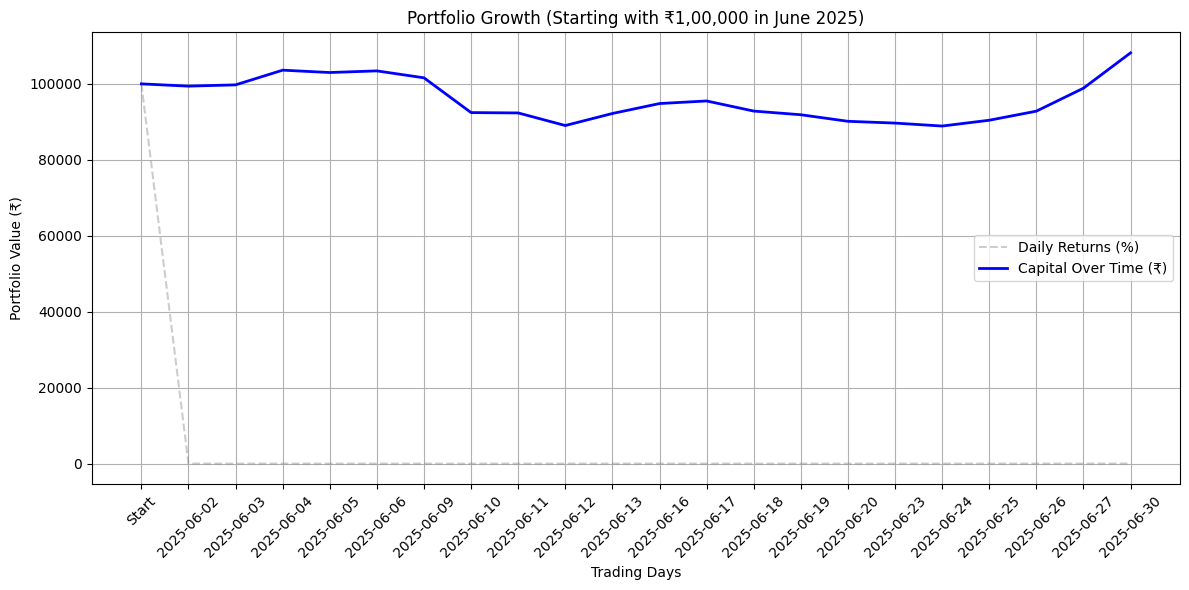


💼 Final Portfolio Value: ₹108161.94
📊 Daily Returns (%): [np.float64(-0.6), np.float64(0.34), np.float64(3.88), np.float64(-0.6), np.float64(0.42), np.float64(-1.77), np.float64(-9.01), np.float64(-0.1), np.float64(-3.59), np.float64(3.56), np.float64(2.84), np.float64(0.72), np.float64(-2.79), np.float64(-1.04), np.float64(-1.88), np.float64(-0.52), np.float64(-0.87), np.float64(1.72), np.float64(2.64), np.float64(6.52), np.float64(9.41)]

🔍 Exit Reason Summary:
▶️ SL Hit: 72 trades → ✅ Wins: 25 | ❌ Losses: 47 | 🏆 Win%: 34.72%
▶️ Inverted Red Candle: 22 trades → ✅ Wins: 1 | ❌ Losses: 21 | 🏆 Win%: 4.55%
▶️ End of Day Exit: 9 trades → ✅ Wins: 7 | ❌ Losses: 2 | 🏆 Win%: 77.78%


,date,symbol,trigger_time,entry_time,entry_price,exit_time,exit_price,pnl_%,reason
0,2025-06-02,NSE:DBREALTY-EQ,2025-06-02 13:20:00+05:30,2025-06-02 13:25:00+05:30,197.24,2025-06-02 13:45:00+05:30,201.9501,2.39,SL Hit
1,2025-06-02,NSE:IFCI-EQ,2025-06-02 13:15:00+05:30,2025-06-02 13:20:00+05:30,68.95,2025-06-02 13:55:00+05:30,67.9000,-1.52,SL Hit
2,2025-06-02,NSE:MTNL-EQ,2025-06-02 12:30:00+05:30,2025-06-02 12:35:00+05:30,50.41,2025-06-02 13:05:00+05:30,50.2524,-0.31,SL Hit
3,2025-06-02,NSE:POKARNA-EQ,2025-06-02 14:15:00+05:30,2025-06-02 14:20:00+05:30,1050.00,2025-06-02 15:00:00+05:30,1037.8000,-1.16,SL Hit
4,2025-06-03,NSE:NOCIL-EQ,2025-06-03 12:05:00+05:30,2025-06-03 12:10:00+05:30,194.05,2025-06-03 12:50:00+05:30,195.1290,0.56,SL Hit
...,...,...,...,...,...,...,...,...,...
98,2025-06-27,NSE:SKYGOLD-EQ,2025-06-27 12:10:00+05:30,2025-06-27 12:15:00+05:30,332.50,2025-06-27 12:40:00+05:30,328.5500,-1.19,SL Hit
99,2025-06-30,NSE:PFOCUS-EQ,2025-06-30 13:35:00+05:30,2025-06-30 13:40:00+05:30,136.45,2025-06-30 13:45:00+05:30,135.8800,-0.42,Inverted Red Candle
100,2025-06-30,NSE:RAYMOND-EQ,2025-06-30 12:45:00+05:30,2025-06-30 12:50:00+05:30,651.00,2025-06-30 13:35:00+05:30,702.9990,7.99,SL Hit
101,2025-06-30,NSE:STYLEBAAZA-EQ,2025-06-30 14:30:00+05:30,2025-06-30 14:35:00+05:30,314.00,2025-06-30 15:00:00+05:30,310.2500,-1.19,SL Hit


In [ ]:
#JUNE AFTER CHANGES
import pandas as pd
import matplotlib.pyplot as plt
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1oyUmI4SF9MUkZ5dXVrODNncnFXV093Wm85UElxaDhFeGF3MEpGd2p0a3dSUEhYU0tGWkVnYTlGSEJlUFplVEduLTBtUXJlaFc3dXR4N1A5YkJ1Tm4tN0tqNkZNejNYanZnbFplcWtXeVBINThoZz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTY3NTQwMCwiaWF0IjoxNzUxNjA2MzYzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE2MDYzNjMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.cO6-U96MD0KpHMDZW5lGoKQpTEpLG6d3-VyR3-PaqsU"  # Replace with valid access token
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# Define trading days in June 2025
dates_to_backtest = [
    "2025-06-02", "2025-06-03", "2025-06-04", "2025-06-05", "2025-06-06",
    "2025-06-09", "2025-06-10", "2025-06-11", "2025-06-12", "2025-06-13",
    "2025-06-16", "2025-06-17", "2025-06-18", "2025-06-19", "2025-06-20",
    "2025-06-23", "2025-06-24", "2025-06-25", "2025-06-26", "2025-06-27",
    "2025-06-30"
]

fyers_symbols = fyers_symbols_filtered  # Define this before running

initial_capital = 100000
capital = initial_capital
capital_curve = [capital]
daily_returns = []
all_trades = []

for date in dates_to_backtest:
    daily_pnl = 0
    trade_details = []

    for symbol in fyers_symbols:
        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok":
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            trade_entered = False
            open_915 = df.iloc[0]["open"]
            close_915 = df.iloc[0]["close"]
            avg_915 = (open_915 + close_915) / 2

            for i in range(5, len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("12:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close = row["open"], row["close"]
                ema_9, ema_20 = row["ema_9"], row["ema_20"]
                move_pct = (close - open_) / open_

                from_open_915_pct = (close - avg_915) / avg_915
                if from_open_915_pct > 0.05:
                    continue

                avg_vol = df.iloc[:i]["volume"].mean()
                price_est = (row["high"] + row["low"]) / 2
                liquidity_turnover = avg_vol * price_est
                if liquidity_turnover < 3e6:
                    continue

                # 🛑 Top Wick Filter
                if (row["high"] - row["close"]) >= 0.5 * abs(row["close"] - row["open"]):
                    continue

                if move_pct >= 0.01 and open_ > ema_9 and open_ > ema_20:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]

                    # 🛑 Inverted Red Candle Exit Check
                    if entry_candle["open"] > entry_candle["close"] and \
                       (entry_candle["open"] - entry_candle["close"]) < 0.3 * (entry_candle["high"] - entry_candle["low"]):
                        exit_price = df.iloc[i + 2]["open"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        daily_pnl += pnl
                        trade_details.append(pnl)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": df.iloc[i + 2].name,
                            "exit_price": exit_price,
                            "pnl_%": pnl,
                            "reason": "Inverted Red Candle"
                        })
                        trade_entered = True
                        break

                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            daily_pnl += pnl
                            trade_details.append(pnl)
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl,
                                "reason": "SL Hit"
                            })
                            trade_entered = True
                            break
                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])
                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        daily_pnl += pnl
                        trade_details.append(pnl)
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl,
                            "reason": "End of Day Exit"
                        })
                        trade_entered = True

        except Exception as e:
            continue

    capital *= (1 + daily_pnl / 100)
    capital_curve.append(round(capital, 2))
    daily_returns.append(round(daily_pnl, 2))

    # ✅ Print daily summary
    print(f"\n📅 {date} Summary:")
    print(f"   📈 Trades Taken: {len(trade_details)}")
    print(f"   💰 Day's Return: {round(daily_pnl, 2)}%")
    if trade_details:
        print(f"   📋 Trades PnL: {trade_details}")

# 📈 Plot capital growth curve
plt.figure(figsize=(12, 6))
plt.plot([initial_capital] + daily_returns, label="Daily Returns (%)", color="gray", linestyle="--", alpha=0.4)
plt.plot(capital_curve, label="Capital Over Time (₹)", color="blue", linewidth=2)
plt.title("Portfolio Growth (Starting with ₹1,00,000 in June 2025)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value (₹)")
plt.xticks(range(len(dates_to_backtest)+1), ["Start"] + dates_to_backtest, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 📋 Print Final Summary
print(f"\n💼 Final Portfolio Value: ₹{round(capital, 2)}")
print("📊 Daily Returns (%):", daily_returns)

# 📁 Save all trade details if needed
results_df = pd.DataFrame(all_trades)

# results_df.to_csv("june_backtest_trades_with_filters.csv", index=False)
print("\n🔍 Exit Reason Summary:")
if not results_df.empty:
    reason_counts = results_df["reason"].value_counts()
    for reason, count in reason_counts.items():
        sub_df = results_df[results_df["reason"] == reason]
        wins = sub_df[sub_df["pnl_%"] > 0].shape[0]
        losses = sub_df[sub_df["pnl_%"] <= 0].shape[0]
        win_rate = round((wins / (wins + losses)) * 100, 2) if (wins + losses) > 0 else 0
        print(f"▶️ {reason}: {count} trades → ✅ Wins: {wins} | ❌ Losses: {losses} | 🏆 Win%: {win_rate}%")
else:
    print("No trades recorded.")

results_df

# data fetching

In [ ]:
'''import pandas as pd

# Load the CSV
df = pd.read_csv('/content/stocks_above_1kcr.csv')

# Convert MARKET_CAP_CR to numeric if it's not already
df['MARKET_CAP_CR'] = pd.to_numeric(df['MARKET_CAP_CR'], errors='coerce')

# Filter above 2000 Cr
above_3k = df[df['MARKET_CAP_CR'] > 3000]

# Filter above 5000 Cr
above_4k = df[df['MARKET_CAP_CR'] > 4000]

# Save to new CSV files
above_3k.to_csv('/content/stocks_above_3kcr.csv', index=False)
above_4k.to_csv('/content/stocks_above_4kcr.csv', index=False)

print("CSV files saved for >3k Cr and >4k Cr market cap.")'''

In [ ]:
import pandas as pd
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1pqeTlzd1d0b2t0aDc1YUdPdFFHbEx6aF82T2oybmVCTThycFg1cjFhWDBib01hZXF5dnV0MURJQjJKQTFJaE9Wa0tJdWIzUHhmOWJaNWViOWNOYXZYUVdxTVNQaEsxbUdWeXJRdjljbEdpM2hSST0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTU4OTAwMCwiaWF0IjoxNzUxNTMwNjg1LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE1MzA2ODUsInN1YiI6ImFjY2Vzc190b2tlbiJ9.dYXtFS4S_dcSxuwsZNneAfltKzuKeG2BI43ALsAFheQ"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

dates_to_check =[
    "2025-06-02", "2025-06-03", "2025-06-04", "2025-06-05", "2025-06-06",
    "2025-06-09", "2025-06-10", "2025-06-11", "2025-06-12", "2025-06-13",
    "2025-06-16", "2025-06-17", "2025-06-18", "2025-06-19", "2025-06-20",
    "2025-06-23", "2025-06-24", "2025-06-25", "2025-06-26", "2025-06-27",
    "2025-06-30"
]
fyers_symbols = fyers_symbols_filtered  # Make sure this is defined

for date in dates_to_check:
    print(f"\n📅 {date} → Stocks with >1% move from 11:00AM to Close:\n")

    for symbol in fyers_symbols:
        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok" or len(data["candles"]) < 2:
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)

            # Get first candle after 11:00
            df_after_11 = df[df.index.time >= pd.to_datetime("11:00").time()]
            if df_after_11.empty:
                continue

            open_11am = df_after_11.iloc[0]["open"]
            close_last = df.iloc[-1]["close"]
            move_pct = ((close_last - open_11am) / open_11am) * 100

            if (move_pct) > 4:  # Use 1% for debug, increase to 4 or 5% later
                direction = "🔺" if move_pct > 0 else "🔻"
                print(f"{direction} {symbol} → {round(move_pct, 2)}%")

            time.sleep(0.01)  # Light delay for rate limits

        except Exception as e:
            # Uncomment for debugging
            # print(f"Error in {symbol}: {e}")
            continue



📅 2025-06-02 → Stocks with >1% move from 11:00AM to Close:

🔺 NSE:APCOTEXIND-EQ → 4.8%
🔺 NSE:ASTRAZEN-EQ → 4.45%
🔺 NSE:AVANTEL-EQ → 6.66%
🔺 NSE:BRIGADE-EQ → 4.26%
🔺 NSE:CDSL-EQ → 6.59%
🔺 NSE:DBREALTY-EQ → 6.55%
🔺 NSE:FIEMIND-EQ → 4.68%
🔺 NSE:KRISHANA-EQ → 4.73%
🔺 NSE:MARATHON-EQ → 6.78%
🔺 NSE:MOL-EQ → 5.97%
🔺 NSE:NITINSPIN-EQ → 4.31%
🔺 NSE:OLAELEC-EQ → 5.85%
🔺 NSE:OMAXE-EQ → 5.19%
🔺 NSE:ORIENTHOT-EQ → 5.35%
🔺 NSE:PRECAM-EQ → 6.65%
🔺 NSE:REFEX-EQ → 4.73%
🔺 NSE:SANOFICONR-EQ → 5.63%
🔺 NSE:SINDHUTRAD-EQ → 9.26%
🔺 NSE:TCIEXP-EQ → 7.62%

📅 2025-06-03 → Stocks with >1% move from 11:00AM to Close:

🔺 NSE:AEGISVOPAK-EQ → 4.95%
🔺 NSE:FACT-EQ → 4.16%
🔺 NSE:GKWLIMITED-EQ → 5.82%
🔺 NSE:JISLDVREQS-EQ → 4.26%
🔺 NSE:NITCO-EQ → 4.91%
🔺 NSE:SERVOTECH-EQ → 4.14%
🔺 NSE:SHREEPUSHK-EQ → 8.74%
🔺 NSE:STERTOOLS-EQ → 7.49%
🔺 NSE:VOLTAMP-EQ → 5.22%

📅 2025-06-04 → Stocks with >1% move from 11:00AM to Close:

🔺 NSE:AETHER-EQ → 4.08%
🔺 NSE:ALLCARGO-EQ → 4.59%
🔺 NSE:CANTABIL-EQ → 4.83%
🔺 NSE:GLAXO-EQ → 4.84%
🔺 NS

In [ ]:
import pandas as pd
from fyers_apiv3 import fyersModel
import time

client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1oyUmI4SF9MUkZ5dXVrODNncnFXV093Wm85UElxaDhFeGF3MEpGd2p0a3dSUEhYU0tGWkVnYTlGSEJlUFplVEduLTBtUXJlaFc3dXR4N1A5YkJ1Tm4tN0tqNkZNejNYanZnbFplcWtXeVBINThoZz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTY3NTQwMCwiaWF0IjoxNzUxNjA2MzYzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE2MDYzNjMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.cO6-U96MD0KpHMDZW5lGoKQpTEpLG6d3-VyR3-PaqsU"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

dates_to_check =[
    "2025-06-02", "2025-06-03", "2025-06-04", "2025-06-05", "2025-06-06",
    "2025-06-09", "2025-06-10", "2025-06-11", "2025-06-12", "2025-06-13",
    "2025-06-16", "2025-06-17", "2025-06-18", "2025-06-19", "2025-06-20",
    "2025-06-23", "2025-06-24", "2025-06-25", "2025-06-26", "2025-06-27",
    "2025-06-30"
]
fyers_symbols = fyers_symbols_filtered  # Make sure this is defined

for date in dates_to_check:
    print(f"\n📅 {date} → Stocks with >1% move from 11:00AM to Close:\n")

    for symbol in fyers_symbols:
        try:
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }
            data = fyers.history(payload)
            if data["s"] != "ok" or len(data["candles"]) < 2:
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)

            # Get first candle after 11:00
            df_after_11 = df[df.index.time >= pd.to_datetime("11:00").time()]
            if df_after_11.empty:
                continue

            open_11am = df_after_11.iloc[0]["open"]
            close_last = df.iloc[-1]["close"]
            move_pct = ((close_last - open_11am) / open_11am) * 100

            if (move_pct) > 4:  # Use 1% for debug, increase to 4 or 5% later
                direction = "🔺" if move_pct > 0 else "🔻"
                print(f"{direction} {symbol} → {round(move_pct, 2)}%")

            time.sleep(0.01)  # Light delay for rate limits

        except Exception as e:
            # Uncomment for debugging
            # print(f"Error in {symbol}: {e}")
            continue


📅 2025-06-02 → Stocks with >1% move from 11:00AM to Close:

🔺 NSE:APCOTEXIND-EQ → 4.8%


KeyboardInterrupt: 

In [ ]:
#VARIABLE TURNOVER
'''
import pandas as pd
import matplotlib.pyplot as plt
from fyers_apiv3 import fyersModel
import time

# Load market cap data and clean it
marketcap_df = pd.read_csv("/content/stocks_above_1kcr.csv")
marketcap_df["SYMBOL"] = marketcap_df["SYMBOL"].astype(str).str.strip().str.upper()
marketcap_df["fyers_symbol"] = "NSE:" + marketcap_df["SYMBOL"]

# Create dictionary for quick market cap lookup
symbol_to_mcap = dict(zip(marketcap_df["fyers_symbol"], marketcap_df["MARKET_CAP"]))

# Example list: you can replace this with your full list from another source
# For demo, let's use the ones directly from market cap file and append "-EQ"
fyers_symbols = ["NSE:" + sym + "-EQ" for sym in marketcap_df["SYMBOL"]]

# FYERS credentials
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1phWnd4M2llelNERGdYQ0lQcEIxWlNObmF5VkpYdGxnYndEVjdVOUZjQWI5ZTRPdEZtNkR3ZEJZVlpiRU43cUM3V00xaDhsaXhkSkhQYWp3d2hueEFfbkE0cjk1dHo2aGtnT25Dcjh2aTFsTGlSOD0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTU4OTAwMCwiaWF0IjoxNzUxNDkyMjA4LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE0OTIyMDgsInN1YiI6ImFjY2Vzc190b2tlbiJ9.ryLoHhjyQCbIcxGfBXos08RrP9M2-yDko8wZm8pfOP8"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# Dates to backtest
dates_to_backtest = ["2025-06-09"]  # add more if needed

initial_capital = 100000
capital = initial_capital
capital_curve = [capital]
daily_returns = []
all_trades = []

print(f"🧠 Running backtest for {len(fyers_symbols)} symbols...\n")

for date in dates_to_backtest:
    print(f"📅 Backtesting for {date}")
    daily_pnl = 0

    for symbol in fyers_symbols:
        try:
            print(f"🔍 Checking {symbol}")
            payload = {
                "symbol": symbol,
                "resolution": "5",
                "date_format": "1",
                "range_from": date,
                "range_to": date,
                "cont_flag": "1"
            }

            data = fyers.history(payload)
            if data["s"] != "ok" or not data.get("candles"):
                print(f"⚠️ No data for {symbol} on {date}")
                continue

            df = pd.DataFrame(data["candles"], columns=["timestamp", "open", "high", "low", "close", "volume"])
            df["time"] = pd.to_datetime(df["timestamp"], unit="s").dt.tz_localize("UTC").dt.tz_convert("Asia/Kolkata")
            df.set_index("time", inplace=True)
            df["ema_9"] = df["close"].ewm(span=9, adjust=False).mean()
            df["ema_20"] = df["close"].ewm(span=20, adjust=False).mean()
            df.dropna(inplace=True)

            if len(df) < 10:
                continue

            # Prepare symbol without "-EQ" to match market cap map
            symbol_base = symbol.replace("-EQ", "")
            if symbol_base not in symbol_to_mcap:
                print(f"❌ {symbol_base} not in market cap CSV. Skipping.")
                continue

            market_cap = symbol_to_mcap[symbol_base]
            min_turnover = market_cap * 0.0005  # 0.05% of market cap

            trade_entered = False
            open_915 = df.iloc[0]["open"]
            close_915 = df.iloc[0]["close"]
            avg_915 = (open_915 + close_915) / 2

            for i in range(5, len(df) - 2):
                if trade_entered:
                    break

                row = df.iloc[i]
                time_only = row.name.time()
                if not (pd.to_datetime("12:00").time() <= time_only <= pd.to_datetime("14:30").time()):
                    continue

                open_, close, volume = row["open"], row["close"], row["volume"]
                ema_9, ema_20 = row["ema_9"], row["ema_20"]
                move_pct = (close - open_) / open_
                from_open_915_pct = (close - avg_915) / avg_915
                if from_open_915_pct > 0.06:
                    continue

                avg_vol = df.iloc[:i]["volume"].mean()
                price_est = (row["high"] + row["low"]) / 2
                liquidity_turnover = avg_vol * price_est

                if liquidity_turnover < min_turnover:
                    continue

                if move_pct >= 0.01 and open_ > ema_9 and open_ > ema_20:
                    entry_candle = df.iloc[i + 1]
                    entry_price = entry_candle["open"]
                    sl = entry_price - 0.01 * entry_price if move_pct > 0.02 else open_

                    for j in range(i + 2, len(df)):
                        next_candle = df.iloc[j]

                        if next_candle["low"] <= sl:
                            exit_price = sl
                            pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                            daily_pnl += pnl
                            all_trades.append({
                                "date": date,
                                "symbol": symbol,
                                "trigger_time": row.name,
                                "entry_time": entry_candle.name,
                                "entry_price": entry_price,
                                "exit_time": next_candle.name,
                                "exit_price": exit_price,
                                "pnl_%": pnl
                            })
                            trade_entered = True
                            break
                        elif next_candle["close"] > entry_price:
                            sl = max(sl, next_candle["close"] - 0.01 * next_candle["close"])
                    else:
                        final_exit = df.iloc[-1]
                        exit_price = final_exit["close"]
                        pnl = round((exit_price - entry_price) / entry_price * 100, 2)
                        daily_pnl += pnl
                        all_trades.append({
                            "date": date,
                            "symbol": symbol,
                            "trigger_time": row.name,
                            "entry_time": entry_candle.name,
                            "entry_price": entry_price,
                            "exit_time": final_exit.name,
                            "exit_price": exit_price,
                            "pnl_%": pnl
                        })
                        trade_entered = True

        except Exception as e:
            print(f"🚫 Error for {symbol}: {str(e)}")
            continue

    capital *= (1 + daily_pnl / 100)
    capital_curve.append(round(capital, 2))
    daily_returns.append(round(daily_pnl, 2))
    print(f"✅ {date} done. Daily PnL: {daily_pnl:.2f}%\n")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot([initial_capital] + daily_returns, label="Daily Returns (%)", color="gray", linestyle="--", alpha=0.4)
plt.plot(capital_curve, label="Capital Over Time (₹)", color="blue", linewidth=2)
plt.title("Portfolio Growth (Starting with ₹1,00,000)")
plt.xlabel("Trading Days")
plt.ylabel("Portfolio Value (₹)")
plt.xticks(range(len(dates_to_backtest)+1), ["Start"] + dates_to_backtest, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Summary
print(f"\n💼 Final Portfolio Value: ₹{round(capital, 2)}")
print("📊 Daily Returns (%):", daily_returns)

# Save trade results
results_df = pd.DataFrame(all_trades)
results_df.to_csv("backtest_trades.csv", index=False)
results_df'''


🧠 Running backtest for 1306 symbols...

📅 Backtesting for 2025-06-09
🔍 Checking NSE:360ONE-EQ
🔍 Checking NSE:3MINDIA-EQ
🔍 Checking NSE:5PAISA-EQ
🔍 Checking NSE:63MOONS-EQ
🔍 Checking NSE:AADHARHFC-EQ
🔍 Checking NSE:AARTIDRUGS-EQ
🔍 Checking NSE:AARTIIND-EQ
🔍 Checking NSE:AARTIPHARM-EQ


KeyboardInterrupt: 

# BreakOut Strategy

In [ ]:
import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1o3cUtxTHJ3R2hZRmJyOTNjNldZcUk3enE2ZTlRQ2NxRFN3Y01zQWw4U203RVVWdUFjai1SanpXd2Nuc2Z1d0pyakp6bEx2NVBNWnl1cmJVYUZmTDQwWnlzRUtBaGdISmx2N0R4RVl5UzAzLVVkcz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTY3NTQwMCwiaWF0IjoxNzUxNjI4NDI2LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE2Mjg0MjYsInN1YiI6ImFjY2Vzc190b2tlbiJ9.zl2V43LLPXHUFpitNdjYUhjqUUuqZhH1-zazGOzp_94"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Inputs ===
dates_to_check = ["2025-06-26"]
fyers_symbols = fyers_symbols_filtered  # Make sure this list is defined

# === Parameters ===
window_size = 24
max_range_pct = 0.02
volume_multiplier = 3
entry_buffer_pct = 0.01
min_body_pct = 0.0075
confirmation_breakout_pct = 0.01  # 1% breakout

# === Fetch 5-min Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]
            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            # ❌ Skip trade if upper wick is large
            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]
                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99  # ✅ Fixed 1% SL
                        remaining_candles = candles_after.iloc[j + 1:]

                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
all_trades = []

for date in dates_to_check:
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        print(f"✅ Data fetched: {symbol} on {date}, {len(df)} candles")
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            print(f"🔍 Trades found: {len(trades)}")
            all_trades.extend(trades)
        time.sleep(0)  # Adjust if needed to handle rate limit

# === Results ===
trades_df = pd.DataFrame(all_trades)

if trades_df.empty:
    print("\n❌ No trades were generated.")
else:
    trades_df['date'] = pd.to_datetime(trades_df['date']).dt.date
    daily_returns = []
    portfolio_value = 100000

    for date, group in trades_df.groupby('date'):
        pnls = group['pnl_%'].values
        trades_taken = len(pnls)
        day_return = round(np.sum(pnls), 2)
        daily_returns.append(np.float64(day_return))

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {trades_taken}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[np.float64(round(p, 2)) for p in pnls]}")

    for ret in daily_returns:
        portfolio_value *= (1 + float(ret) / 100)

    print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")
    print(f"📊 Daily Returns (%): {daily_returns}")

    print("\n🔍 Exit Reason Summary:")
    exit_summary = trades_df['reason'].value_counts().to_dict()
    for reason in exit_summary:
        total = exit_summary[reason]
        wins = sum((trades_df['reason'] == reason) & (trades_df['pnl_%'] > 0))
        losses = total - wins
        win_pct = round((wins / total) * 100, 2)
        print(f"▶️ {reason}: {total} trades → ✅ Wins: {wins} | ❌ Losses: {losses} | 🏆 Win%: {win_pct}%")

    print("\n📋 Trade Log:")
    print(trades_df[['date', 'symbol', 'trigger_time', 'entry_time', 'entry_price',
                     'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))


✅ Data fetched: NSE:360ONE-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:3MINDIA-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:63MOONS-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AADHARHFC-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AARTIDRUGS-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AARTIIND-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AARTIPHARM-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AAVAS-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABB-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABBOTINDIA-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABCAPITAL-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABDL-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABFRL-EQ on 2025-06-26, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABR

In [ ]:
import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb1o3cUtxTHJ3R2hZRmJyOTNjNldZcUk3enE2ZTlRQ2NxRFN3Y01zQWw4U203RVVWdUFjai1SanpXd2Nuc2Z1d0pyakp6bEx2NVBNWnl1cmJVYUZmTDQwWnlzRUtBaGdISmx2N0R4RVl5UzAzLVVkcz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTY3NTQwMCwiaWF0IjoxNzUxNjI4NDI2LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE2Mjg0MjYsInN1YiI6ImFjY2Vzc190b2tlbiJ9.zl2V43LLPXHUFpitNdjYUhjqUUuqZhH1-zazGOzp_94"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Inputs ===
dates_to_check = ["2025-07-01","2025-07-02"]
fyers_symbols = fyers_symbols_filtered  # Make sure this list is defined

# === Parameters ===
window_size = 24
max_range_pct = 0.02
volume_multiplier = 3
entry_buffer_pct = 0.01
min_body_pct = 0.0075
confirmation_breakout_pct = 0.01  # 1% breakout

# === Fetch 5-min Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]
            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            # ❌ Skip trade if upper wick is large
            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]
                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99  # ✅ Fixed 1% SL
                        remaining_candles = candles_after.iloc[j + 1:]

                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
all_trades = []

for date in dates_to_check:
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        print(f"✅ Data fetched: {symbol} on {date}, {len(df)} candles")
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            print(f"🔍 Trades found: {len(trades)}")
            all_trades.extend(trades)
        time.sleep(0)  # Adjust if needed to handle rate limit

# === Results ===
trades_df = pd.DataFrame(all_trades)

if trades_df.empty:
    print("\n❌ No trades were generated.")
else:
    trades_df['date'] = pd.to_datetime(trades_df['date']).dt.date
    daily_returns = []
    portfolio_value = 100000

    for date, group in trades_df.groupby('date'):
        pnls = group['pnl_%'].values
        trades_taken = len(pnls)
        day_return = round(np.sum(pnls), 2)
        daily_returns.append(np.float64(day_return))

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {trades_taken}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[np.float64(round(p, 2)) for p in pnls]}")

    for ret in daily_returns:
        portfolio_value *= (1 + float(ret) / 100)

    print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")
    print(f"📊 Daily Returns (%): {daily_returns}")

    print("\n🔍 Exit Reason Summary:")
    exit_summary = trades_df['reason'].value_counts().to_dict()
    for reason in exit_summary:
        total = exit_summary[reason]
        wins = sum((trades_df['reason'] == reason) & (trades_df['pnl_%'] > 0))
        losses = total - wins
        win_pct = round((wins / total) * 100, 2)
        print(f"▶️ {reason}: {total} trades → ✅ Wins: {wins} | ❌ Losses: {losses} | 🏆 Win%: {win_pct}%")

    print("\n📋 Trade Log:")
    print(trades_df[['date', 'symbol', 'trigger_time', 'entry_time', 'entry_price',
                     'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))

✅ Data fetched: NSE:360ONE-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:3MINDIA-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:63MOONS-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AADHARHFC-EQ on 2025-07-01, 75 candles
🔍 Trades found: 1
✅ Data fetched: NSE:AARTIDRUGS-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AARTIIND-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AARTIPHARM-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AAVAS-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABB-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABBOTINDIA-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABCAPITAL-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABDL-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABFRL-EQ on 2025-07-01, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABR

In [ ]:
import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2FKRkZNVW5DZGlxQWp6VG56bFp1ZXBxN3dHR3pQX2VGVGd6dDA0c0E3LWFlWXNuWU9PM3pmeWJEOE1lbi1UeVVhSmlaZ3NSSDF3OE5FNnp0QmIzdVpFeW1STWNiejlOaXNrRk5VZGtScFh3TGlxYz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTc2MTgwMCwiaWF0IjoxNzUxNjgzMzk3LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE2ODMzOTcsInN1YiI6ImFjY2Vzc190b2tlbiJ9.nBPT-wwjrcFQ7xrcFYsy5FvuuV6VRBi0O6gSpyThio4"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Inputs ===
dates_to_check = [
    "2025-05-02", "2025-05-05", "2025-05-06", "2025-05-07", "2025-05-08",
    "2025-05-09", "2025-05-12", "2025-05-13", "2025-05-14", "2025-05-15",
    "2025-05-16", "2025-05-19", "2025-05-20", "2025-05-21", "2025-05-22",
    "2025-05-23", "2025-05-26", "2025-05-27", "2025-05-28", "2025-05-29",
    "2025-05-30"
]
fyers_symbols = fyers_symbols_filtered  # Make sure this list is defined

# === Parameters ===
window_size = 24
max_range_pct = 0.02
volume_multiplier = 3
entry_buffer_pct = 0.01
min_body_pct = 0.0075
confirmation_breakout_pct = 0.01  # 1% breakout

# === Fetch 5-min Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]
            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            # ❌ Skip trade if upper wick is large
            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]
                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99  # ✅ Fixed 1% SL
                        remaining_candles = candles_after.iloc[j + 1:]

                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
all_trades = []

for date in dates_to_check:
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        #print(f"✅ Data fetched: {symbol} on {date}, {len(df)} candles")
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            #print(f"🔍 Trades found: {len(trades)}")
            all_trades.extend(trades)
        time.sleep(0)  # Adjust if needed to handle rate limit

# === Results ===
trades_df = pd.DataFrame(all_trades)

if trades_df.empty:
    print("\n❌ No trades were generated.")
else:
    trades_df['date'] = pd.to_datetime(trades_df['date']).dt.date
    daily_returns = []
    portfolio_value = 100000

    for date, group in trades_df.groupby('date'):
        pnls = group['pnl_%'].values
        trades_taken = len(pnls)
        day_return = round(np.sum(pnls), 2)
        daily_returns.append(np.float64(day_return))

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {trades_taken}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[np.float64(round(p, 2)) for p in pnls]}")

    for ret in daily_returns:
        portfolio_value *= (1 + float(ret) / 100)

    print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")
    print(f"📊 Daily Returns (%): {daily_returns}")

    print("\n🔍 Exit Reason Summary:")
    exit_summary = trades_df['reason'].value_counts().to_dict()
    for reason in exit_summary:
        total = exit_summary[reason]
        wins = sum((trades_df['reason'] == reason) & (trades_df['pnl_%'] > 0))
        losses = total - wins
        win_pct = round((wins / total) * 100, 2)
        print(f"▶️ {reason}: {total} trades → ✅ Wins: {wins} | ❌ Losses: {losses} | 🏆 Win%: {win_pct}%")

    #print("\n📋 Trade Log:")
    #print(trades_df[['date', 'symbol', 'trigger_time', 'entry_time', 'entry_price',
     #                'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))

⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-02
⚠️ No candles for NSE:ATHERENERG-EQ on 2025-05-02
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-02
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-02
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-02
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-05
⚠️ No candles for NSE:ATHERENERG-EQ on 2025-05-05
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-05
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-05
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-05
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-06
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-06
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-06
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-06
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-07
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-07
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-07
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-07
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-08
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-08
⚠️ No candles for NSE:O

In [ ]:
#trying ..........................................................................................................
import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2FVbmRYNm5WMThaSk93UFk4QTlaN29fUVN2N3RrSDBGOERPSnJpdFVJU0d6SjVObXZvakgwcDBaOGhIaXhfN21EbFJkRmgwSThCejZnVnNjOUpSNFppNjlHaGR3Z29UVFVPeWNZWGpvSnltejlIWT0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTc2MTgwMCwiaWF0IjoxNzUxNzMwNjUzLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE3MzA2NTMsInN1YiI6ImFjY2Vzc190b2tlbiJ9.2PAqSpaL4PcIIVlWMjeqeTlyUJgfD4iDZmI0Ve_Mxco"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Inputs ===

dates_to_check = ["2025-06-23", "2025-06-24", "2025-06-25", "2025-06-26",
    "2025-06-27","2025-06-30","2025-07-01","2025-07-02","2025-07-03"]
fyers_symbols = fyers_symbols_filtered  # Make sure this list is defined

# === Parameters ===
window_size = 24
max_range_pct = 0.02
volume_multiplier = 3
entry_buffer_pct = 0.01
min_body_pct = 0.0075
confirmation_breakout_pct = 0.015  # 1% breakout

# === Fetch 5-min Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]
            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            # ❌ Skip trade if upper wick is large
            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]
                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99  # ✅ Fixed 1% SL
                        remaining_candles = candles_after.iloc[j + 1:]

                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
all_trades = []

for date in dates_to_check:
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        print(f"✅ Data fetched: {symbol} on {date}, {len(df)} candles")
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            print(f"🔍 Trades found: {len(trades)}")
            all_trades.extend(trades)
        time.sleep(0)  # Adjust if needed to handle rate limit

# === Results ===
trades_df = pd.DataFrame(all_trades)

if trades_df.empty:
    print("\n❌ No trades were generated.")
else:
    trades_df['date'] = pd.to_datetime(trades_df['date']).dt.date
    daily_returns = []
    portfolio_value = 100000

    for date, group in trades_df.groupby('date'):
        pnls = group['pnl_%'].values
        trades_taken = len(pnls)
        day_return = round(np.sum(pnls), 2)
        daily_returns.append(np.float64(day_return))

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {trades_taken}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[np.float64(round(p, 2)) for p in pnls]}")

    for ret in daily_returns:
        portfolio_value *= (1 + float(ret) / 100)

    print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")
    print(f"📊 Daily Returns (%): {daily_returns}")

    print("\n🔍 Exit Reason Summary:")
    exit_summary = trades_df['reason'].value_counts().to_dict()
    for reason in exit_summary:
        total = exit_summary[reason]
        wins = sum((trades_df['reason'] == reason) & (trades_df['pnl_%'] > 0))
        losses = total - wins
        win_pct = round((wins / total) * 100, 2)
        print(f"▶️ {reason}: {total} trades → ✅ Wins: {wins} | ❌ Losses: {losses} | 🏆 Win%: {win_pct}%")

    print("\n📋 Trade Log:")
    print(trades_df[['date', 'symbol', 'trigger_time', 'entry_time', 'entry_price',
                     'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))

✅ Data fetched: NSE:360ONE-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:3MINDIA-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:63MOONS-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AADHARHFC-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AARTIDRUGS-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AARTIIND-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AARTIPHARM-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:AAVAS-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABB-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABBOTINDIA-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABCAPITAL-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABDL-EQ on 2025-07-02, 75 candles
🔍 Trades found: 0
✅ Data fetched: NSE:ABFRL-EQ on 2025-07-02, 75 candles
🔍 Trades found: 1
✅ Data fetched: NSE:ABR

In [ ]:
import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2FpNjFKTXFXWkZCMEtUMjBIempHczBTUE1DQmRPTzZad1RxMWt1R3Y5XzNuallWS0RST3UzcGI3OWdMOHdvTTJLdGc0a1FrRFlPTG1PN2E4OXdmakVIeUswUUtsZkk2aEhrMkhkbDNPZUl3VDgzYz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTg0ODIwMCwiaWF0IjoxNzUxNzg5MjM3LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE3ODkyMzcsInN1YiI6ImFjY2Vzc190b2tlbiJ9.pxfBGTzIVRRK6od1SOpu_9svlO2eklfih1CUWc_8hlI"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Load Market Cap Data ===
market_cap_df = pd.read_csv('/content/stocks_above_1kcr.csv')
market_cap_dict = dict(zip(market_cap_df['SYMBOL'], market_cap_df['MARKET_CAP_CR']))

# === Inputs ===
dates_to_check = ["2025-06-23", "2025-06-24", "2025-06-25", "2025-06-26",
                 "2025-06-27", "2025-06-30", "2025-07-01", "2025-07-02", "2025-07-03"]
fyers_symbols = fyers_symbols_filtered  # Ensure this is defined

# === Parameters ===
window_size = 24
max_range_pct = 0.02
volume_multiplier = 3
entry_buffer_pct = 0.01
min_body_pct = 0.005
confirmation_breakout_pct = 0.015

# === Fetch 5-min Candle Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]
            # === Reject breakouts after 2:30 PM ===
            if breakout_candle['timestamp'].time() > pd.to_datetime("14:30").time():
              continue
            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]
                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99
                        remaining_candles = candles_after.iloc[j + 1:]
                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        symbol_key = symbol.split(':')[-1].split('-')[0]
                        market_cap = market_cap_dict.get(symbol_key, np.nan)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'market_cap_cr': round(market_cap, 2) if not pd.isna(market_cap) else np.nan,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
portfolio_value = 100000
all_trades = []

for date in dates_to_check:
    daily_trades = []
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            daily_trades.extend(trades)
        time.sleep(0)

    # Daily logs
    if daily_trades:
        daily_df = pd.DataFrame(daily_trades)
        all_trades.extend(daily_trades)

        pnls = daily_df['pnl_%'].values
        day_return = round(np.sum(pnls), 2)
        portfolio_value *= (1 + float(day_return) / 100)

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {len(pnls)}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[round(p, 2) for p in pnls]}")
        print("\n📋 Trade Log with Market Cap:")
        #print(daily_df[['date', 'symbol', 'market_cap_cr', 'trigger_time', 'entry_time', 'entry_price',
                    #    'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))
    else:
        print(f"\n📅 {date} — ❌ No trades generated.")

# === Final Portfolio Summary ===
print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")
# === Save Entire Trade Log to CSV ===
if all_trades:
    all_trades_df = pd.DataFrame(all_trades)
    all_trades_df.to_csv("all_trade_log.csv", index=False)
    print("✅ Saved all trades to all_trade_log.csv")
else:
    print("⚠️ No trades to save.")




📅 2025-06-23 Summary:
   📈 Trades Taken: 49
   💰 Day's Return: -1.67%
   📋 Trades PnL: [np.float64(-1.0), np.float64(-0.55), np.float64(-0.22), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64(0.12), np.float64(1.63), np.float64(-1.0), np.float64(-0.29), np.float64(-1.0), np.float64(-0.13), np.float64(1.24), np.float64(0.22), np.float64(-1.0), np.float64(-1.0), np.float64(1.55), np.float64(-1.0), np.float64(0.39), np.float64(-0.71), np.float64(-0.17), np.float64(1.41), np.float64(2.15), np.float64(0.4), np.float64(0.67), np.float64(-1.0), np.float64(-0.56), np.float64(-0.09), np.float64(-0.7), np.float64(0.68), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64(0.87), np.float64(0.4), np.float64(-0.61), np.float64(6.21), np.float64(-1.0), np.float64(-1.0), np.float64(-0.03), np.float64(-0.18), np.float64(-0.15), np.float64(-1.0), np.float64(0.75), np.float64(0.11), np.float64(1.66), np.float64(0.26), np.float64(-1.0)]

📋 Trade Log with M

In [ ]:
## NO TRADE AFTER 2:30PM

import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2EtRndFWTlKVVREa2hPc1RMWXI2aUp4MEJqRVZacHRJUTdHVWZDRHJXYmtmUUdneDZCYUpaVzcwdHp2TDFXQzRIWG1YQmxGQ2tCQ1huZUNNVFlNYnBPYlEzLUtjMkltOV92S3FlYzljSXNIekN6UT0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MTkzNDYwMCwiaWF0IjoxNzUxOTAwNTI4LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE5MDA1MjgsInN1YiI6ImFjY2Vzc190b2tlbiJ9.V61box-fjvi_UfGekd2WoAuCmAEXz21fd-ow5Un2ukY"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Load Market Cap Data ===
market_cap_df = pd.read_csv('/content/stocks_above_1kcr.csv')
market_cap_dict = dict(zip(market_cap_df['SYMBOL'], market_cap_df['MARKET_CAP_CR']))

# === Inputs ===
dates_to_check = ["2025-06-23", "2025-06-24", "2025-06-25", "2025-06-26",
                 "2025-06-27", "2025-06-30", "2025-07-01", "2025-07-02", "2025-07-03"]
fyers_symbols = fyers_symbols_filtered  # Ensure this is defined

# === Parameters ===
window_size = 24
max_range_pct = 0.02
volume_multiplier = 3
entry_buffer_pct = 0.01
min_body_pct = 0.005
confirmation_breakout_pct = 0.015

# === Fetch 5-min Candle Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]
            # === Reject breakouts after 2:30 PM ===
            if breakout_candle['timestamp'].time() > pd.to_datetime("14:30").time():
              continue
            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]
                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99
                        remaining_candles = candles_after.iloc[j + 1:]
                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        symbol_key = symbol.split(':')[-1].split('-')[0]
                        market_cap = market_cap_dict.get(symbol_key, np.nan)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'market_cap_cr': round(market_cap, 2) if not pd.isna(market_cap) else np.nan,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
portfolio_value = 100000
all_trades = []

for date in dates_to_check:
    daily_trades = []
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            daily_trades.extend(trades)
        time.sleep(0)

    # Daily logs
    if daily_trades:
        daily_df = pd.DataFrame(daily_trades)
        all_trades.extend(daily_trades)

        pnls = daily_df['pnl_%'].values
        day_return = round(np.sum(pnls), 2)
        portfolio_value *= (1 + float(day_return) / 100)

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {len(pnls)}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[round(p, 2) for p in pnls]}")
        print("\n📋 Trade Log with Market Cap:")
        #print(daily_df[['date', 'symbol', 'market_cap_cr', 'trigger_time', 'entry_time', 'entry_price',
                    #    'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))
    else:
        print(f"\n📅 {date} — ❌ No trades generated.")

# === Final Portfolio Summary ===
print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")
# === Save Entire Trade Log to CSV ===
if all_trades:
    all_trades_df = pd.DataFrame(all_trades)
    #all_trades_df.to_csv("all_trade_log.csv", index=False)
    print("✅ Saved all trades to all_trade_log.csv")
else:
    print("⚠️ No trades to save.")




📅 2025-06-23 Summary:
   📈 Trades Taken: 30
   💰 Day's Return: 4.95%
   📋 Trades PnL: [np.float64(-1.0), np.float64(-0.55), np.float64(-0.22), np.float64(-1.0), np.float64(-1.0), np.float64(0.12), np.float64(1.63), np.float64(-1.0), np.float64(-0.29), np.float64(-0.13), np.float64(1.24), np.float64(-1.0), np.float64(-1.0), np.float64(1.55), np.float64(-1.0), np.float64(0.39), np.float64(-0.71), np.float64(-0.17), np.float64(1.41), np.float64(2.15), np.float64(0.68), np.float64(-1.0), np.float64(-1.0), np.float64(6.21), np.float64(-1.0), np.float64(-0.03), np.float64(-1.0), np.float64(0.75), np.float64(1.66), np.float64(0.26)]

📋 Trade Log with Market Cap:

📅 2025-06-24 Summary:
   📈 Trades Taken: 17
   💰 Day's Return: -9.37%
   📋 Trades PnL: [np.float64(-0.42), np.float64(-1.0), np.float64(0.39), np.float64(-1.0), np.float64(-1.0), np.float64(0.13), np.float64(-1.0), np.float64(-1.0), np.float64(-0.41), np.float64(2.03), np.float64(-1.0), np.float64(-1.0), np.float64(-1.0), np.float64

In [ ]:

import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2JLV3F0V21CQWktMm9aZzVfa1B6RTRnZ09yV0Z1TGlBM2V4elpISDZBd3VjT3FlczRJNEVzUTVlZlJUaFEwcy1TaW1YUTh6TDlEc0JzWl9tOWhOUklyRUlTRWJtMHlEZW81aFg5blF4U1BnRWE3ST0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MjAyMTAwMCwiaWF0IjoxNzUxOTUwNzYyLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTE5NTA3NjIsInN1YiI6ImFjY2Vzc190b2tlbiJ9.XnYfyuH2W1P6TeIn4-0R-8ZCqIdYI0jTrcEDttXSfs8"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Load Market Cap Data ===
market_cap_df = pd.read_csv('/content/stocks_above_1kcr.csv')
market_cap_dict = dict(zip(market_cap_df['SYMBOL'], market_cap_df['MARKET_CAP_CR']))

# === Inputs ===
dates_to_check = [
    "2025-05-02", "2025-05-05", "2025-05-06", "2025-05-07", "2025-05-08",
    "2025-05-09", "2025-05-12", "2025-05-13", "2025-05-14", "2025-05-15",
    "2025-05-16", "2025-05-19", "2025-05-20", "2025-05-21", "2025-05-22",
    "2025-05-23", "2025-05-26", "2025-05-27", "2025-05-28", "2025-05-29",
    "2025-05-30"
]
fyers_symbols = fyers_symbols_filtered  # Ensure this is defined before running

# === Parameters ===
window_size = 24
max_range_pct = 0.02
volume_multiplier = 3
entry_buffer_pct = 0.01
min_body_pct = 0.005
confirmation_breakout_pct = 0.015

# === Fetch 5-min Candle Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]

            # Reject breakout after 2:30 PM
            if breakout_candle['timestamp'].time() > pd.to_datetime("14:30").time():
                continue

            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]

                    # Reject if entry happens after 2:30 PM
                    if row['timestamp'].time() > pd.to_datetime("14:30").time():
                        break

                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99
                        remaining_candles = candles_after.iloc[j + 1:]
                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        symbol_key = symbol.split(':')[-1].split('-')[0]
                        market_cap = market_cap_dict.get(symbol_key, np.nan)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'market_cap_cr': round(market_cap, 2) if not pd.isna(market_cap) else np.nan,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
portfolio_value = 100000
all_trades = []

for date in dates_to_check:
    daily_trades = []
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            daily_trades.extend(trades)
        time.sleep(0)

    # Daily logs
    if daily_trades:
        daily_df = pd.DataFrame(daily_trades)
        all_trades.extend(daily_trades)

        pnls = daily_df['pnl_%'].values
        day_return = round(np.sum(pnls), 2)
        portfolio_value *= (1 + float(day_return) / 100)

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {len(pnls)}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[round(p, 2) for p in pnls]}")
        print("\n📋 Trade Log with Market Cap:")
        # print(daily_df[['date', 'symbol', 'market_cap_cr', 'trigger_time', 'entry_time', 'entry_price',
        #     'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))
    else:
        print(f"\n📅 {date} — ❌ No trades generated.")

# === Final Portfolio Summary ===
print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")

# === Save Entire Trade Log to CSV ===
if all_trades:
    all_trades_df = pd.DataFrame(all_trades)
    # all_trades_df.to_csv("all_trade_log.csv", index=False)
    print("✅ Saved all trades to all_trade_log.csv")
else:
    print("⚠️ No trades to save.")


⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-02
⚠️ No candles for NSE:ATHERENERG-EQ on 2025-05-02
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-02
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-02
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-02

📅 2025-05-02 Summary:
   📈 Trades Taken: 12
   💰 Day's Return: -3.93%
   📋 Trades PnL: [np.float64(-1.0), np.float64(-0.09), np.float64(-0.74), np.float64(0.66), np.float64(-1.0), np.float64(-1.0), np.float64(1.52), np.float64(-1.0), np.float64(0.43), np.float64(0.29), np.float64(-1.0), np.float64(-1.0)]

📋 Trade Log with Market Cap:
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-05
⚠️ No candles for NSE:ATHERENERG-EQ on 2025-05-05
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-05
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-05
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-05

📅 2025-05-05 Summary:
   📈 Trades Taken: 27
   💰 Day's Return: 16.45%
   📋 Trades PnL: [np.float64(-0.31), np.float64(1.06), np.float64(1.07), np.float64(1.21), np.float64(

In [ ]:
# trying different range
# USED 1.5% range here

import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2J6NnhHZVhRNEVJWmZ1S2VBa2xmdlRfTURubkVCbGNzSWNldlZlMmt3WE9oUFFySUN5d21GQ2NpdjlSa2JvZVBURFJPdVplMk53OTIyY25IcnZqdDRheGU2cWZib0VSc0VrVmQ4NHpvaUltNExUTT0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MjE5MzgwMCwiaWF0IjoxNzUyMTIxMDA5LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTIxMjEwMDksInN1YiI6ImFjY2Vzc190b2tlbiJ9.oqitGIQAW-OL1S9hcnFqi3AbvJzifvB92WoW3kEkImE"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Load Market Cap Data ===
market_cap_df = pd.read_csv('/content/stocks_above_1kcr.csv')
market_cap_dict = dict(zip(market_cap_df['SYMBOL'], market_cap_df['MARKET_CAP_CR']))

# === Inputs ===
dates_to_check = [
    "2025-05-02", "2025-05-05", "2025-05-06", "2025-05-07", "2025-05-08",
    "2025-05-09", "2025-05-12", "2025-05-13", "2025-05-14", "2025-05-15",
    "2025-05-16", "2025-05-19", "2025-05-20", "2025-05-21", "2025-05-22",
    "2025-05-23", "2025-05-26", "2025-05-27", "2025-05-28", "2025-05-29",
    "2025-05-30"
]
fyers_symbols = fyers_symbols_filtered  # Ensure this is defined before running

# === Parameters ===
window_size = 24
max_range_pct = 0.015
volume_multiplier = 5
entry_buffer_pct = 0.01
min_body_pct = 0.005
confirmation_breakout_pct = 0.015

# === Fetch 5-min Candle Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]

            # Reject breakout after 2:30 PM
            if breakout_candle['timestamp'].time() > pd.to_datetime("14:30").time():
                continue

            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]

                    # Reject if entry happens after 2:30 PM
                    if row['timestamp'].time() > pd.to_datetime("14:30").time():
                        break

                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99
                        remaining_candles = candles_after.iloc[j + 1:]
                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        symbol_key = symbol.split(':')[-1].split('-')[0]
                        market_cap = market_cap_dict.get(symbol_key, np.nan)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'market_cap_cr': round(market_cap, 2) if not pd.isna(market_cap) else np.nan,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
portfolio_value = 100000
all_trades = []

for date in dates_to_check:
    daily_trades = []
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            daily_trades.extend(trades)
        time.sleep(0)

    # Daily logs
    if daily_trades:
        daily_df = pd.DataFrame(daily_trades)
        all_trades.extend(daily_trades)

        pnls = daily_df['pnl_%'].values
        day_return = round(np.sum(pnls), 2)
        portfolio_value *= (1 + float(day_return) / 100)

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {len(pnls)}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[round(p, 2) for p in pnls]}")
        print("\n📋 Trade Log with Market Cap:")
        # print(daily_df[['date', 'symbol', 'market_cap_cr', 'trigger_time', 'entry_time', 'entry_price',
        #     'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))
    else:
        print(f"\n📅 {date} — ❌ No trades generated.")

# === Final Portfolio Summary ===
print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")

# === Save Entire Trade Log to CSV ===
if all_trades:
    all_trades_df = pd.DataFrame(all_trades)
    # all_trades_df.to_csv("all_trade_log.csv", index=False)
    print("✅ Saved all trades to all_trade_log.csv")
else:
    print("⚠️ No trades to save.")


⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-02
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-02
⚠️ No candles for NSE:ATHERENERG-EQ on 2025-05-02
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-02
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-02

📅 2025-05-02 Summary:
   📈 Trades Taken: 6
   💰 Day's Return: -3.02%
   📋 Trades PnL: [np.float64(-1.0), np.float64(0.29), np.float64(-1.0), np.float64(0.43), np.float64(-1.0), np.float64(-0.74)]

📋 Trade Log with Market Cap:
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-05
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-05
⚠️ No candles for NSE:ATHERENERG-EQ on 2025-05-05
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-05
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-05

📅 2025-05-05 Summary:
   📈 Trades Taken: 11
   💰 Day's Return: 7.16%
   📋 Trades PnL: [np.float64(1.17), np.float64(0.52), np.float64(2.09), np.float64(1.21), np.float64(0.61), np.float64(-0.17), np.float64(-0.04), np.float64(0.13), np.float64(-1.0), np.float64(1.73), np.float64(0.

In [ ]:
all_trades_df.to_csv("all_trade_log_0.15range.csv", index=False)

/tmp/ipython-input-19-4057383640.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '109832.23999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)
/tmp/ipython-input-19-4057383640.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '106719.99999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)



📉 Strategy 1 Max Drawdown: -23.87%
📉 Strategy 2 Max Drawdown: -19.18%


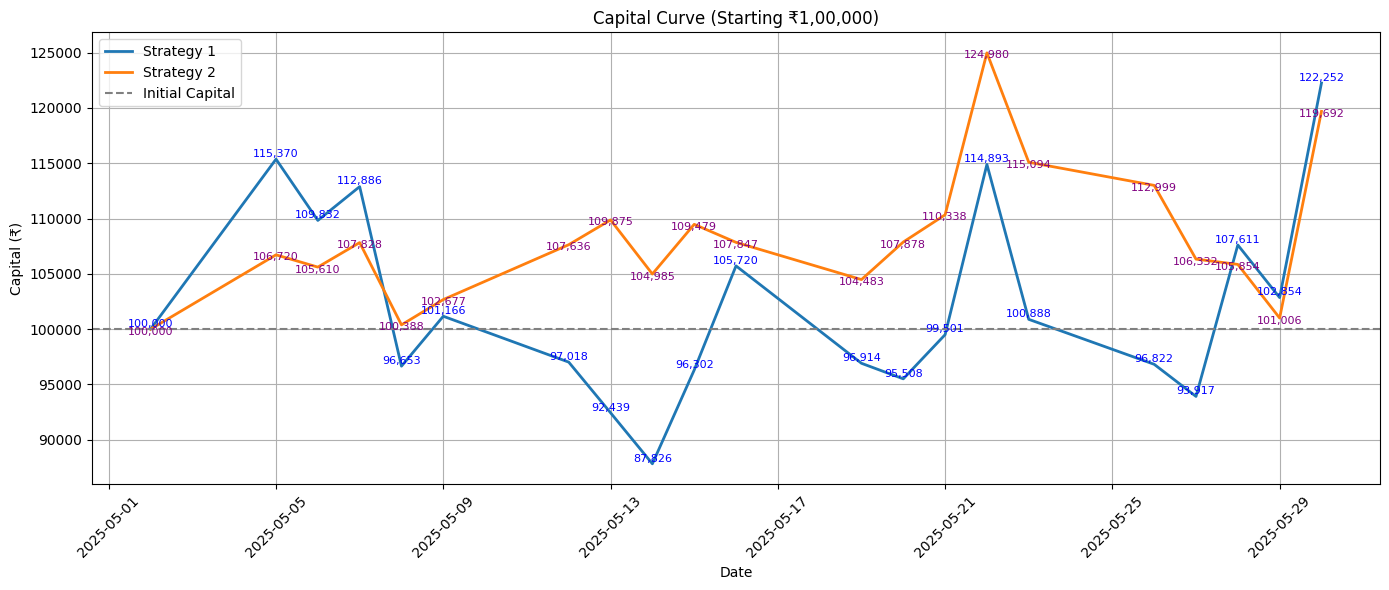

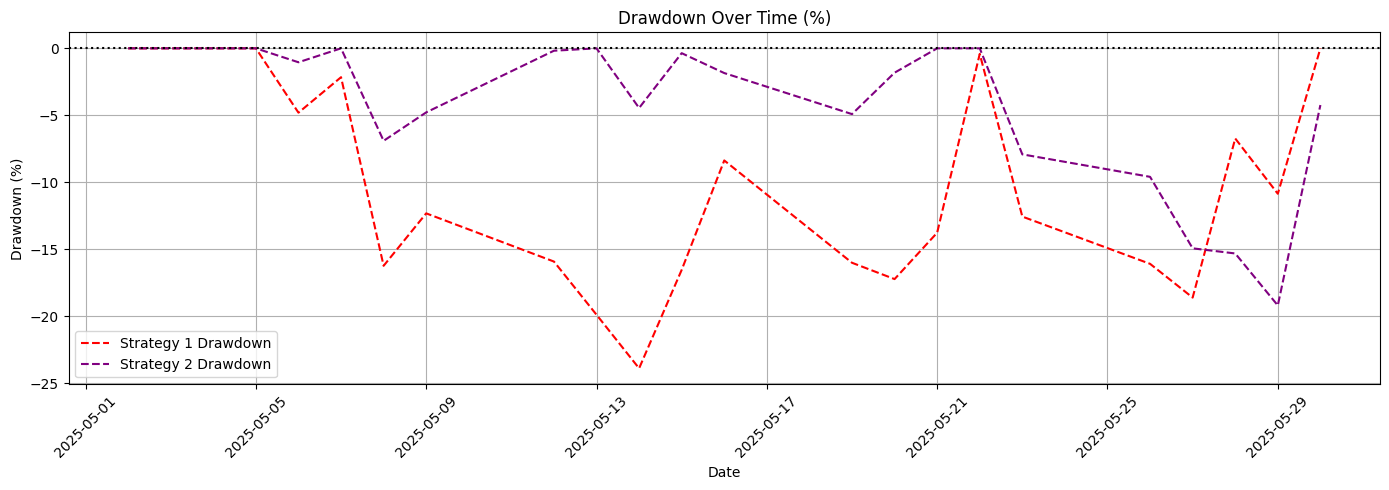

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== Sample Data ====
strategy1_data = {
    '2025-05-02': -3.93, '2025-05-05': 16.45, '2025-05-06': -4.56,
    '2025-05-07': 3.46, '2025-05-08': -13.78, '2025-05-09': 5.59,
    '2025-05-12': -2.82, '2025-05-13': -3.8, '2025-05-14': -4.07,
    '2025-05-15': 11.01, '2025-05-16': 11.58, '2025-05-19': -7.73,
    '2025-05-20': -1.05, '2025-05-21': 4.46, '2025-05-22': 16.07,
    '2025-05-23': -10.79, '2025-05-26': -3.11, '2025-05-27': -2.52,
    '2025-05-28': 15.58, '2025-05-29': -3.54, '2025-05-30': 20.62,
}

strategy1_trades = {
    '2025-05-02': 12, '2025-05-05': 27, '2025-05-06': 6,
    '2025-05-07': 17, '2025-05-08': 15, '2025-05-09': 23,
    '2025-05-12': 32, '2025-05-13': 23, '2025-05-14': 23,
    '2025-05-15': 34, '2025-05-16': 45, '2025-05-19': 15,
    '2025-05-20': 10, '2025-05-21': 7, '2025-05-22': 15,
    '2025-05-23': 35, '2025-05-26': 23, '2025-05-27': 12,
    '2025-05-28': 25, '2025-05-29': 22, '2025-05-30': 44,
}

strategy2_data = {
    '2025-05-02': -3.02, '2025-05-05': 7.16, '2025-05-06': -1.0,
    '2025-05-07': 2.46, '2025-05-08': -6.62, '2025-05-09': 2.84,
    '2025-05-12': 5.59, '2025-05-13': 2.52, '2025-05-14': -3.93,
    '2025-05-15': 5.16, '2025-05-16': -0.57, '2025-05-19': -3.0,
    '2025-05-20': 3.41, '2025-05-21': 2.36, '2025-05-22': 13.59,
    '2025-05-23': -7.35, '2025-05-26': -1.34, '2025-05-27': -5.62,
    '2025-05-28': 0.03, '2025-05-29': -4.14, '2025-05-30': 19.7,
}

strategy2_trades = {
    '2025-05-02': 6, '2025-05-05': 11, '2025-05-06': 1,
    '2025-05-07': 9, '2025-05-08': 7, '2025-05-09': 14,
    '2025-05-12': 19, '2025-05-13': 11, '2025-05-14': 13,
    '2025-05-15': 22, '2025-05-16': 23, '2025-05-19': 3,
    '2025-05-20': 4, '2025-05-21': 2, '2025-05-22': 8,
    '2025-05-23': 14, '2025-05-26': 12, '2025-05-27': 7,
    '2025-05-28': 12, '2025-05-29': 11, '2025-05-30': 30,
}

# ==== Capital Curve Function ====
def process_strategy(data_dict, trades_dict, cost_per_trade=40, initial_capital=100000):
    df = pd.DataFrame({
        'Return (%)': data_dict,
        'Trades': trades_dict
    })
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    df['Cost (₹)'] = df['Trades'] * cost_per_trade
    df['Net Return (%)'] = df['Return (%)'] - (df['Cost (₹)'] / initial_capital * 100)

    df['Capital'] = initial_capital
    for i in range(1, len(df)):
        prev_cap = df.iloc[i - 1]['Capital']
        net_ret = df.iloc[i]['Net Return (%)']
        df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)

    df['Peak'] = df['Capital'].cummax()
    df['Drawdown (₹)'] = df['Capital'] - df['Peak']
    df['Drawdown (%)'] = df['Drawdown (₹)'] / df['Peak'] * 100

    return df, df['Drawdown (%)'].min()

# ==== Process Both Strategies ====
df1, max_dd1 = process_strategy(strategy1_data, strategy1_trades)
df2, max_dd2 = process_strategy(strategy2_data, strategy2_trades)

# ==== Print Max Drawdown ====
print(f"\n📉 Strategy 1 Max Drawdown: {max_dd1:.2f}%")
print(f"📉 Strategy 2 Max Drawdown: {max_dd2:.2f}%")

# ==== Capital Curve Plot ====
plt.figure(figsize=(14, 6))
plt.plot(df1.index, df1['Capital'], label='Strategy 1', linewidth=2)
plt.plot(df2.index, df2['Capital'], label='Strategy 2', linewidth=2)
plt.axhline(100000, color='gray', linestyle='--', label='Initial Capital')

# Add labels
for i, date in enumerate(df1.index):
    plt.text(date, df1['Capital'].iloc[i] + 200, f"{df1['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='blue')

for i, date in enumerate(df2.index):
    plt.text(date, df2['Capital'].iloc[i] - 500, f"{df2['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='purple')

plt.title('Capital Curve (Starting ₹1,00,000)')
plt.ylabel('Capital (₹)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Drawdown Plot ====
plt.figure(figsize=(14, 5))
plt.plot(df1.index, df1['Drawdown (%)'], label='Strategy 1 Drawdown', linestyle='--', color='red')
plt.plot(df2.index, df2['Drawdown (%)'], label='Strategy 2 Drawdown', linestyle='--', color='purple')
plt.axhline(0, color='black', linestyle=':')
plt.title('Drawdown Over Time (%)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#enter only if the candle next to breakout candle is green and close of that is entry price

In [ ]:
#try more compact range for may 25

# USED 1.0% range here

import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2NQd2ZMZlVsN1hnaUtNZkZUekJzUUxaZTRtYkF1S2duQ1hhMGR1Mkp5QkNjcE1seDdUU1RmcVpXRlNEVVdQdDc1c1Q0V2dHd0R1OG13SWdONkFpRENtZTRJVUJnZVJJbGh6MVlDZ0YzcS0wTTV2ST0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MjI4MDIwMCwiaWF0IjoxNzUyMjM1MDM5LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTIyMzUwMzksInN1YiI6ImFjY2Vzc190b2tlbiJ9.iBbjbhrbYqHA2BC__1DI9WLG7XXN4Dbj2cLc7FohzF8"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Load Market Cap Data ===
market_cap_df = pd.read_csv('/content/stocks_above_1kcr.csv')
market_cap_dict = dict(zip(market_cap_df['SYMBOL'], market_cap_df['MARKET_CAP_CR']))

# === Inputs ===
dates_to_check = [
   "2025-05-19", "2025-05-20", "2025-05-21", "2025-05-22",
    "2025-05-23", "2025-05-26", "2025-05-27", "2025-05-28", "2025-05-29",
    "2025-05-30"
]
fyers_symbols = fyers_symbols_filtered  # Ensure this is defined before running

# === Parameters ===
window_size = 24
max_range_pct = 0.01
volume_multiplier = 5
entry_buffer_pct = 0.01
min_body_pct = 0.005
confirmation_breakout_pct = 0.015

# === Fetch 5-min Candle Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]

            # Reject breakout after 2:30 PM
            if breakout_candle['timestamp'].time() > pd.to_datetime("14:30").time():
                continue

            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]

                    # Reject if entry happens after 2:30 PM
                    if row['timestamp'].time() > pd.to_datetime("14:30").time():
                        break

                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99
                        remaining_candles = candles_after.iloc[j + 1:]
                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        symbol_key = symbol.split(':')[-1].split('-')[0]
                        market_cap = market_cap_dict.get(symbol_key, np.nan)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'market_cap_cr': round(market_cap, 2) if not pd.isna(market_cap) else np.nan,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
portfolio_value = 100000
all_trades = []

for date in dates_to_check:
    daily_trades = []
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            daily_trades.extend(trades)
        time.sleep(0)

    # Daily logs
    if daily_trades:
        daily_df = pd.DataFrame(daily_trades)
        all_trades.extend(daily_trades)

        pnls = daily_df['pnl_%'].values
        day_return = round(np.sum(pnls), 2)
        portfolio_value *= (1 + float(day_return) / 100)

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {len(pnls)}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[round(p, 2) for p in pnls]}")
        print("\n📋 Trade Log with Market Cap:")
        # print(daily_df[['date', 'symbol', 'market_cap_cr', 'trigger_time', 'entry_time', 'entry_price',
        #     'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))
    else:
        print(f"\n📅 {date} — ❌ No trades generated.")

# === Final Portfolio Summary ===
print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")

# === Save Entire Trade Log to CSV ===
if all_trades:
    all_trades_df = pd.DataFrame(all_trades)
    # all_trades_df.to_csv("all_trade_log.csv", index=False)
    print("✅ Saved all trades to all_trade_log.csv")
else:
    print("⚠️ No trades to save.")

⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-19
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-19
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-19
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-19

📅 2025-05-19 — ❌ No trades generated.
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-20
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-20
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-20
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-20

📅 2025-05-20 Summary:
   📈 Trades Taken: 3
   💰 Day's Return: 4.41%
   📋 Trades PnL: [np.float64(5.03), np.float64(0.38), np.float64(-1.0)]

📋 Trade Log with Market Cap:
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-21
⚠️ No candles for NSE:BELRISE-EQ on 2025-05-21
⚠️ No candles for NSE:THELEELA-EQ on 2025-05-21
⚠️ No candles for NSE:AEGISVOPAK-EQ on 2025-05-21

📅 2025-05-21 Summary:
   📈 Trades Taken: 1
   💰 Day's Return: 3.08%
   📋 Trades PnL: [np.float64(3.08)]

📋 Trade Log with Market Cap:
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-05-22
⚠️ No candles for NS

/tmp/ipython-input-8-1719480796.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '110919.087' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)
/tmp/ipython-input-8-1719480796.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '107160.00000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)



📉 Strategy 1 Max Drawdown: -7.18%
📉 Strategy 2 Max Drawdown: -17.28%


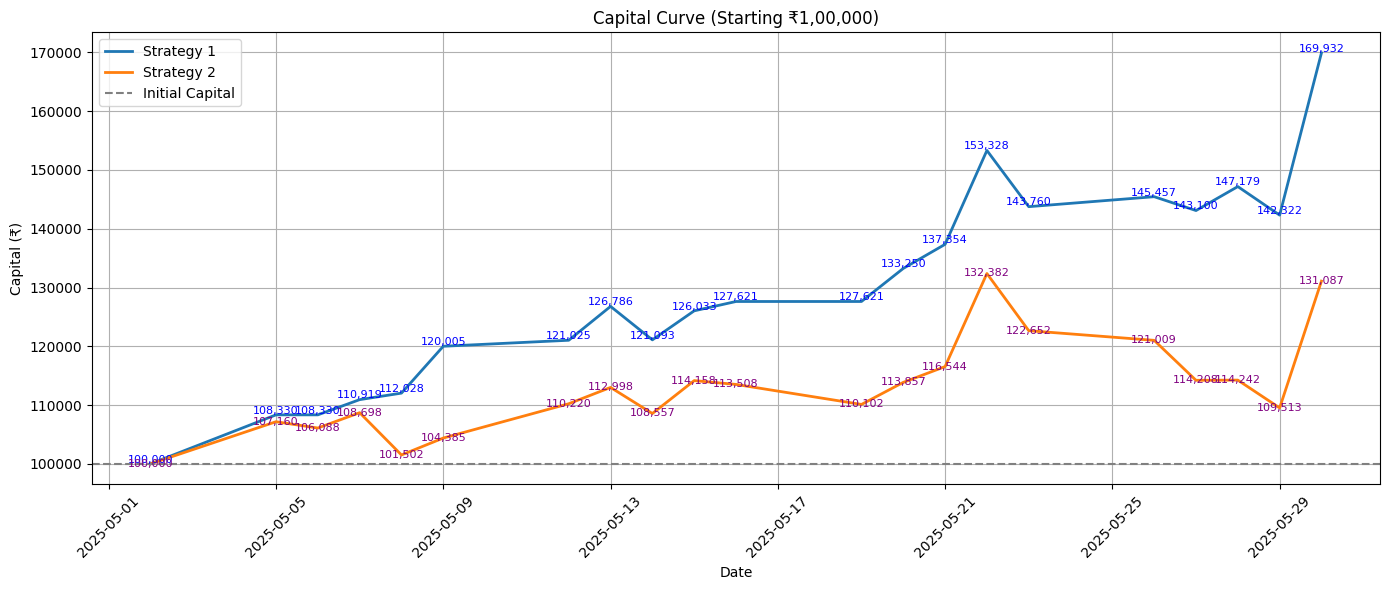

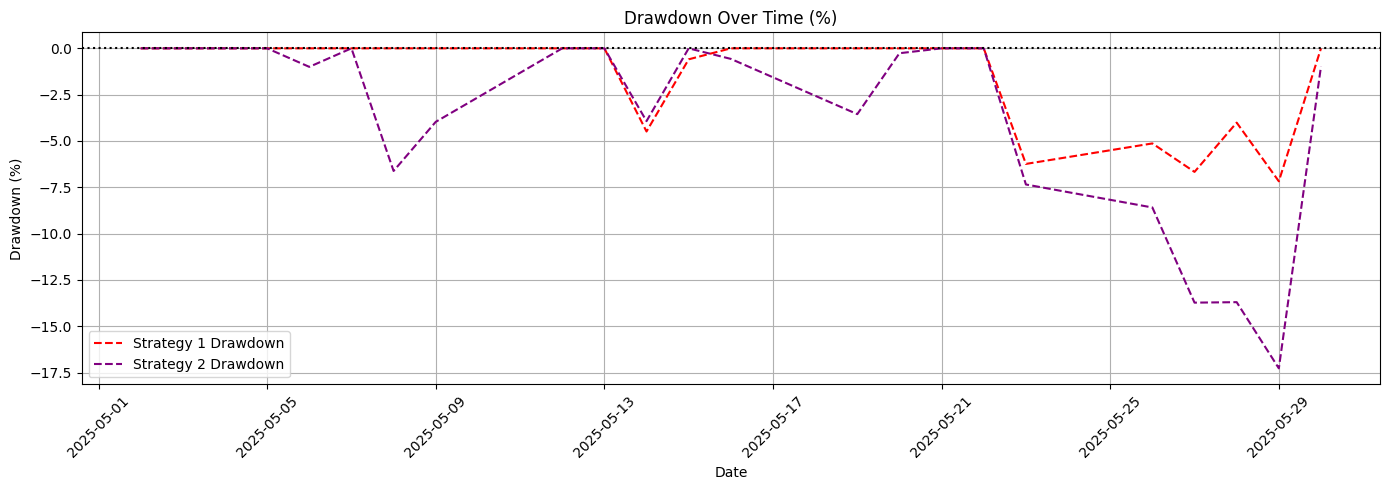

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== Sample Data ====
strategy3_data = {
    '2025-05-02': -1.71, '2025-05-05': 8.33, '2025-05-06': 0,
    '2025-05-07': 2.39, '2025-05-08': 1, '2025-05-09':7.12,
    '2025-05-12': 0.85, '2025-05-13': 4.76, '2025-05-14':-4.49,
    '2025-05-15': 4.08, '2025-05-16': 1.26, '2025-05-19': 0,
    '2025-05-20': 4.41, '2025-05-21': 3.08, '2025-05-22': 11.63,
    '2025-05-23': -6.24, '2025-05-26': 1.18, '2025-05-27': -1.62,
    '2025-05-28': 2.85, '2025-05-29': -3.3, '2025-05-30': 19.4
}

strategy3_trades = {
    '2025-05-02': 3, '2025-05-05': 9, '2025-05-06': 0,
    '2025-05-07': 4, '2025-05-08': -1, '2025-05-09':4,
    '2025-05-12': 6, '2025-05-13': 4, '2025-05-14': 7,
    '2025-05-15': 12, '2025-05-16': 12, '2025-05-19': 0,
    '2025-05-20': 3, '2025-05-21': 1, '2025-05-22': 4,
    '2025-05-23': 7, '2025-05-26': 7, '2025-05-27': 3,
    '2025-05-28': 5, '2025-05-29': 6, '2025-05-30': 15
}

strategy2_data = {
    '2025-05-02': -3.02, '2025-05-05': 7.16, '2025-05-06': -1.0,
    '2025-05-07': 2.46, '2025-05-08': -6.62, '2025-05-09': 2.84,
    '2025-05-12': 5.59, '2025-05-13': 2.52, '2025-05-14': -3.93,
    '2025-05-15': 5.16, '2025-05-16': -0.57, '2025-05-19': -3.0,
    '2025-05-20': 3.41, '2025-05-21': 2.36, '2025-05-22': 13.59,
    '2025-05-23': -7.35, '2025-05-26': -1.34, '2025-05-27': -5.62,
    '2025-05-28': 0.03, '2025-05-29': -4.14, '2025-05-30': 19.7,
}

strategy2_trades = {
    '2025-05-02': 6, '2025-05-05': 11, '2025-05-06': 1,
    '2025-05-07': 9, '2025-05-08': 7, '2025-05-09': 14,
    '2025-05-12': 19, '2025-05-13': 11, '2025-05-14': 13,
    '2025-05-15': 22, '2025-05-16': 23, '2025-05-19': 3,
    '2025-05-20': 4, '2025-05-21': 2, '2025-05-22': 8,
    '2025-05-23': 14, '2025-05-26': 12, '2025-05-27': 7,
    '2025-05-28': 12, '2025-05-29': 11, '2025-05-30': 30,
}

# ==== Capital Curve Function ====
def process_strategy(data_dict, trades_dict, cost_per_trade=0, initial_capital=100000):
    df = pd.DataFrame({
        'Return (%)': data_dict,
        'Trades': trades_dict
    })
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    df['Cost (₹)'] = df['Trades'] * cost_per_trade
    df['Net Return (%)'] = df['Return (%)'] - (df['Cost (₹)'] / initial_capital * 100)

    df['Capital'] = initial_capital
    for i in range(1, len(df)):
        prev_cap = df.iloc[i - 1]['Capital']
        net_ret = df.iloc[i]['Net Return (%)']
        df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)

    df['Peak'] = df['Capital'].cummax()
    df['Drawdown (₹)'] = df['Capital'] - df['Peak']
    df['Drawdown (%)'] = df['Drawdown (₹)'] / df['Peak'] * 100

    return df, df['Drawdown (%)'].min()

# ==== Process Both Strategies ====
df1, max_dd1 = process_strategy(strategy3_data, strategy3_trades)
df2, max_dd2 = process_strategy(strategy2_data, strategy2_trades)

# ==== Print Max Drawdown ====
print(f"\n📉 Strategy 1 Max Drawdown: {max_dd1:.2f}%")
print(f"📉 Strategy 2 Max Drawdown: {max_dd2:.2f}%")

# ==== Capital Curve Plot ====
plt.figure(figsize=(14, 6))
plt.plot(df1.index, df1['Capital'], label='Strategy 1', linewidth=2)
plt.plot(df2.index, df2['Capital'], label='Strategy 2', linewidth=2)
plt.axhline(100000, color='gray', linestyle='--', label='Initial Capital')

# Add labels
for i, date in enumerate(df1.index):
    plt.text(date, df1['Capital'].iloc[i] + 200, f"{df1['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='blue')

for i, date in enumerate(df2.index):
    plt.text(date, df2['Capital'].iloc[i] - 500, f"{df2['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='purple')

plt.title('Capital Curve (Starting ₹1,00,000)')
plt.ylabel('Capital (₹)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Drawdown Plot ====
plt.figure(figsize=(14, 5))
plt.plot(df1.index, df1['Drawdown (%)'], label='Strategy 1 Drawdown', linestyle='--', color='red')
plt.plot(df2.index, df2['Drawdown (%)'], label='Strategy 2 Drawdown', linestyle='--', color='purple')
plt.axhline(0, color='black', linestyle=':')
plt.title('Drawdown Over Time (%)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# trying compact for june 25


import pandas as pd
import numpy as np
from fyers_apiv3 import fyersModel
import time

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2NTWFhsTzJuU250czdNVXJScmRXc2c3LUZGSHVjay1HV19jbWI2MERrc2xraEdmNUVNaEZTX2c1WlhtX2ZvYXRodmJ6dEcweFAxX3A4QnZqYmJ6aF9RalI0RllKbmpvcGZKX0o3RXU0eldKQlptbz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MjI4MDIwMCwiaWF0IjoxNzUyMjQ1NzE5LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTIyNDU3MTksInN1YiI6ImFjY2Vzc190b2tlbiJ9.ur3OmGO0qJjSnyydc1ptPxxKabDzyGCZrJvhn6PUeDM"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Load Market Cap Data ===
market_cap_df = pd.read_csv('/content/stocks_above_1kcr.csv')
market_cap_dict = dict(zip(market_cap_df['SYMBOL'], market_cap_df['MARKET_CAP_CR']))

# === Inputs ===

dates_to_check = ["2025-06-02", "2025-06-03", "2025-06-04", "2025-06-05",
                 "2025-06-06", "2025-06-09","2025-06-10", "2025-06-11", "2025-06-12", "2025-06-13",
                 "2025-06-16", "2025-06-17","2025-06-18","2025-06-19","2025-06-20","2025-06-23","2025-06-24","2025-06-25","2025-06-26","2025-06-27","2025-06-30", "2025-07-01", "2025-07-02", "2025-07-03","2025-07-04","2025-07-07","2025-07-08","2025-07-09","2025-07-10"]
fyers_symbols = fyers_symbols_filtered  # Ensure this is defined before running

# === Parameters ===
window_size = 24
max_range_pct = 0.01
volume_multiplier = 5
entry_buffer_pct = 0.01
min_body_pct = 0.005
confirmation_breakout_pct = 0.015

# === Fetch 5-min Candle Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            print(f"⚠️ No candles for {symbol} on {date}")
            return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching {symbol} on {date}: {e}")
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]

            # Reject breakout after 2:30 PM
            if breakout_candle['timestamp'].time() > pd.to_datetime("14:30").time():
                continue

            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]

                    # Reject if entry happens after 2:30 PM
                    if row['timestamp'].time() > pd.to_datetime("14:30").time():
                        break

                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99
                        remaining_candles = candles_after.iloc[j + 1:]
                        if len(remaining_candles) == 0:
                            break

                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)

                        symbol_key = symbol.split(':')[-1].split('-')[0]
                        market_cap = market_cap_dict.get(symbol_key, np.nan)

                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'market_cap_cr': round(market_cap, 2) if not pd.isna(market_cap) else np.nan,
                            'trigger_time': breakout_candle['timestamp'],
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades  # One trade per symbol per day
    return trades

# === Run Strategy ===
portfolio_value = 100000
all_trades = []

for date in dates_to_check:
    daily_trades = []
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            daily_trades.extend(trades)
        time.sleep(0)

    # Daily logs
    if daily_trades:
        daily_df = pd.DataFrame(daily_trades)
        all_trades.extend(daily_trades)

        pnls = daily_df['pnl_%'].values
        day_return = round(np.sum(pnls), 2)
        portfolio_value *= (1 + float(day_return) / 100)

        print(f"\n📅 {date} Summary:")
        print(f"   📈 Trades Taken: {len(pnls)}")
        print(f"   💰 Day's Return: {day_return}%")
        print(f"   📋 Trades PnL: {[round(p, 2) for p in pnls]}")
        print("\n📋 Trade Log with Market Cap:")
        # print(daily_df[['date', 'symbol', 'market_cap_cr', 'trigger_time', 'entry_time', 'entry_price',
        #     'exit_time', 'exit_price', 'pnl_%', 'reason']].to_string(index=False))
    else:
        print(f"\n📅 {date} — ❌ No trades generated.")

# === Final Portfolio Summary ===
print(f"\n💼 Final Portfolio Value: ₹{round(portfolio_value, 2)}")

# === Save Entire Trade Log to CSV ===
if all_trades:
    all_trades_df = pd.DataFrame(all_trades)
    # all_trades_df.to_csv("all_trade_log.csv", index=False)
    print("✅ Saved all trades to all_trade_log.csv")
else:
    print("⚠️ No trades to save.")

⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-06-02

📅 2025-06-02 Summary:
   📈 Trades Taken: 7
   💰 Day's Return: -0.32%
   📋 Trades PnL: [np.float64(-1.0), np.float64(-0.08), np.float64(-1.0), np.float64(1.75), np.float64(-0.43), np.float64(0.3), np.float64(0.14)]

📋 Trade Log with Market Cap:
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-06-03

📅 2025-06-03 Summary:
   📈 Trades Taken: 1
   💰 Day's Return: -1.0%
   📋 Trades PnL: [np.float64(-1.0)]

📋 Trade Log with Market Cap:
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-06-04

📅 2025-06-04 Summary:
   📈 Trades Taken: 9
   💰 Day's Return: -3.29%
   📋 Trades PnL: [np.float64(-1.0), np.float64(-1.0), np.float64(0.18), np.float64(-1.0), np.float64(1.94), np.float64(-1.0), np.float64(-1.0), np.float64(-0.43), np.float64(0.02)]

📋 Trade Log with Market Cap:
⚠️ No candles for NSE:OSWALPUMPS-EQ on 2025-06-05

📅 2025-06-05 Summary:
   📈 Trades Taken: 11
   💰 Day's Return: 1.37%
   📋 Trades PnL: [np.float64(-0.91), np.float64(0.13), np.float64(0.9

/tmp/ipython-input-23-1533483832.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '103791.65712' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)
/tmp/ipython-input-23-1533483832.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '101973.3344' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)



📉 Strategy 1 Max Drawdown: -3.95%
📉 Strategy 2 Max Drawdown: -9.27%


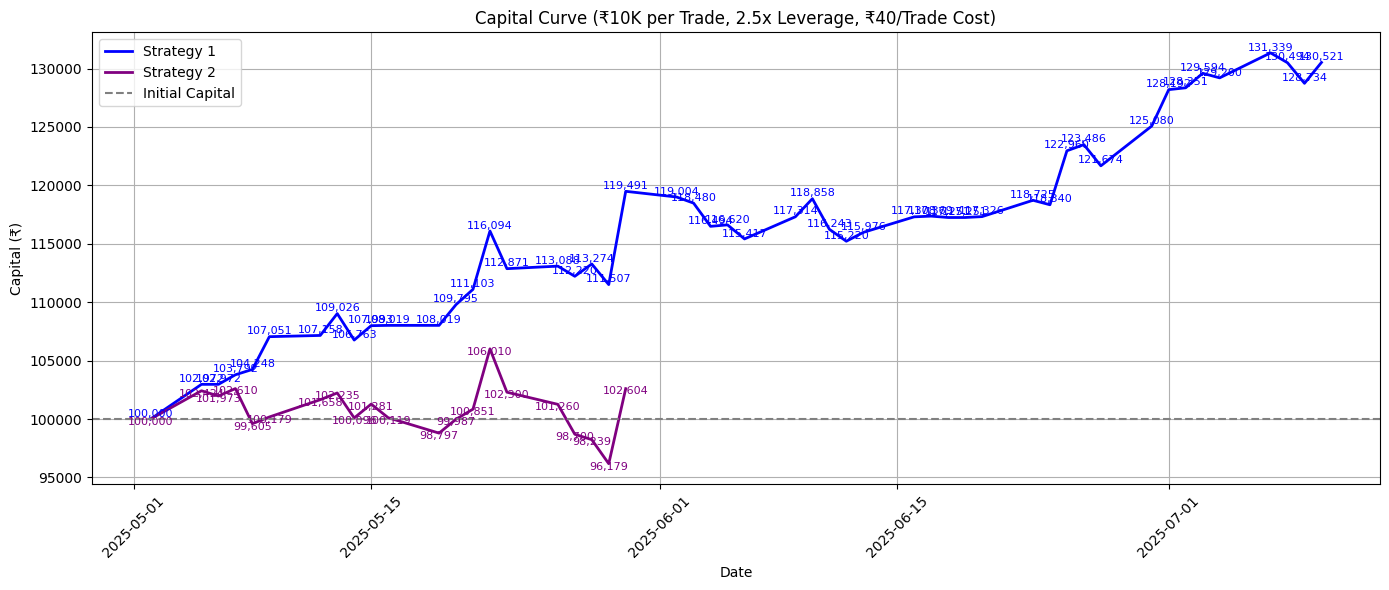

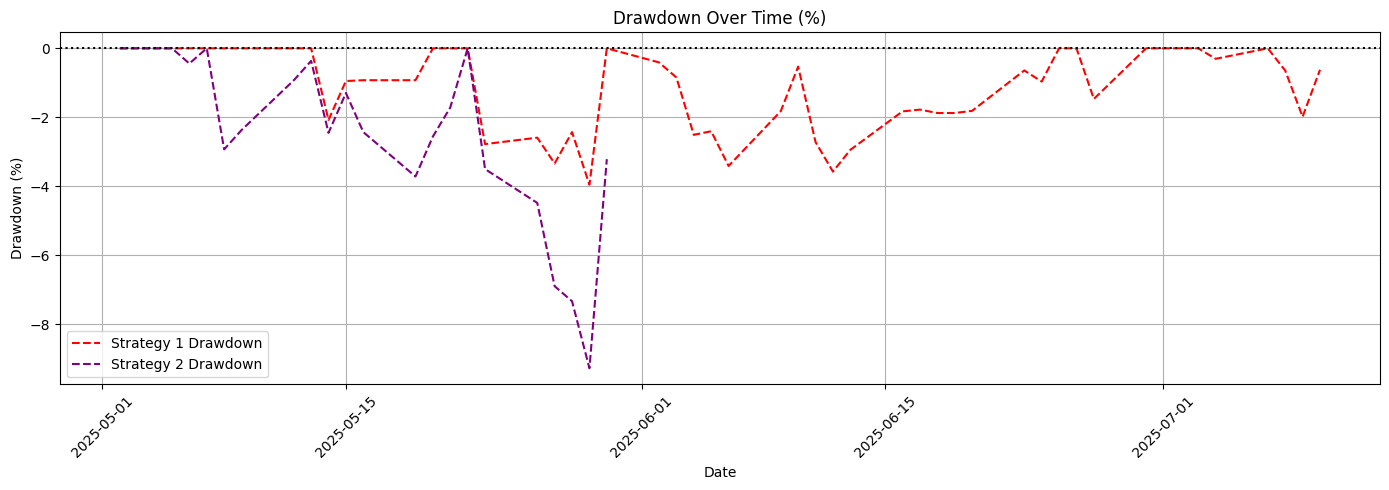

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== Sample Data ====
strategy3_data = {
    '2025-05-02': -1.71, '2025-05-05': 8.33, '2025-05-06': 0,
    '2025-05-07': 2.39, '2025-05-08': 1, '2025-05-09':7.12,
    '2025-05-12': 0.85, '2025-05-13': 4.76, '2025-05-14':-4.49,
    '2025-05-15': 4.08, '2025-05-16': 1.26, '2025-05-19': 0,
    '2025-05-20': 4.41, '2025-05-21': 3.08, '2025-05-22': 11.63,
    '2025-05-23': -6.24, '2025-05-26': 1.18, '2025-05-27': -1.62,
    '2025-05-28': 2.85, '2025-05-29': -3.3, '2025-05-30': 19.4,'2025-06-02':-0.32, '2025-06-03':-1, '2025-06-04':-3.29, '2025-06-05':1.37,
                 "2025-06-06":-1.78, "2025-06-09":5.11,"2025-06-10":3.99, "2025-06-11":-5, "2025-06-12":-2, "2025-06-13":1.74,
                 "2025-06-16":3.47, "2025-06-17":0.23,"2025-06-18":-0.15,"2025-06-19":0,"2025-06-20":0.36,"2025-06-23":3.78,"2025-06-24":-0.61,"2025-06-25":10.36,"2025-06-26":1.47,"2025-06-27":-3.07,"2025-06-30":7.4, "2025-07-01":6.82, "2025-07-02":1.01, "2025-07-03":2.72,"2025-07-04":-0.56,"2025-07-07":4.44,"2025-07-08":-1.41,"2025-07-09":-2.77,"2025-07-10":3.67
}

strategy3_trades = {
    '2025-05-02': 3, '2025-05-05': 9, '2025-05-06': 0,
    '2025-05-07': 4, '2025-05-08': -1, '2025-05-09':4,
    '2025-05-12': 6, '2025-05-13': 4, '2025-05-14': 7,
    '2025-05-15': 12, '2025-05-16': 12, '2025-05-19': 0,
    '2025-05-20': 3, '2025-05-21': 1, '2025-05-22': 4,
    '2025-05-23': 7, '2025-05-26': 7, '2025-05-27': 3,
    '2025-05-28': 5, '2025-05-29': 6, '2025-05-30': 15,
    "2025-06-02":7, "2025-06-03":1, "2025-06-04":9, "2025-06-05":11,
                 "2025-06-06":8, "2025-06-09":10,"2025-06-10":7, "2025-06-11":5, "2025-06-12":2, "2025-06-13":1,
                 "2025-06-16":6, "2025-06-17":1,"2025-06-18":1,"2025-06-19":0,"2025-06-20":2,"2025-06-23":8,"2025-06-24":2,"2025-06-25":6,"2025-06-26":4,"2025-06-27":6,"2025-06-30":4, "2025-07-01":6, "2025-07-02":7, "2025-07-03":3,"2025-07-04":2,"2025-07-07":3,"2025-07-08":2,"2025-07-09":6,"2025-07-10":2
}

strategy2_data = {
    '2025-05-02': -3.02, '2025-05-05': 7.16, '2025-05-06': -1.0,
    '2025-05-07': 2.46, '2025-05-08': -6.62, '2025-05-09': 2.84,
    '2025-05-12': 5.59, '2025-05-13': 2.52, '2025-05-14': -3.93,
    '2025-05-15': 5.16, '2025-05-16': -0.57, '2025-05-19': -3.0,
    '2025-05-20': 3.41, '2025-05-21': 2.36, '2025-05-22': 13.59,
    '2025-05-23': -7.35, '2025-05-26': -1.34, '2025-05-27': -5.62,
    '2025-05-28': 0.03, '2025-05-29': -4.14, '2025-05-30': 19.7,
}

strategy2_trades = {
    '2025-05-02': 6, '2025-05-05': 11, '2025-05-06': 1,
    '2025-05-07': 9, '2025-05-08': 7, '2025-05-09': 14,
    '2025-05-12': 19, '2025-05-13': 11, '2025-05-14': 13,
    '2025-05-15': 22, '2025-05-16': 23, '2025-05-19': 3,
    '2025-05-20': 4, '2025-05-21': 2, '2025-05-22': 8,
    '2025-05-23': 14, '2025-05-26': 12, '2025-05-27': 7,
    '2025-05-28': 12, '2025-05-29': 11, '2025-05-30': 30,
}

def process_strategy(data_dict, trades_dict, cost_per_trade=40, initial_capital=100000, leverage=4, trades_per_day=10):
    df = pd.DataFrame({
        'Return (%)': data_dict,
        'Trades': trades_dict
    })
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    # Apply adjustment factor: only 1/10 capital per stock with 2.5x leverage → effective weight = 0.25
    df['Adjusted Return (%)'] = df['Return (%)'] * (1 / trades_per_day) * leverage

    # Cost calculation
    df['Cost (₹)'] = df['Trades'] * cost_per_trade
    df['Net Return (%)'] = df['Adjusted Return (%)'] - (df['Cost (₹)'] / initial_capital * 100)

    # Capital curve calculation
    df['Capital'] = initial_capital
    for i in range(1, len(df)):
        prev_cap = df.iloc[i - 1]['Capital']
        net_ret = df.iloc[i]['Net Return (%)']
        df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)

    # Drawdown
    df['Peak'] = df['Capital'].cummax()
    df['Drawdown (₹)'] = df['Capital'] - df['Peak']
    df['Drawdown (%)'] = df['Drawdown (₹)'] / df['Peak'] * 100

    return df, df['Drawdown (%)'].min()

# ==== Run for both strategies ====
df1, max_dd1 = process_strategy(strategy3_data, strategy3_trades)
df2, max_dd2 = process_strategy(strategy2_data, strategy2_trades)

# ==== Print Max Drawdowns ====
print(f"\n📉 Strategy 1 Max Drawdown: {max_dd1:.2f}%")
print(f"📉 Strategy 2 Max Drawdown: {max_dd2:.2f}%")

# ==== Plot Capital Curves ====
plt.figure(figsize=(14, 6))
plt.plot(df1.index, df1['Capital'], label='Strategy 1', linewidth=2, color='blue')
plt.plot(df2.index, df2['Capital'], label='Strategy 2', linewidth=2, color='purple')
plt.axhline(100000, color='gray', linestyle='--', label='Initial Capital')

# Label capital values
for i, date in enumerate(df1.index):
    plt.text(date, df1['Capital'].iloc[i] + 200, f"{df1['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='blue')

for i, date in enumerate(df2.index):
    plt.text(date, df2['Capital'].iloc[i] - 500, f"{df2['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='purple')

plt.title('Capital Curve (₹10K per Trade, 2.5x Leverage, ₹40/Trade Cost)')
plt.ylabel('Capital (₹)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Plot Drawdowns ====
plt.figure(figsize=(14, 5))
plt.plot(df1.index, df1['Drawdown (%)'], label='Strategy 1 Drawdown', linestyle='--', color='red')
plt.plot(df2.index, df2['Drawdown (%)'], label='Strategy 2 Drawdown', linestyle='--', color='purple')
plt.axhline(0, color='black', linestyle=':')
plt.title('Drawdown Over Time (%)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#with market cap??

# Backtesting for Jan-april

In [ ]:
import pandas as pd
df = pd.read_csv('/content/stocks_for_date.csv')
df['Date'] = pd.to_datetime(df['Date'])
date_list = df['Date'].dt.strftime('%Y-%m-%d').tolist()
print(date_list)


['2025-01-01', '2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-13', '2025-01-14', '2025-01-15', '2025-01-16', '2025-01-17', '2025-01-20', '2025-01-21', '2025-01-22', '2025-01-23', '2025-01-24', '2025-01-27', '2025-01-28', '2025-01-29', '2025-01-30', '2025-01-31', '2025-02-01', '2025-02-03', '2025-02-04', '2025-02-05', '2025-02-06', '2025-02-07', '2025-02-10', '2025-02-11', '2025-02-12', '2025-02-13', '2025-02-14', '2025-02-17', '2025-02-18', '2025-02-19', '2025-02-20', '2025-02-21', '2025-02-24', '2025-02-25', '2025-02-27', '2025-02-28', '2025-03-03', '2025-03-04', '2025-03-05', '2025-03-06', '2025-03-07', '2025-03-10', '2025-03-11', '2025-03-12', '2025-03-13', '2025-03-17', '2025-03-18', '2025-03-19', '2025-03-20', '2025-03-21', '2025-03-24', '2025-03-25', '2025-03-26', '2025-03-27', '2025-03-28', '2025-04-01', '2025-04-02', '2025-04-03', '2025-04-04', '2025-04-07', '2025-04-08', '2025-04-09', '2025-04-11', '2025-04-15', '2025

In [ ]:
date_list=date_list[43:]
date_list

['2025-03-03',
 '2025-03-04',
 '2025-03-05',
 '2025-03-06',
 '2025-03-07',
 '2025-03-10',
 '2025-03-11',
 '2025-03-12',
 '2025-03-13',
 '2025-03-17',
 '2025-03-18',
 '2025-03-19',
 '2025-03-20',
 '2025-03-21',
 '2025-03-24',
 '2025-03-25',
 '2025-03-26',
 '2025-03-27',
 '2025-03-28',
 '2025-04-01',
 '2025-04-02',
 '2025-04-03',
 '2025-04-04',
 '2025-04-07',
 '2025-04-08',
 '2025-04-09',
 '2025-04-11',
 '2025-04-15',
 '2025-04-16',
 '2025-04-17',
 '2025-04-21',
 '2025-04-22',
 '2025-04-23',
 '2025-04-24',
 '2025-04-25',
 '2025-04-28',
 '2025-04-29',
 '2025-04-30']

In [15]:
# extracting dates from downloaded csv
import pandas as pd
df = pd.read_csv("/content/may_to_aug.csv", header=0)
first_col = df.iloc[:, 0]
converted_dates = pd.to_datetime(first_col, format='%d-%b-%Y').dt.strftime('%Y-%m-%d').tolist()
print(converted_dates)

['2024-05-02', '2024-05-03', '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05', '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11', '2024-07-12', '2024-07-15', '2024-07-16', '2024-07-18', '2024-07-19', '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02', '2024-08-05', '2024-08-06', '2024-08-07', '2024-08-08', '2024-08-09', '2024-08-12', '2024

In [16]:
converted_dates=converted_dates[-21:]
converted_dates

['2024-08-01',
 '2024-08-02',
 '2024-08-05',
 '2024-08-06',
 '2024-08-07',
 '2024-08-08',
 '2024-08-09',
 '2024-08-12',
 '2024-08-13',
 '2024-08-14',
 '2024-08-16',
 '2024-08-19',
 '2024-08-20',
 '2024-08-21',
 '2024-08-22',
 '2024-08-23',
 '2024-08-26',
 '2024-08-27',
 '2024-08-28',
 '2024-08-29',
 '2024-08-30']

In [29]:
# 1% range and 0.75% candle
#***************************************************************************************************************************
import pandas as pd
import numpy as np
import time
from fyers_apiv3 import fyersModel
from collections import defaultdict

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2R3MnpXYU5jV0FFVEVVa09pMEd2TVRkcWxVcEFYOW9SQkdXQ3ZLV0Z4Z3FsMVVpekx5T2JicnMtLXFDMVNadnFiOGYzQ3d0WDV5eVhHd3pCdTRJb3BoR2k2bzc2TlM5NXgzbExSYjdxbWxOcE1fbz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MjcxMjIwMCwiaWF0IjoxNzUyNjMyNzU1LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTI2MzI3NTUsInN1YiI6ImFjY2Vzc190b2tlbiJ9.aob4QJtXf40RvMwUb53cRWCJNGWKFymKrIXa8SszzIQ"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Load Market Cap Data ===
market_cap_df = pd.read_csv('/content/stocks_above_1kcr.csv')
market_cap_dict = dict(zip(market_cap_df['SYMBOL'], market_cap_df['MARKET_CAP_CR']))

# === Parameters ===
window_size = 24
max_range_pct = 0.01
volume_multiplier = 5
entry_buffer_pct = 0.01
min_body_pct = 0.0075
confirmation_breakout_pct = 0.01

# === Fetch 5-min Candle Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            return pd.DataFrame()
    except Exception as e:
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]

            if breakout_candle['timestamp'].time() > pd.to_datetime("14:30").time():
                continue

            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            if upper_wick > 0.4 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]
                    if row['timestamp'].time() > pd.to_datetime("14:30").time():
                        break
                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99
                        remaining_candles = candles_after.iloc[j + 1:]
                        if len(remaining_candles) == 0:
                            break
                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)
                        symbol_key = symbol.split(':')[-1].split('-')[0]
                        market_cap = market_cap_dict.get(symbol_key, np.nan)
                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades
    return trades

# === Inputs ===
dates_to_check = converted_dates

#dates_to_check = ["2025-07-01", "2025-07-02", "2025-07-03","2025-07-04","2025-07-07","2025-07-08","2025-07-09","2025-07-10","2025-07-11","2025-07-14"]

fyers_symbols = fyers_symbols_filtered  # List of symbols

# === Portfolio Summary Setup ===
portfolio_value = 100000
date_to_returns = {}
date_to_trades = {}

monthly_returns = defaultdict(float)
monthly_trades = defaultdict(int)

# === Run Strategy ===
for date in dates_to_check:
    daily_trades = []
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            daily_trades.extend(trades)
        time.sleep(0)  # Avoid rate limiting

    if daily_trades:
        daily_df = pd.DataFrame(daily_trades)
        pnls = daily_df['pnl_%'].values
        day_return = round(np.sum(pnls), 2)
        num_trades = len(pnls)
    else:
        day_return = 0
        num_trades = 0

    # Portfolio value update
    portfolio_value *= (1 + day_return / 100)

    # Save per-day
    date_to_returns[date] = day_return
    date_to_trades[date] = num_trades

    # Monthly aggregation
    month_key = pd.to_datetime(date).strftime("%Y-%m")
    monthly_returns[month_key] += day_return
    monthly_trades[month_key] += num_trades

    # One-line summary per day
    print(f"📅 {date}, 🧾 Trades: {num_trades}, 💰 Return: {day_return:.2f}%")

# === Monthly Summary ===
print("\n📊 Monthly Summary:")
for month in sorted(monthly_returns):
    print(f"🗓️ {month} — Trades: {monthly_trades[month]}, Return: {monthly_returns[month]:.2f}%")

# === Overall Summary ===
print("\n💼 Total Summary:")
print(f"🧮 Total Trades: {sum(monthly_trades.values())}")
print(f"💵 Total Return: {sum(monthly_returns.values()):.2f}%")
print(f"📈 Final Portfolio Value: ₹{round(portfolio_value, 2)}")

📅 2024-08-01, 🧾 Trades: 1, 💰 Return: -1.00%
📅 2024-08-02, 🧾 Trades: 6, 💰 Return: 1.77%
📅 2024-08-05, 🧾 Trades: 0, 💰 Return: 0.00%
📅 2024-08-06, 🧾 Trades: 1, 💰 Return: -1.00%
📅 2024-08-07, 🧾 Trades: 8, 💰 Return: 1.23%
📅 2024-08-08, 🧾 Trades: 4, 💰 Return: 1.30%
📅 2024-08-09, 🧾 Trades: 4, 💰 Return: -3.30%
📅 2024-08-12, 🧾 Trades: 5, 💰 Return: 4.48%
📅 2024-08-13, 🧾 Trades: 1, 💰 Return: -1.00%
📅 2024-08-14, 🧾 Trades: 5, 💰 Return: 0.02%
📅 2024-08-16, 🧾 Trades: 12, 💰 Return: 10.07%
📅 2024-08-19, 🧾 Trades: 3, 💰 Return: 1.48%
📅 2024-08-20, 🧾 Trades: 9, 💰 Return: 7.84%
📅 2024-08-21, 🧾 Trades: 8, 💰 Return: 8.85%
📅 2024-08-22, 🧾 Trades: 3, 💰 Return: -0.40%
📅 2024-08-23, 🧾 Trades: 4, 💰 Return: 10.05%
📅 2024-08-26, 🧾 Trades: 5, 💰 Return: 5.66%
📅 2024-08-27, 🧾 Trades: 5, 💰 Return: 8.38%
📅 2024-08-28, 🧾 Trades: 3, 💰 Return: -1.85%
📅 2024-08-29, 🧾 Trades: 2, 💰 Return: -2.00%
📅 2024-08-30, 🧾 Trades: 10, 💰 Return: 2.86%

📊 Monthly Summary:
🗓️ 2024-08 — Trades: 99, Return: 53.44%

💼 Total Summary:
🧮 Total 

In [30]:
# 1% range and entry 1.5% and body 0.5%
'''
import pandas as pd
import numpy as np
import time
from fyers_apiv3 import fyersModel
from collections import defaultdict

# === Fyers Setup ===
client_id = "6HK249XFBQ-100"
access_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2RIWDNybjVmVHlndEoyTHN0aGlvNERseHZfY2NLVm1rNmhUYU9vd0Z2WVQtek1vWlNIR3pINGpKWDUtTDY0VkdqU3h4cGdmR2JDWW9jdzhCdnlMb3F3U3pqVzd2TWx6UVhTLWg4NjMxUGhrOGlLdz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MjUzOTQwMCwiaWF0IjoxNzUyNDYyODM5LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTI0NjI4MzksInN1YiI6ImFjY2Vzc190b2tlbiJ9.MyLrQmtmYJvVkQ2ypVZ4OVxV95wXWdNKzGL58eDhc6k"
fyers = fyersModel.FyersModel(client_id=client_id, token=access_token)

# === Load Market Cap Data ===
market_cap_df = pd.read_csv('/content/stocks_above_1kcr.csv')
market_cap_dict = dict(zip(market_cap_df['SYMBOL'], market_cap_df['MARKET_CAP_CR']))

# === Parameters ===
window_size = 24
max_range_pct = 0.01
volume_multiplier = 5
entry_buffer_pct = 0.01
min_body_pct = 0.005
confirmation_breakout_pct = 0.015

# === Fetch 5-min Candle Data ===
def fetch_5min_data(symbol, date):
    try:
        res = fyers.history({
            "symbol": symbol,
            "resolution": "5",
            "date_format": "1",
            "range_from": date,
            "range_to": date,
            "cont_flag": "0"
        })
        if 'candles' in res and len(res['candles']) > 0:
            df = pd.DataFrame(res['candles'], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert('Asia/Kolkata')
            return df
        else:
            return pd.DataFrame()
    except Exception as e:
        return pd.DataFrame()

# === Simulate Exit ===
def simulate_exit(entry_price, sl, candles_after_entry):
    for _, row in candles_after_entry.iterrows():
        if row['low'] <= sl:
            return row['timestamp'], sl, ((sl - entry_price) / entry_price) * 100, 'SL Hit'
    final_price = candles_after_entry.iloc[-1]['close']
    return candles_after_entry.iloc[-1]['timestamp'], final_price, ((final_price - entry_price) / entry_price) * 100, 'End of Day Exit'

# === Strategy ===
def dynamic_range_breakout(df, symbol, date):
    trades = []
    if df.empty or len(df) < window_size + 10:
        return trades

    for i in range(len(df) - window_size - 6):
        range_df = df.iloc[i:i + window_size]
        r_high = range_df['high'].max()
        r_low = range_df['low'].min()
        r_width = (r_high - r_low) / r_low
        mean_volume = range_df['volume'].mean()

        if r_width < max_range_pct:
            breakout_candle = df.iloc[i + window_size]

            if breakout_candle['timestamp'].time() > pd.to_datetime("14:30").time():
                continue

            body = breakout_candle['close'] - breakout_candle['open']
            upper_wick = breakout_candle['high'] - breakout_candle['close']
            body_pct = body / breakout_candle['open']

            if upper_wick > 0.5 * abs(body):
                continue

            if (
                breakout_candle['close'] > breakout_candle['open'] and
                breakout_candle['high'] > r_high and
                body_pct >= min_body_pct and
                breakout_candle['volume'] > volume_multiplier * mean_volume
            ):
                target_entry_price = r_high * (1 + confirmation_breakout_pct)
                candles_after = df.iloc[i + window_size + 1:]

                for j in range(len(candles_after)):
                    row = candles_after.iloc[j]
                    if row['timestamp'].time() > pd.to_datetime("14:30").time():
                        break
                    if row['high'] >= target_entry_price:
                        entry_price = target_entry_price
                        sl = entry_price * 0.99
                        remaining_candles = candles_after.iloc[j + 1:]
                        if len(remaining_candles) == 0:
                            break
                        exit_time, exit_price, pnl_pct, reason = simulate_exit(entry_price, sl, remaining_candles)
                        symbol_key = symbol.split(':')[-1].split('-')[0]
                        market_cap = market_cap_dict.get(symbol_key, np.nan)
                        trades.append({
                            'date': date,
                            'symbol': symbol,
                            'entry_time': row['timestamp'],
                            'entry_price': round(entry_price, 2),
                            'exit_time': exit_time,
                            'exit_price': round(exit_price, 2),
                            'pnl_%': round(pnl_pct, 2),
                            'reason': reason
                        })
                        return trades
    return trades

# === Inputs ===
dates_to_check = date_list  # List of dates as strings (e.g. "2025-01-01")
fyers_symbols = fyers_symbols_filtered  # List of symbols

# === Portfolio Summary Setup ===
portfolio_value = 100000
date_to_returns = {}
date_to_trades = {}

monthly_returns = defaultdict(float)
monthly_trades = defaultdict(int)

# === Run Strategy ===
for date in dates_to_check:
    daily_trades = []
    for symbol in fyers_symbols:
        df = fetch_5min_data(symbol, date)
        if not df.empty:
            trades = dynamic_range_breakout(df, symbol, date)
            daily_trades.extend(trades)
        time.sleep(0)  # Avoid rate limiting

    if daily_trades:
        daily_df = pd.DataFrame(daily_trades)
        pnls = daily_df['pnl_%'].values
        day_return = round(np.sum(pnls), 2)
        num_trades = len(pnls)
    else:
        day_return = 0
        num_trades = 0

    # Portfolio value update
    portfolio_value *= (1 + day_return / 100)

    # Save per-day
    date_to_returns[date] = day_return
    date_to_trades[date] = num_trades

    # Monthly aggregation
    month_key = pd.to_datetime(date).strftime("%Y-%m")
    monthly_returns[month_key] += day_return
    monthly_trades[month_key] += num_trades

    # One-line summary per day
    print(f"📅 {date}, 🧾 Trades: {num_trades}, 💰 Return: {day_return:.2f}%")

# === Monthly Summary ===
print("\n📊 Monthly Summary:")
for month in sorted(monthly_returns):
    print(f"🗓️ {month} — Trades: {monthly_trades[month]}, Return: {monthly_returns[month]:.2f}%")

# === Overall Summary ===
print("\n💼 Total Summary:")
print(f"🧮 Total Trades: {sum(monthly_trades.values())}")
print(f"💵 Total Return: {sum(monthly_returns.values()):.2f}%")
print(f"📈 Final Portfolio Value: ₹{round(portfolio_value, 2)}")

# === Optional: Save trade log ===
# all_trades_df = pd.DataFrame(all_trades)
# all_trades_df.to_csv("all_trade_log.csv", index=False)

# === If you want to use the dicts outside ===
# print("\nReturns Dict:", date_to_returns)
# print("\nTrades Dict:", date_to_trades)
'''

'\nimport pandas as pd\nimport numpy as np\nimport time\nfrom fyers_apiv3 import fyersModel\nfrom collections import defaultdict\n\n# === Fyers Setup ===\nclient_id = "6HK249XFBQ-100"\naccess_token = "eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCb2RIWDNybjVmVHlndEoyTHN0aGlvNERseHZfY2NLVm1rNmhUYU9vd0Z2WVQtek1vWlNIR3pINGpKWDUtTDY0VkdqU3h4cGdmR2JDWW9jdzhCdnlMb3F3U3pqVzd2TWx6UVhTLWg4NjMxUGhrOGlLdz0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIxNGUwYzFlNGYzZTU0MDUzNGI4YzJkMDA1YjdlMTU0ODg0M2NhMzJkYmFhZjc2ZjQzMDQ5YzdlMCIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFBODM3MDUiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1MjUzOTQwMCwiaWF0IjoxNzUyNDYyODM5LCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTI0NjI4MzksInN1YiI6ImFjY2Vzc190b2tlbiJ9.MyLrQmtmYJvVkQ2ypVZ4OVxV95wXWdNKzGL58eDhc6k"\nfyers = fyersModel.FyersModel(client_id=client_id, token=access_token)\n\n# === Load Market Cap Data ===\nmarket_cap_df = pd.read_csv(\

In [31]:
# 1% range and entry 1.5% and body 0.5%
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== Strategy 1 Data from Logs (Jan–Apr 2025) ====
strategy1_data = {
    '2025-01-01': -0.38, '2025-01-02': -6.37, '2025-01-03': 2.49, '2025-01-06': 0.00,
    '2025-01-07': -1.00, '2025-01-08': 6.58, '2025-01-09': -4.00, '2025-01-10': 0.00,
    '2025-01-13': 0.00, '2025-01-14': 0.01, '2025-01-15': -0.17, '2025-01-16': -1.36,
    '2025-01-17': -2.58, '2025-01-20': -1.07, '2025-01-21': 2.18, '2025-01-22': 0.00,
    '2025-01-23': -0.06, '2025-01-24': -2.00, '2025-01-27': 9.11, '2025-01-28': -0.39,
    '2025-01-29': 4.46, '2025-01-30': -6.00, '2025-01-31': -0.08, '2025-02-01': -4.00,
    '2025-02-03': 0.65, '2025-02-04': -0.20, '2025-02-05': -1.89, '2025-02-06': -4.59,
    '2025-02-07': -0.80, '2025-02-10': 2.11, '2025-02-11': 0.00, '2025-02-12': 0.00,
    '2025-02-13': 0.00, '2025-02-14': 0.00, '2025-02-17': 0.77, '2025-02-18': 1.58,
    '2025-02-19': 10.09, '2025-02-20': -2.29, '2025-02-21': 0.00, '2025-02-24': 4.35,
    '2025-02-25': -2.76, '2025-02-27': 6.53, '2025-02-28': -0.69, '2025-03-03': -0.44,
    '2025-03-04': -2.03, '2025-03-05': -0.02, '2025-03-06': -0.12, '2025-03-07': -2.43,
    '2025-03-10': -1.00, '2025-03-11': 8.48, '2025-03-12': -0.31, '2025-03-13': 3.54,
    '2025-03-17': 0.00, '2025-03-18': 1.40, '2025-03-19': -2.98, '2025-03-20': 0.96,
    '2025-03-21': 8.76, '2025-03-24': -2.64, '2025-03-25': 2.28, '2025-03-26': -1.00,
    '2025-03-27': 7.20, '2025-03-28': -1.00, '2025-04-01': -3.57, '2025-04-02': 1.73,
    '2025-04-03': 0.00, '2025-04-04': -2.00, '2025-04-07': 0.89, '2025-04-08': -1.97,
    '2025-04-09': 1.65, '2025-04-11': -4.75, '2025-04-15': 3.74, '2025-04-16': -1.00,
    '2025-04-17': -0.72, '2025-04-21': -2.39, '2025-04-22': -0.01, '2025-04-23': 1.21,
    '2025-04-24': 0.62, '2025-04-25': 2.62, '2025-04-28': -4.00, '2025-04-29': 0.91,
    '2025-04-30': -1.00,  '2025-05-02': -1.71, '2025-05-05': 8.33, '2025-05-06': 0,
    '2025-05-07': 2.39, '2025-05-08': 1, '2025-05-09':7.12,
    '2025-05-12': 0.85, '2025-05-13': 4.76, '2025-05-14':-4.49,
    '2025-05-15': 4.08, '2025-05-16': 1.26, '2025-05-19': 0,
    '2025-05-20': 4.41, '2025-05-21': 3.08, '2025-05-22': 11.63,
    '2025-05-23': -6.24, '2025-05-26': 1.18, '2025-05-27': -1.62,
    '2025-05-28': 2.85, '2025-05-29': -3.3, '2025-05-30': 19.4,'2025-06-02':-0.32, '2025-06-03':-1, '2025-06-04':-3.29, '2025-06-05':1.37,
                 "2025-06-06":-1.78, "2025-06-09":5.11,"2025-06-10":3.99, "2025-06-11":-5, "2025-06-12":-2, "2025-06-13":1.74,
                 "2025-06-16":3.47, "2025-06-17":0.23,"2025-06-18":-0.15,"2025-06-19":0,"2025-06-20":0.36,"2025-06-23":3.78,"2025-06-24":-0.61,"2025-06-25":10.36,"2025-06-26":1.47,"2025-06-27":-3.07,"2025-06-30":7.4, "2025-07-01":6.82, "2025-07-02":1.01, "2025-07-03":2.72,"2025-07-04":-0.56,"2025-07-07":4.44,"2025-07-08":-1.41,"2025-07-09":-2.77,"2025-07-10":3.67
}

strategy1_trades = {
    '2025-03-05': 5, '2025-03-06': 6, '2025-03-07': 3, '2025-03-10': 1, '2025-03-11': 2,
    '2025-03-12': 4, '2025-03-13': 3, '2025-03-17': 0, '2025-03-18': 10, '2025-03-19': 12,
    '2025-03-20': 5, '2025-03-21': 11, '2025-03-24': 5, '2025-03-25': 3, '2025-03-26': 1,
    '2025-03-27': 20, '2025-03-28': 1, '2025-04-01': 5, '2025-04-02': 3, '2025-04-03': 13,
    '2025-04-04': 2, '2025-04-07': 1, '2025-04-08': 4, '2025-04-09': 3, '2025-04-11': 8,
    '2025-04-15': 6, '2025-04-16': 1, '2025-04-17': 8, '2025-04-21': 14, '2025-04-22': 5,
    '2025-04-23': 4, '2025-04-24': 5, '2025-04-25': 2, '2025-04-28': 4, '2025-04-29': 3,
    '2025-04-30': 1, '2025-05-02': 3, '2025-05-05': 9, '2025-05-06': 0,
    '2025-05-07': 4, '2025-05-08': -1, '2025-05-09':4,
    '2025-05-12': 6, '2025-05-13': 4, '2025-05-14': 7,
    '2025-05-15': 12, '2025-05-16': 12, '2025-05-19': 0,
    '2025-05-20': 3, '2025-05-21': 1, '2025-05-22': 4,
    '2025-05-23': 7, '2025-05-26': 7, '2025-05-27': 3,
    '2025-05-28': 5, '2025-05-29': 6, '2025-05-30': 15,
    "2025-06-02":7, "2025-06-03":1, "2025-06-04":9, "2025-06-05":11,
                 "2025-06-06":8, "2025-06-09":10,"2025-06-10":7, "2025-06-11":5, "2025-06-12":2, "2025-06-13":1,
                 "2025-06-16":6, "2025-06-17":1,"2025-06-18":1,"2025-06-19":0,"2025-06-20":2,"2025-06-23":8,"2025-06-24":2,"2025-06-25":6,"2025-06-26":4,"2025-06-27":6,"2025-06-30":4, "2025-07-01":6, "2025-07-02":7, "2025-07-03":3,"2025-07-04":2,"2025-07-07":3,"2025-07-08":2,"2025-07-09":6,"2025-07-10":2
}

# Also include Jan & Feb trades
strategy1_trades.update({
    '2025-01-01': 7, '2025-01-02': 13, '2025-01-03': 6, '2025-01-06': 0,
    '2025-01-07': 1, '2025-01-08': 5, '2025-01-09': 4, '2025-01-10': 0,
    '2025-01-13': 0, '2025-01-14': 1, '2025-01-15': 2, '2025-01-16': 9,
    '2025-01-17': 7, '2025-01-20': 8, '2025-01-21': 3, '2025-01-22': 0,
    '2025-01-23': 2, '2025-01-24': 2, '2025-01-27': 3, '2025-01-28': 7,
    '2025-01-29': 4, '2025-01-30': 6, '2025-01-31': 5, '2025-02-01': 4,
    '2025-02-03': 5, '2025-02-04': 8, '2025-02-05': 2, '2025-02-06': 7,
    '2025-02-07': 3, '2025-02-10': 1, '2025-02-11': 0, '2025-02-12': 0,
    '2025-02-13': 0, '2025-02-14': 0, '2025-02-17': 1, '2025-02-18': 1,
    '2025-02-19': 2, '2025-02-20': 5, '2025-02-21': 0, '2025-02-24': 2,
    '2025-02-25': 3, '2025-02-27': 5, '2025-02-28': 2, '2025-03-03': 1,
    '2025-03-04': 3
})



# ==== Strategy Processing Function ====
def process_strategy(data_dict, trades_dict, cost_per_trade=40, initial_capital=100000, leverage=4, trades_per_day=10):
    df = pd.DataFrame({
        'Return (%)': data_dict,
        'Trades': trades_dict
    })
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    df['Adjusted Return (%)'] = df['Return (%)'] * (1 / trades_per_day) * leverage
    df['Cost (₹)'] = df['Trades'] * cost_per_trade
    df['Net Return (%)'] = df['Adjusted Return (%)'] - (df['Cost (₹)'] / initial_capital * 100)

    df['Capital'] = initial_capital
    for i in range(1, len(df)):
        prev_cap = df.iloc[i - 1]['Capital']
        net_ret = df.iloc[i]['Net Return (%)']
        df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)

    df['Peak'] = df['Capital'].cummax()
    df['Drawdown (₹)'] = df['Capital'] - df['Peak']
    df['Drawdown (%)'] = df['Drawdown (₹)'] / df['Peak'] * 100

    return df, df['Drawdown (%)'].min()

# ==== Process Strategy ====
df1, max_dd1 = process_strategy(strategy1_data, strategy1_trades)

# ==== Max Drawdown Print ====
print(f"\n📉 Strategy Max Drawdown: {max_dd1:.2f}%")

# ==== Plot Capital Curve ====
plt.figure(figsize=(14, 6))
plt.plot(df1.index, df1['Capital'], label='Strategy 1', linewidth=2, color='blue')
plt.axhline(100000, color='gray', linestyle='--', label='Initial Capital')

# Capital Value Labels
for i, date in enumerate(df1.index):
    plt.text(date, df1['Capital'].iloc[i] + 200, f"{df1['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='blue')

plt.title('Capital Curve (₹10K per Trade, 2.5x Leverage, ₹40/Trade Cost)')
plt.ylabel('Capital (₹)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Plot Drawdowns ====
plt.figure(figsize=(14, 5))
plt.plot(df1.index, df1['Drawdown (%)'], label='Drawdown', linestyle='--', color='red')
plt.axhline(0, color='black', linestyle=':')
plt.title('Drawdown Over Time (%)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()'''


'\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# ==== Strategy 1 Data from Logs (Jan–Apr 2025) ====\nstrategy1_data = {\n    \'2025-01-01\': -0.38, \'2025-01-02\': -6.37, \'2025-01-03\': 2.49, \'2025-01-06\': 0.00,\n    \'2025-01-07\': -1.00, \'2025-01-08\': 6.58, \'2025-01-09\': -4.00, \'2025-01-10\': 0.00,\n    \'2025-01-13\': 0.00, \'2025-01-14\': 0.01, \'2025-01-15\': -0.17, \'2025-01-16\': -1.36,\n    \'2025-01-17\': -2.58, \'2025-01-20\': -1.07, \'2025-01-21\': 2.18, \'2025-01-22\': 0.00,\n    \'2025-01-23\': -0.06, \'2025-01-24\': -2.00, \'2025-01-27\': 9.11, \'2025-01-28\': -0.39,\n    \'2025-01-29\': 4.46, \'2025-01-30\': -6.00, \'2025-01-31\': -0.08, \'2025-02-01\': -4.00,\n    \'2025-02-03\': 0.65, \'2025-02-04\': -0.20, \'2025-02-05\': -1.89, \'2025-02-06\': -4.59,\n    \'2025-02-07\': -0.80, \'2025-02-10\': 2.11, \'2025-02-11\': 0.00, \'2025-02-12\': 0.00,\n    \'2025-02-13\': 0.00, \'2025-02-14\': 0.00, \'2025-02-17\': 0.77, \'2025-02-18\':

/tmp/ipython-input-30-1557367003.py:132: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '105427.26349999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)



📉 Strategy Max Drawdown: -11.36%


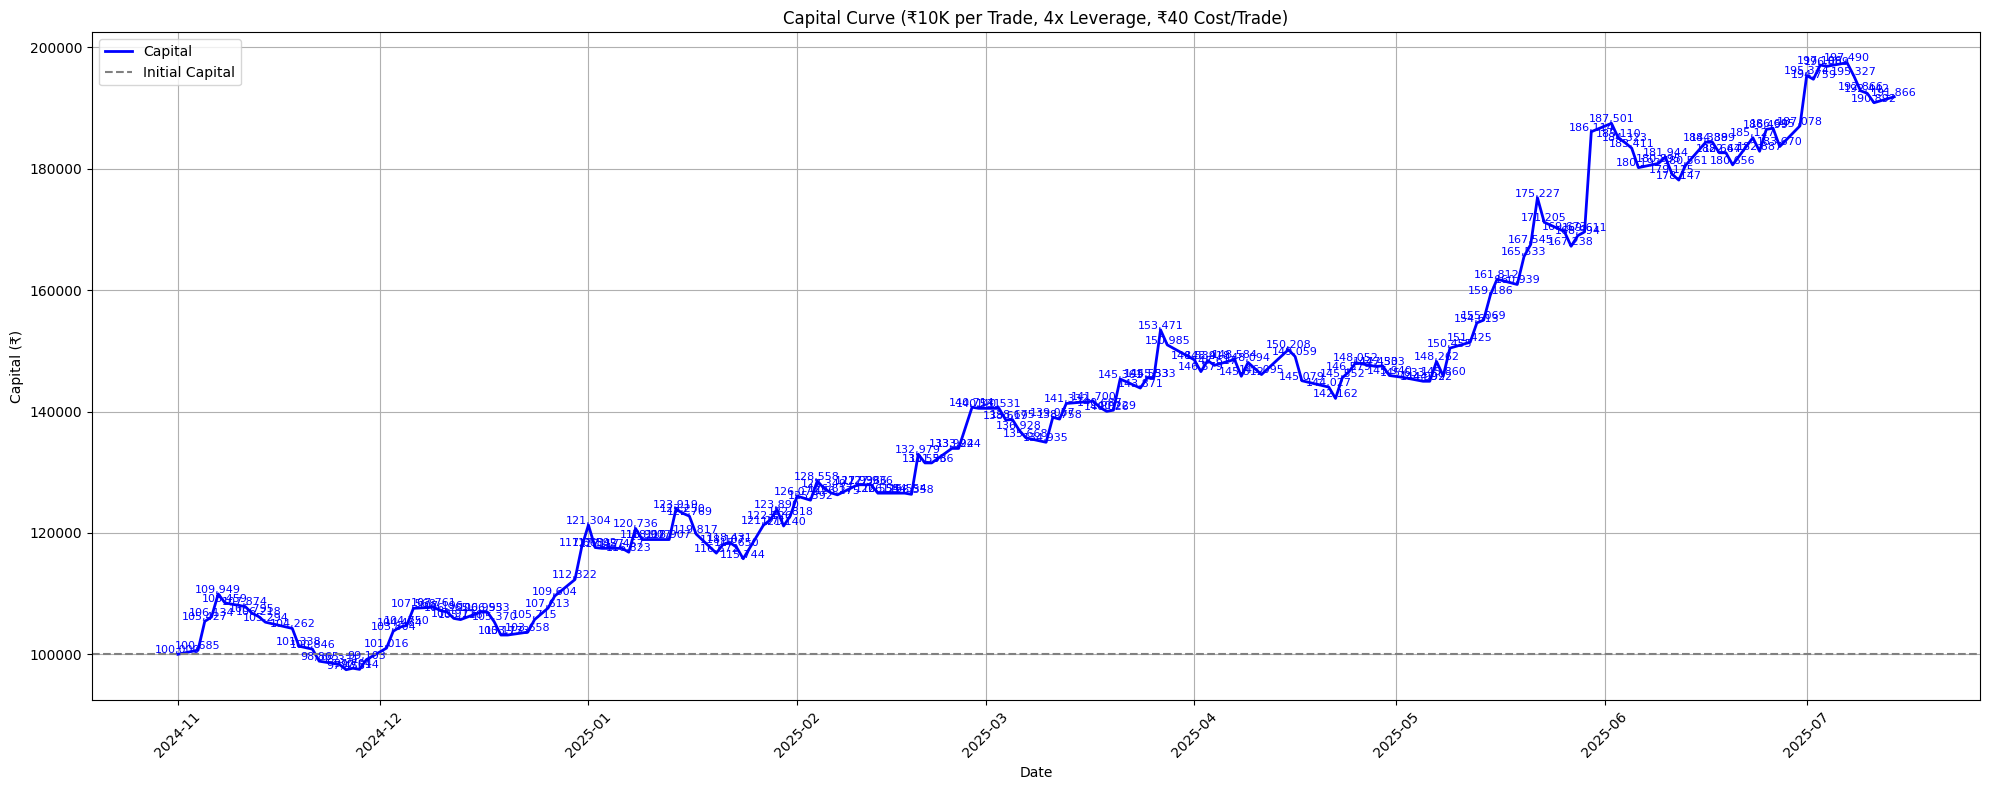

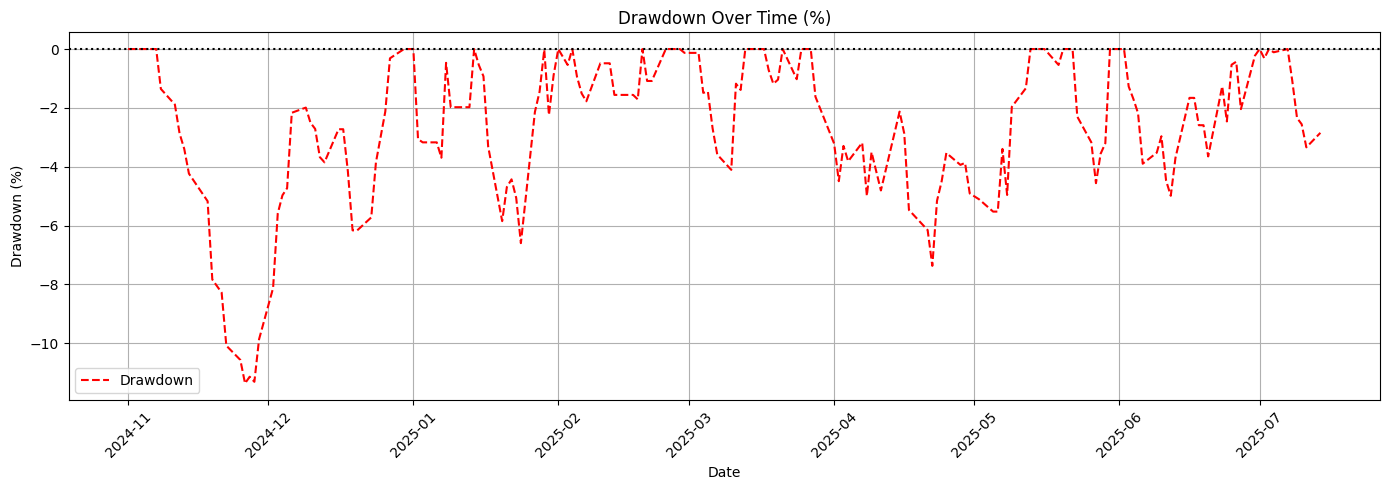


📊 Monthly Performance Summary:
🗓️ 2024-11 — Trades: 80, Return: -0.62%, Capital: ₹99103.01
🗓️ 2024-12 — Trades: 113, Return: 17.51%, Capital: ₹117668.36
🗓️ 2025-01 — Trades: 101, Return: 4.78%, Capital: ₹122817.77
🗓️ 2025-02 — Trades: 50, Return: 13.84%, Capital: ₹140530.58
🗓️ 2025-03 — Trades: 93, Return: 7.50%, Capital: ₹150985.25
🗓️ 2025-04 — Trades: 110, Return: -3.19%, Capital: ₹145939.67
🗓️ 2025-05 — Trades: 128, Return: 25.12%, Capital: ₹186114.01
🗓️ 2025-06 — Trades: 131, Return: 0.69%, Capital: ₹187077.58
🗓️ 2025-07 — Trades: 51, Return: 2.65%, Capital: ₹191866.05


In [30]:
# 1% range & 1% entry & 0.75% body

import pandas as pd
import matplotlib.pyplot as plt

# === Strategy Data (from you) ===
strategy1_data = {
    "2024-11-01": 0.00,
    "2024-11-04": 1.53,"2024-11-05": 10.06,"2024-11-06": 2.14,"2024-11-07": 7.43,"2024-11-08": -2.47,
    "2024-11-11": -1.00,"2024-11-12": -1.76,"2024-11-13": -1.00,"2024-11-14": -1.58,"2024-11-18": -1.72,
    "2024-11-19": -5.13,"2024-11-21": -0.65,"2024-11-22": -3.53,"2024-11-25": -1.00,
    "2024-11-26": -0.98,"2024-11-27": 1.15,"2024-11-28": -0.31, "2024-11-29": 3.98,
    "2024-12-02": 4.50,"2024-12-03": 6.56,"2024-12-04": 1.39,"2024-12-05": 0.83,
    "2024-12-06": 5.70,"2024-12-09": 0.60,"2024-12-10": -0.65,
    "2024-12-11": 0.37,"2024-12-12": -1.73,"2024-12-13": -0.21,"2024-12-16": 2.82,"2024-12-17": 0.00,"2024-12-18": -2.48,
    "2024-12-19": -3.53,"2024-12-20": 0.00,"2024-12-23": 1.26,"2024-12-24": 4.37,"2024-12-26": 4.23,
    "2024-12-27": 4.34,"2024-12-30": 5.20,"2024-12-31": 10.48,

    '2025-01-01': 6.98, '2025-01-02': -5.08, '2025-01-03': 0.17, '2025-01-06': 0.00,
    '2025-01-07': -1.00, '2025-01-08': 7.02, '2025-01-09': -2.71, '2025-01-10': 0.00,
    '2025-01-13': 0.00, '2025-01-14': 8.59, '2025-01-15': -1.00, '2025-01-16': 0.02,
    '2025-01-17': -4.25, '2025-01-20': -4.45, '2025-01-21': 2.70, '2025-01-22': 0.63,
    '2025-01-23': -1.00, '2025-01-24': -3.00, '2025-01-27': 9.79, '2025-01-28': 1.81,
    '2025-01-29': 3.21, '2025-01-30': -4.04, '2025-01-31': 3.25, '2025-02-01': 5.46,
    '2025-02-03': -1.00, '2025-02-04': 5.77, '2025-02-05': -1.64, '2025-02-06': -0.67,
    '2025-02-07': -0.30, '2025-02-10': 2.79, '2025-02-11': 0.00, '2025-02-12': 0.00,
    '2025-02-13': -2.00, '2025-02-14': 0.00, '2025-02-17': 0.00, '2025-02-18': -0.07,
    '2025-02-19': 10.64, '2025-02-20': -1.77, '2025-02-21': 0.00, '2025-02-24': 3.87,
    '2025-02-25': 0.00, '2025-02-27': 10.62, '2025-02-28': -0.02,

    '2025-03-03': 0.00, '2025-03-04': -2.32, '2025-03-05': 0.40, '2025-03-06': -2.20,
    '2025-03-07': -1.36, '2025-03-10': -1.00, '2025-03-11': 6.51, '2025-03-12': -0.27,
    '2025-03-13': 4.03, '2025-03-17': 0.60, '2025-03-18': -0.47, '2025-03-19': 0.18,
    '2025-03-20': 0.53, '2025-03-21': 7.88, '2025-03-24': -1.65, '2025-03-25': 2.39,
    '2025-03-26': 0.00, '2025-03-27': 12.19, '2025-03-28': -3.00,

    '2025-04-01': -3.00, '2025-04-02': -2.24, '2025-04-03': 3.63, '2025-04-04': -1.00,
    '2025-04-07': 1.39, '2025-04-08': -3.33, '2025-04-09': 3.45, '2025-04-11': -1.90,
    '2025-04-15': 6.19, '2025-04-16': -1.37, '2025-04-17': -4.14, '2025-04-21': -0.41,
    '2025-04-22': -1.95, '2025-04-23': 5.33, '2025-04-24': 1.65, '2025-04-25': 2.09,
    '2025-04-28': -0.36, '2025-04-29': 0.38, '2025-04-30': -2.00,
    '2025-05-02': -0.18, '2025-05-05': -0.00, '2025-05-06': 0.00, '2025-05-07': 4.83,
    '2025-05-08': -3.00, '2025-05-09': 6.86, '2025-05-12': 2.09, '2025-05-13': 4.37,
    '2025-05-14': 0.91, '2025-05-15': 6.35, '2025-05-16': 4.18, '2025-05-19': -1.00,
    '2025-05-20': 5.95, '2025-05-21': 2.59, '2025-05-22': 9.65, '2025-05-23': -3.95,
    '2025-05-26': -1.07, '2025-05-27': -2.55, '2025-05-28': 2.58, '2025-05-29': 1.21,
    '2025-05-30': 20.66,

    '2025-06-02': 2.13, '2025-06-03': -2.31, '2025-06-04': 0.19, '2025-06-05': -0.11,
    '2025-06-06': -2.79, '2025-06-09': 1.74, '2025-06-10': 2.04, '2025-06-11': -2.63,
    '2025-06-12': -1.00, '2025-06-13': 3.19, '2025-06-16': 4.96, '2025-06-17': 0.00,
    '2025-06-18': -1.65, '2025-06-19': 0.00, '2025-06-20': -1.86, '2025-06-23': 5.91,
    '2025-06-24': -2.10, '2025-06-25': 4.43, '2025-06-26': 0.61, '2025-06-27': -3.00,
    '2025-06-30': 4.11,

    '2025-07-01': 9.35, '2025-07-02': 0.17, '2025-07-03': 2.73, '2025-07-04': -0.06,
    '2025-07-07': 0.93, '2025-07-08': -1.79, '2025-07-09': -1.96, '2025-07-10': -0.28,
    '2025-07-11': -1.05, '2025-07-14': 1.34
}

strategy1_trades = {
    "2024-11-01": 0,
    "2024-11-04": 2,"2024-11-05": 8,"2024-11-06": 10,"2024-11-07": 3,"2024-11-08": 3,"2024-11-11": 1,
    "2024-11-12": 3,"2024-11-13": 1,"2024-11-14": 2,"2024-11-18": 3,
    "2024-11-19": 6,"2024-11-21": 4,"2024-11-22": 5,"2024-11-25": 1,
    "2024-11-26": 10,"2024-11-27": 8,"2024-11-28": 1,"2024-11-29": 9,

    "2024-12-02": 8,"2024-12-03": 13,"2024-12-04": 1,"2024-12-05": 4,"2024-12-06": 4,
    "2024-12-09": 3,"2024-12-10": 5,"2024-12-11": 10,"2024-12-12": 3,
    "2024-12-13": 2,"2024-12-16": 6,"2024-12-17": 0,"2024-12-18": 6,
    "2024-12-19": 8,"2024-12-20": 0,"2024-12-23": 4,"2024-12-24": 5,
    "2024-12-26": 8,"2024-12-27": 8,"2024-12-30": 3,"2024-12-31": 12,
    '2025-01-01': 10, '2025-01-02': 13, '2025-01-03': 5, '2025-01-06': 0,
    '2025-01-07': 1, '2025-01-08': 4, '2025-01-09': 4, '2025-01-10': 0,
    '2025-01-13': 0, '2025-01-14': 2, '2025-01-15': 1, '2025-01-16': 10,
    '2025-01-17': 7, '2025-01-20': 10, '2025-01-21': 3, '2025-01-22': 1,
    '2025-01-23': 4, '2025-01-24': 3, '2025-01-27': 3, '2025-01-28': 5,
    '2025-01-29': 4, '2025-01-30': 5, '2025-01-31': 6, '2025-02-01': 2,
    '2025-02-03': 1, '2025-02-04': 9, '2025-02-05': 3, '2025-02-06': 6,
    '2025-02-07': 3, '2025-02-10': 2, '2025-02-11': 0, '2025-02-12': 0,
    '2025-02-13': 2, '2025-02-14': 0, '2025-02-17': 0, '2025-02-18': 3,
    '2025-02-19': 2, '2025-02-20': 5, '2025-02-21': 0, '2025-02-24': 3,
    '2025-02-25': 0, '2025-02-27': 6, '2025-02-28': 3,'2025-03-03': 0,
    '2025-03-04': 5, '2025-03-05': 4, '2025-03-06': 4,
    '2025-03-07': 6, '2025-03-10': 1, '2025-03-11': 5, '2025-03-12': 2,
    '2025-03-13': 4, '2025-03-17': 1, '2025-03-18': 12, '2025-03-19': 14,
    '2025-03-20': 3, '2025-03-21': 7, '2025-03-24': 5, '2025-03-25': 1,
    '2025-03-26': 0, '2025-03-27': 16, '2025-03-28': 3,

    '2025-04-01': 3, '2025-04-02': 5, '2025-04-03': 14, '2025-04-04': 1,
    '2025-04-07': 1, '2025-04-08': 5, '2025-04-09': 4, '2025-04-11': 10,
    '2025-04-15': 7, '2025-04-16': 2, '2025-04-17': 15, '2025-04-21': 13,
    '2025-04-22': 8, '2025-04-23': 7, '2025-04-24': 3, '2025-04-25': 1,
    '2025-04-28': 6, '2025-04-29': 3, '2025-04-30': 2,'2025-05-02': 3,
    '2025-05-05': 11, '2025-05-06': 0, '2025-05-07': 4,
    '2025-05-08': 3, '2025-05-09': 7, '2025-05-12': 10, '2025-05-13': 2,
    '2025-05-14': 4, '2025-05-15': 13, '2025-05-16': 11, '2025-05-19': 1,
    '2025-05-20': 3, '2025-05-21': 2, '2025-05-22': 6, '2025-05-23': 8,
    '2025-05-26': 9, '2025-05-27': 4, '2025-05-28': 6, '2025-05-29': 6,
    '2025-05-30': 15,

    '2025-06-02': 8, '2025-06-03': 3, '2025-06-04': 13, '2025-06-05': 11,
    '2025-06-06': 9, '2025-06-09': 12, '2025-06-10': 11, '2025-06-11': 6,
    '2025-06-12': 1, '2025-06-13': 6, '2025-06-16': 9, '2025-06-17': 0,
    '2025-06-18': 3, '2025-06-19': 0, '2025-06-20': 4, '2025-06-23': 12,
    '2025-06-24': 4, '2025-06-25': 6, '2025-06-26': 5, '2025-06-27': 3,
    '2025-06-30': 5,

    '2025-07-01': 6, '2025-07-02': 10, '2025-07-03': 4, '2025-07-04': 2,
    '2025-07-07': 4, '2025-07-08': 5, '2025-07-09': 7, '2025-07-10': 2,
    '2025-07-11': 7, '2025-07-14': 4
}


# ==== Strategy Processing Function ====
def process_strategy(data_dict, trades_dict, cost_per_trade=40, initial_capital=100000, leverage=5, trades_per_day=10):
    df = pd.DataFrame({
        'Return (%)': data_dict,
        'Trades': trades_dict
    })
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    df['Adjusted Return (%)'] = df['Return (%)'] * (1 / trades_per_day) * leverage
    df['Cost (₹)'] = df['Trades'] * cost_per_trade
    df['Net Return (%)'] = df['Adjusted Return (%)'] - (df['Cost (₹)'] / initial_capital * 100)

    df['Capital'] = initial_capital
    for i in range(1, len(df)):
        prev_cap = df.iloc[i - 1]['Capital']
        net_ret = df.iloc[i]['Net Return (%)']
        df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)

    df['Peak'] = df['Capital'].cummax()
    df['Drawdown (₹)'] = df['Capital'] - df['Peak']
    df['Drawdown (%)'] = df['Drawdown (₹)'] / df['Peak'] * 100

    return df, df['Drawdown (%)'].min()

# ==== Process ====
df1, max_dd1 = process_strategy(strategy1_data, strategy1_trades)

# ==== Max Drawdown Print ====
print(f"\n📉 Strategy Max Drawdown: {max_dd1:.2f}%")

# ==== Capital Curve Plot ====
plt.figure(figsize=(20, 8))
plt.plot(df1.index, df1['Capital'], label='Capital', linewidth=2, color='blue')
plt.axhline(100000, color='gray', linestyle='--', label='Initial Capital')
for i, date in enumerate(df1.index):
    plt.text(date, df1['Capital'].iloc[i] + 200, f"{df1['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='blue')
plt.title('Capital Curve (₹10K per Trade, 4x Leverage, ₹40 Cost/Trade)')
plt.ylabel('Capital (₹)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Drawdown Plot ====
plt.figure(figsize=(14, 5))
plt.plot(df1.index, df1['Drawdown (%)'], label='Drawdown', linestyle='--', color='red')
plt.axhline(0, color='black', linestyle=':')
plt.title('Drawdown Over Time (%)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ==== Monthly Summary ====
monthly_summary = df1.groupby(df1.index.to_period("M")).agg({
    'Net Return (%)': 'sum',
    'Trades': 'sum',
    'Capital': 'last'
}).rename(columns={
    'Net Return (%)': 'Monthly Return (%)',
    'Trades': 'Monthly Trades',
    'Capital': 'End Capital (₹)'
})

# Convert PeriodIndex to string for clean print
monthly_summary.index = monthly_summary.index.astype(str)

print("\n📊 Monthly Performance Summary:")
for month, row in monthly_summary.iterrows():
    print(f"🗓️ {month} — Trades: {int(row['Monthly Trades'])}, "
          f"Return: {row['Monthly Return (%)']:.2f}%, "
          f"Capital: ₹{row['End Capital (₹)']:.2f}")


/tmp/ipython-input-42-1883903420.py:174: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99962.06' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)



📉 Strategy Max Drawdown: -12.17%


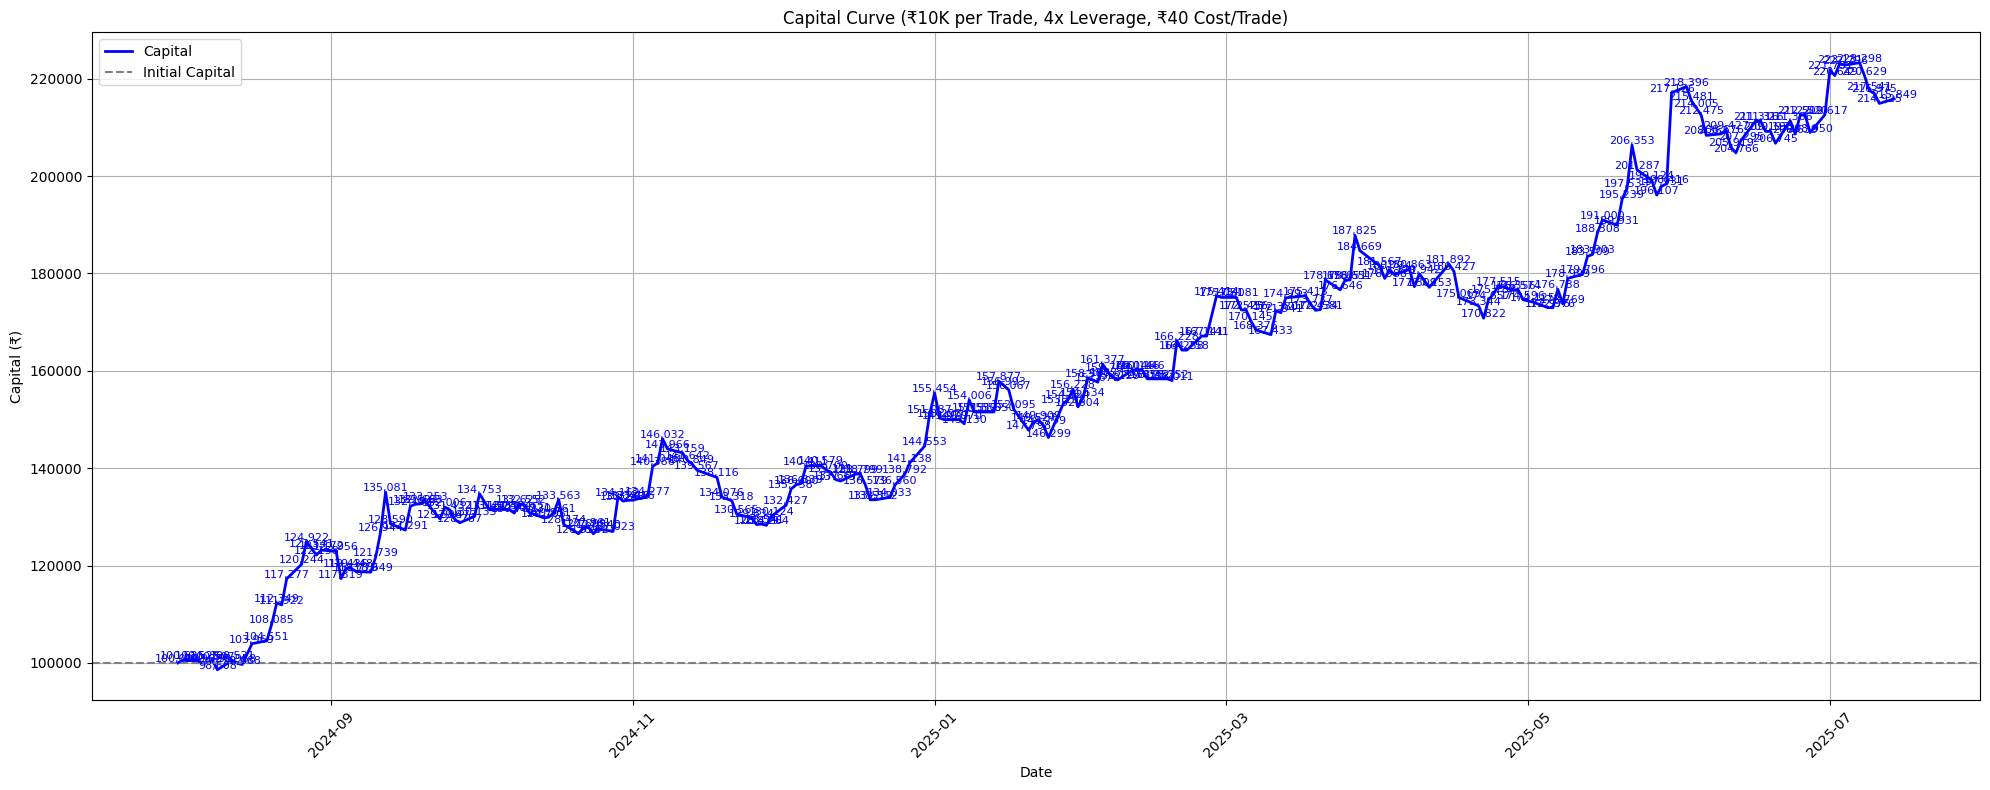

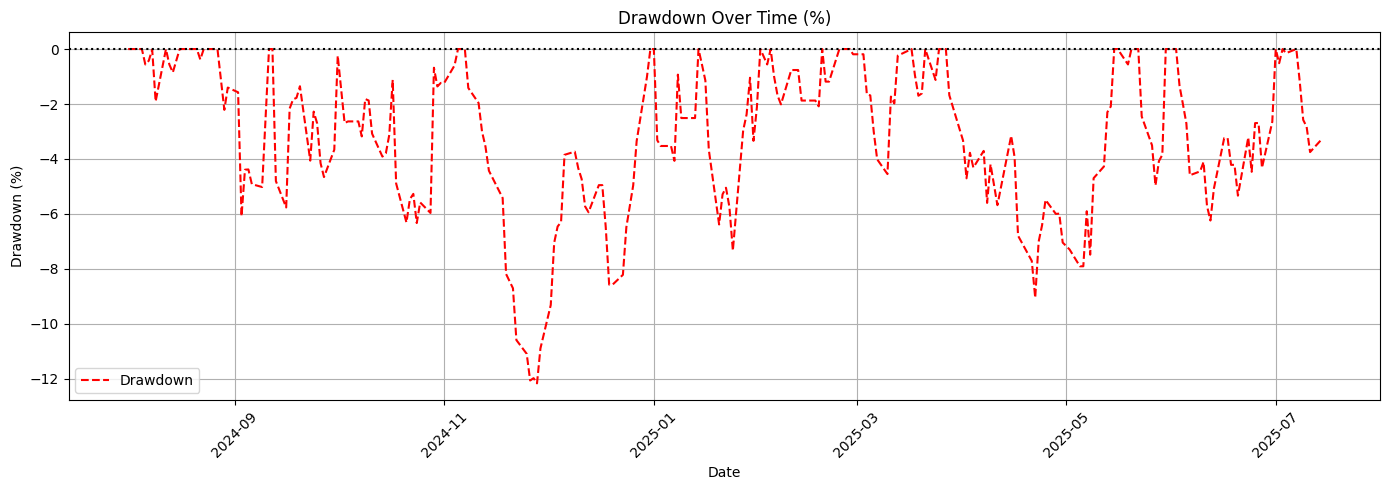


📊 Monthly Performance Summary:
🗓️ 2024-08 — Trades: 99, Return: 20.78%, Capital: ₹123171.68
🗓️ 2024-09 — Trades: 144, Return: 6.22%, Capital: ₹130133.11
🗓️ 2024-10 — Trades: 102, Return: 2.89%, Capital: ₹133416.06
🗓️ 2024-11 — Trades: 80, Return: -2.22%, Capital: ₹130124.20
🗓️ 2024-12 — Trades: 113, Return: 15.25%, Capital: ₹151087.31
🗓️ 2025-01 — Trades: 101, Return: 2.76%, Capital: ₹154534.10
🗓️ 2025-02 — Trades: 50, Return: 12.84%, Capital: ₹175081.15
🗓️ 2025-03 — Trades: 93, Return: 5.64%, Capital: ₹184669.15
🗓️ 2025-04 — Trades: 110, Return: -5.39%, Capital: ₹174596.44
🗓️ 2025-05 — Trades: 128, Return: 22.56%, Capital: ₹217126.09
🗓️ 2025-06 — Trades: 131, Return: -1.93%, Capital: ₹212616.70
🗓️ 2025-07 — Trades: 51, Return: 1.63%, Capital: ₹215848.72


In [42]:
# 1% range & 1% entry & 0.75% body & SLIPPAGE
# ******************************************* VERY IMP IMP
import pandas as pd
import matplotlib.pyplot as plt

# === Strategy Data (from you) ===
strategy1_data = {
    "2024-08-01": -1.00, "2024-08-02": 1.77, "2024-08-05": 0.00, "2024-08-06": -1.00, "2024-08-07": 1.23,
    "2024-08-08": 1.30, "2024-08-09": -3.30, "2024-08-12": 4.48, "2024-08-13": -1.00, "2024-08-14": 0.02,
    "2024-08-16": 10.07, "2024-08-19": 1.48, "2024-08-20": 7.84, "2024-08-21": 8.85, "2024-08-22": -0.40,
    "2024-08-23": 10.05, "2024-08-26": 5.66, "2024-08-27": 8.38, "2024-08-28": -1.85, "2024-08-29": -2.00,"2024-08-30": 2.86,

    "2024-09-02": -0.11, "2024-09-03": -7.97, "2024-09-04": 4.57, "2024-09-05": 0.86, "2024-09-06": -1.00,
    "2024-09-09": 0.50, "2024-09-10": 6.05, "2024-09-11": 9.39, "2024-09-12": 14.14, "2024-09-13": -8.29,
    "2024-09-16": -0.82, "2024-09-17": 9.08, "2024-09-18": 1.40, "2024-09-19": 0.24, "2024-09-20": 2.18,
    "2024-09-23": -4.65, "2024-09-24": 4.32, "2024-09-25": -0.39, "2024-09-26": -2.50, "2024-09-27": 0.14,"2024-09-30": 2.57,

    "2024-10-01": 8.06, "2024-10-03": -4.31, "2024-10-04": 0.36, "2024-10-07": 0.00, "2024-10-08": -0.88,
    "2024-10-09": 3.17, "2024-10-10": 0.61, "2024-10-11": -1.86, "2024-10-14": -0.40, "2024-10-15": 0.96,
    "2024-10-16": 2.36, "2024-10-17": 4.49, "2024-10-18": -6.66, "2024-10-21": -2.39, "2024-10-22": 1.93,
    "2024-10-23": 0.77, "2024-10-24": -2.00, "2024-10-25": 1.84, "2024-10-28": -0.21, "2024-10-29": 12.44,
    "2024-10-30": -0.89, "2024-10-31": 0.62,

    "2024-11-01": 0.00,"2024-11-04": 1.53,"2024-11-05": 10.06,"2024-11-06": 2.14,"2024-11-07": 7.43,"2024-11-08": -2.47,
    "2024-11-11": -1.00,"2024-11-12": -1.76,"2024-11-13": -1.00,"2024-11-14": -1.58,"2024-11-18": -1.72,
    "2024-11-19": -5.13,"2024-11-21": -0.65,"2024-11-22": -3.53,"2024-11-25": -1.00,
    "2024-11-26": -0.98,"2024-11-27": 1.15,"2024-11-28": -0.31, "2024-11-29": 3.98,

    "2024-12-02": 4.50,"2024-12-03": 6.56,"2024-12-04": 1.39,"2024-12-05": 0.83,
    "2024-12-06": 5.70,"2024-12-09": 0.60,"2024-12-10": -0.65,
    "2024-12-11": 0.37,"2024-12-12": -1.73,"2024-12-13": -0.21,"2024-12-16": 2.82,"2024-12-17": 0.00,"2024-12-18": -2.48,
    "2024-12-19": -3.53,"2024-12-20": 0.00,"2024-12-23": 1.26,"2024-12-24": 4.37,"2024-12-26": 4.23,
    "2024-12-27": 4.34,"2024-12-30": 5.20,"2024-12-31": 10.48,

    '2025-01-01': 6.98, '2025-01-02': -5.08, '2025-01-03': 0.17, '2025-01-06': 0.00,
    '2025-01-07': -1.00, '2025-01-08': 7.02, '2025-01-09': -2.71, '2025-01-10': 0.00,
    '2025-01-13': 0.00, '2025-01-14': 8.59, '2025-01-15': -1.00, '2025-01-16': 0.02,
    '2025-01-17': -4.25, '2025-01-20': -4.45, '2025-01-21': 2.70, '2025-01-22': 0.63,
    '2025-01-23': -1.00, '2025-01-24': -3.00, '2025-01-27': 9.79, '2025-01-28': 1.81,
    '2025-01-29': 3.21, '2025-01-30': -4.04, '2025-01-31': 3.25,

    '2025-02-01': 5.46,'2025-02-03': -1.00, '2025-02-04': 5.77, '2025-02-05': -1.64, '2025-02-06': -0.67,
    '2025-02-07': -0.30, '2025-02-10': 2.79, '2025-02-11': 0.00, '2025-02-12': 0.00,
    '2025-02-13': -2.00, '2025-02-14': 0.00, '2025-02-17': 0.00, '2025-02-18': -0.07,
    '2025-02-19': 10.64, '2025-02-20': -1.77, '2025-02-21': 0.00, '2025-02-24': 3.87,
    '2025-02-25': 0.00, '2025-02-27': 10.62, '2025-02-28': -0.02,

    '2025-03-03': 0.00, '2025-03-04': -2.32, '2025-03-05': 0.40, '2025-03-06': -2.20,
    '2025-03-07': -1.36, '2025-03-10': -1.00, '2025-03-11': 6.51, '2025-03-12': -0.27,
    '2025-03-13': 4.03, '2025-03-17': 0.60, '2025-03-18': -0.47, '2025-03-19': 0.18,
    '2025-03-20': 0.53, '2025-03-21': 7.88, '2025-03-24': -1.65, '2025-03-25': 2.39,
    '2025-03-26': 0.00, '2025-03-27': 12.19, '2025-03-28': -3.00,

    '2025-04-01': -3.00, '2025-04-02': -2.24, '2025-04-03': 3.63, '2025-04-04': -1.00,
    '2025-04-07': 1.39, '2025-04-08': -3.33, '2025-04-09': 3.45, '2025-04-11': -1.90,
    '2025-04-15': 6.19, '2025-04-16': -1.37, '2025-04-17': -4.14, '2025-04-21': -0.41,
    '2025-04-22': -1.95, '2025-04-23': 5.33, '2025-04-24': 1.65, '2025-04-25': 2.09,
    '2025-04-28': -0.36, '2025-04-29': 0.38, '2025-04-30': -2.00,

    '2025-05-02': -0.18, '2025-05-05': -0.00, '2025-05-06': 0.00, '2025-05-07': 4.83,
    '2025-05-08': -3.00, '2025-05-09': 6.86, '2025-05-12': 2.09, '2025-05-13': 4.37,
    '2025-05-14': 0.91, '2025-05-15': 6.35, '2025-05-16': 4.18, '2025-05-19': -1.00,
    '2025-05-20': 5.95, '2025-05-21': 2.59, '2025-05-22': 9.65, '2025-05-23': -3.95,
    '2025-05-26': -1.07, '2025-05-27': -2.55, '2025-05-28': 2.58, '2025-05-29': 1.21,
    '2025-05-30': 20.66,

    '2025-06-02': 2.13, '2025-06-03': -2.31, '2025-06-04': 0.19, '2025-06-05': -0.11,
    '2025-06-06': -2.79, '2025-06-09': 1.74, '2025-06-10': 2.04, '2025-06-11': -2.63,
    '2025-06-12': -1.00, '2025-06-13': 3.19, '2025-06-16': 4.96, '2025-06-17': 0.00,
    '2025-06-18': -1.65, '2025-06-19': 0.00, '2025-06-20': -1.86, '2025-06-23': 5.91,
    '2025-06-24': -2.10, '2025-06-25': 4.43, '2025-06-26': 0.61, '2025-06-27': -3.00,
    '2025-06-30': 4.11,

    '2025-07-01': 9.35, '2025-07-02': 0.17, '2025-07-03': 2.73, '2025-07-04': -0.06,
    '2025-07-07': 0.93, '2025-07-08': -1.79, '2025-07-09': -1.96, '2025-07-10': -0.28,
    '2025-07-11': -1.05, '2025-07-14': 1.34
}

strategy1_trades = {
    "2024-08-01": 1, "2024-08-02": 6, "2024-08-05": 0, "2024-08-06": 1, "2024-08-07": 8,
    "2024-08-08": 4, "2024-08-09": 4, "2024-08-12": 5, "2024-08-13": 1, "2024-08-14": 5,
    "2024-08-16": 12, "2024-08-19": 3, "2024-08-20": 9, "2024-08-21": 8, "2024-08-22": 3,
    "2024-08-23": 4, "2024-08-26": 5, "2024-08-27": 5, "2024-08-28": 3, "2024-08-29": 2,"2024-08-30": 10,

    "2024-09-02": 2, "2024-09-03": 10, "2024-09-04": 8, "2024-09-05": 7, "2024-09-06": 1,
    "2024-09-09": 6, "2024-09-10": 7, "2024-09-11": 7, "2024-09-12": 11, "2024-09-13": 11,
    "2024-09-16": 10, "2024-09-17": 12, "2024-09-18": 6, "2024-09-19": 1, "2024-09-20": 11,
    "2024-09-23": 7, "2024-09-24": 5, "2024-09-25": 4, "2024-09-26": 4, "2024-09-27": 10,"2024-09-30": 4,

    "2024-10-01": 8, "2024-10-03": 5, "2024-10-04": 2, "2024-10-07": 0, "2024-10-08": 2,
    "2024-10-09": 3, "2024-10-10": 6, "2024-10-11": 5, "2024-10-14": 11, "2024-10-15": 6,
    "2024-10-16": 8, "2024-10-17": 3, "2024-10-18": 8, "2024-10-21": 5, "2024-10-22": 1,
    "2024-10-23": 3, "2024-10-24": 2, "2024-10-25": 2, "2024-10-28": 5, "2024-10-29": 10,
    "2024-10-30": 4, "2024-10-31": 3,

    "2024-11-01": 0,"2024-11-04": 2,"2024-11-05": 8,"2024-11-06": 10,"2024-11-07": 3,"2024-11-08": 3,"2024-11-11": 1,
    "2024-11-12": 3,"2024-11-13": 1,"2024-11-14": 2,"2024-11-18": 3,
    "2024-11-19": 6,"2024-11-21": 4,"2024-11-22": 5,"2024-11-25": 1,
    "2024-11-26": 10,"2024-11-27": 8,"2024-11-28": 1,"2024-11-29": 9,

    "2024-12-02": 8,"2024-12-03": 13,"2024-12-04": 1,"2024-12-05": 4,"2024-12-06": 4,
    "2024-12-09": 3,"2024-12-10": 5,"2024-12-11": 10,"2024-12-12": 3,
    "2024-12-13": 2,"2024-12-16": 6,"2024-12-17": 0,"2024-12-18": 6,
    "2024-12-19": 8,"2024-12-20": 0,"2024-12-23": 4,"2024-12-24": 5,
    "2024-12-26": 8,"2024-12-27": 8,"2024-12-30": 3,"2024-12-31": 12,

    '2025-01-01': 10, '2025-01-02': 13, '2025-01-03': 5, '2025-01-06': 0,
    '2025-01-07': 1, '2025-01-08': 4, '2025-01-09': 4, '2025-01-10': 0,
    '2025-01-13': 0, '2025-01-14': 2, '2025-01-15': 1, '2025-01-16': 10,
    '2025-01-17': 7, '2025-01-20': 10, '2025-01-21': 3, '2025-01-22': 1,
    '2025-01-23': 4, '2025-01-24': 3, '2025-01-27': 3, '2025-01-28': 5,
    '2025-01-29': 4, '2025-01-30': 5, '2025-01-31': 6,

    '2025-02-01': 2,'2025-02-03': 1, '2025-02-04': 9, '2025-02-05': 3, '2025-02-06': 6,
    '2025-02-07': 3, '2025-02-10': 2, '2025-02-11': 0, '2025-02-12': 0,
    '2025-02-13': 2, '2025-02-14': 0, '2025-02-17': 0, '2025-02-18': 3,
    '2025-02-19': 2, '2025-02-20': 5, '2025-02-21': 0, '2025-02-24': 3,
    '2025-02-25': 0, '2025-02-27': 6, '2025-02-28': 3,

    '2025-03-03': 0, '2025-03-04': 5, '2025-03-05': 4, '2025-03-06': 4,
    '2025-03-07': 6, '2025-03-10': 1, '2025-03-11': 5, '2025-03-12': 2,
    '2025-03-13': 4, '2025-03-17': 1, '2025-03-18': 12, '2025-03-19': 14,
    '2025-03-20': 3, '2025-03-21': 7, '2025-03-24': 5, '2025-03-25': 1,
    '2025-03-26': 0, '2025-03-27': 16, '2025-03-28': 3,

    '2025-04-01': 3, '2025-04-02': 5, '2025-04-03': 14, '2025-04-04': 1,
    '2025-04-07': 1, '2025-04-08': 5, '2025-04-09': 4, '2025-04-11': 10,
    '2025-04-15': 7, '2025-04-16': 2, '2025-04-17': 15, '2025-04-21': 13,
    '2025-04-22': 8, '2025-04-23': 7, '2025-04-24': 3, '2025-04-25': 1,
    '2025-04-28': 6, '2025-04-29': 3, '2025-04-30': 2,

    '2025-05-02': 3, '2025-05-05': 11, '2025-05-06': 0, '2025-05-07': 4,
    '2025-05-08': 3, '2025-05-09': 7, '2025-05-12': 10, '2025-05-13': 2,
    '2025-05-14': 4, '2025-05-15': 13, '2025-05-16': 11, '2025-05-19': 1,
    '2025-05-20': 3, '2025-05-21': 2, '2025-05-22': 6, '2025-05-23': 8,
    '2025-05-26': 9, '2025-05-27': 4, '2025-05-28': 6, '2025-05-29': 6,
    '2025-05-30': 15,

    '2025-06-02': 8, '2025-06-03': 3, '2025-06-04': 13, '2025-06-05': 11,
    '2025-06-06': 9, '2025-06-09': 12, '2025-06-10': 11, '2025-06-11': 6,
    '2025-06-12': 1, '2025-06-13': 6, '2025-06-16': 9, '2025-06-17': 0,
    '2025-06-18': 3, '2025-06-19': 0, '2025-06-20': 4, '2025-06-23': 12,
    '2025-06-24': 4, '2025-06-25': 6, '2025-06-26': 5, '2025-06-27': 3,
    '2025-06-30': 5,

    '2025-07-01': 6, '2025-07-02': 10, '2025-07-03': 4, '2025-07-04': 2,
    '2025-07-07': 4, '2025-07-08': 5, '2025-07-09': 7, '2025-07-10': 2,
    '2025-07-11': 7, '2025-07-14': 4
}

def process_strategy(data_dict, trades_dict, cost_per_trade=40, initial_capital=100000, leverage=5, trades_per_day=10, slippage_pct=0.2):
    df = pd.DataFrame({
        'Return (%)': data_dict,
        'Trades': trades_dict
    })
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    # Adjusted returns with leverage
    df['Adjusted Return (%)'] = df['Return (%)'] * (1 / trades_per_day) * leverage

    # Include cost + slippage
    slippage_total_pct = 1 * slippage_pct / 100  # 0.5% per side = 1% round trip
    df['Cost (₹)'] = df['Trades'] * cost_per_trade + (initial_capital * slippage_total_pct * (df['Trades'] / trades_per_day))

    # Net return after cost
    df['Net Return (%)'] = df['Adjusted Return (%)'] - (df['Cost (₹)'] / initial_capital * 100)

    # Capital calculation
    df['Capital'] = initial_capital
    for i in range(1, len(df)):
        prev_cap = df.iloc[i - 1]['Capital']
        net_ret = df.iloc[i]['Net Return (%)']
        df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)

    # Drawdown
    df['Peak'] = df['Capital'].cummax()
    df['Drawdown (₹)'] = df['Capital'] - df['Peak']
    df['Drawdown (%)'] = df['Drawdown (₹)'] / df['Peak'] * 100

    return df, df['Drawdown (%)'].min()


# ==== Process ====
df1, max_dd1 = process_strategy(strategy1_data, strategy1_trades)

# ==== Max Drawdown Print ====
print(f"\n📉 Strategy Max Drawdown: {max_dd1:.2f}%")

# ==== Capital Curve Plot ====
plt.figure(figsize=(20, 8))
plt.plot(df1.index, df1['Capital'], label='Capital', linewidth=2, color='blue')
plt.axhline(100000, color='gray', linestyle='--', label='Initial Capital')
for i, date in enumerate(df1.index):
    plt.text(date, df1['Capital'].iloc[i] + 200, f"{df1['Capital'].iloc[i]:,.0f}", fontsize=8, ha='center', color='blue')
plt.title('Capital Curve (₹10K per Trade, 4x Leverage, ₹40 Cost/Trade)')
plt.ylabel('Capital (₹)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Drawdown Plot ====
plt.figure(figsize=(14, 5))
plt.plot(df1.index, df1['Drawdown (%)'], label='Drawdown', linestyle='--', color='red')
plt.axhline(0, color='black', linestyle=':')
plt.title('Drawdown Over Time (%)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ==== Monthly Summary ====
monthly_summary = df1.groupby(df1.index.to_period("M")).agg({
    'Net Return (%)': 'sum',
    'Trades': 'sum',
    'Capital': 'last'
}).rename(columns={
    'Net Return (%)': 'Monthly Return (%)',
    'Trades': 'Monthly Trades',
    'Capital': 'End Capital (₹)'
})

# Convert PeriodIndex to string for clean print
monthly_summary.index = monthly_summary.index.astype(str)

print("\n📊 Monthly Performance Summary:")
for month, row in monthly_summary.iterrows():
    print(f"🗓️ {month} — Trades: {int(row['Monthly Trades'])}, "
          f"Return: {row['Monthly Return (%)']:.2f}%, "
          f"Capital: ₹{row['End Capital (₹)']:.2f}")


/tmp/ipython-input-46-2271231378.py:145: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100635.00000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)



📊 Strategy Risk Metrics:
Max Drawdown (%): -11.57
Max Drawdown Duration (days): 34.00
Profit Factor: 1.61
Win Rate (%): 47.14
Expectancy per Trade (%): 0.27
Sharpe Ratio: 2.46
Worst Day Return (%): -3.04
Longest Win Streak: 7.00
Longest Losing Streak: 6.00
Weekday Returns:
   Tuesday: 18.43%
   Monday: 12.06%
   Wednesday: 5.55%
   Thursday: 5.41%
   Friday: 3.42%
   Saturday: 2.60%


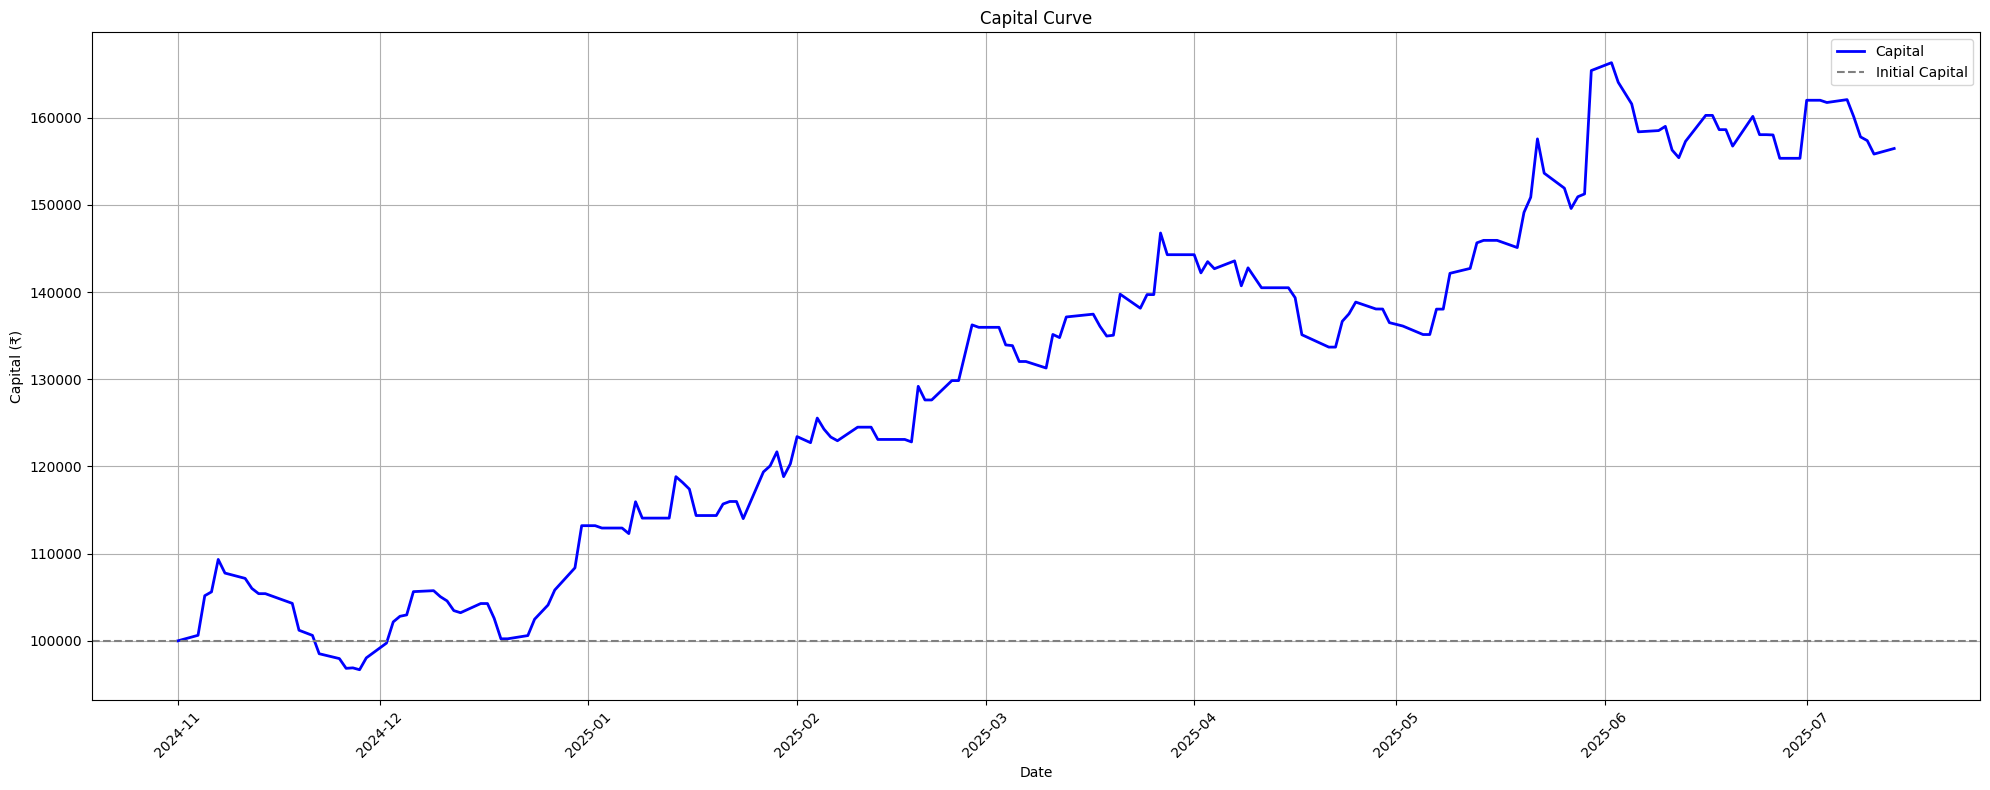

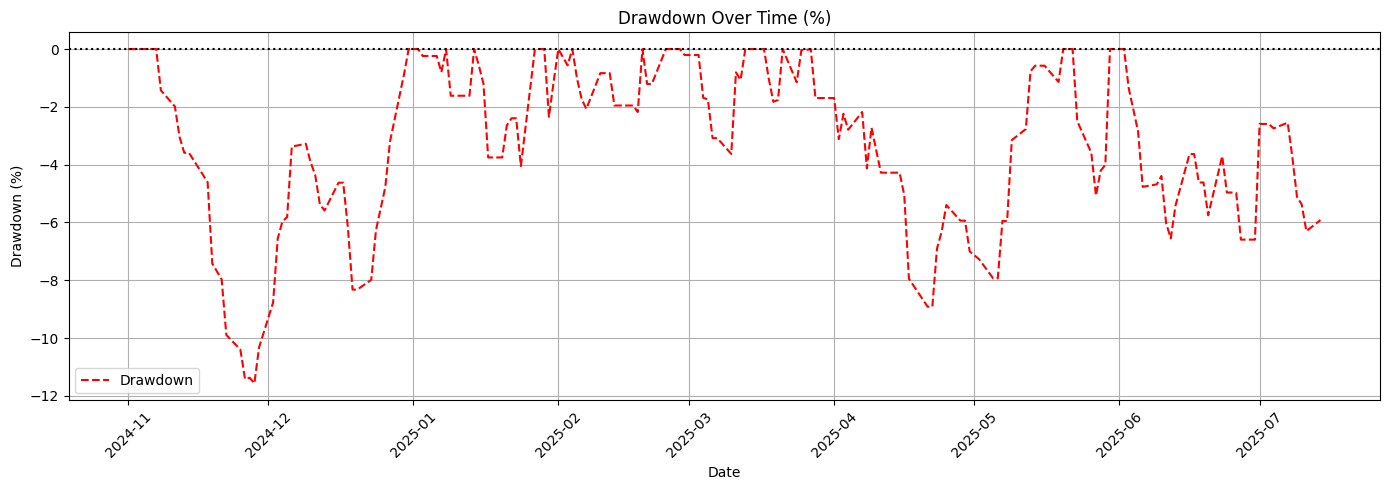

In [46]:
#RISK METRICS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import random

strategy1_data = {"2024-11-01": 0.00,
    "2024-11-04": 1.53,"2024-11-05": 10.06,"2024-11-06": 2.14,"2024-11-07": 7.43,"2024-11-08": -2.47,
    "2024-11-11": -1.00,"2024-11-12": -1.76,"2024-11-13": -1.00,"2024-11-14": -1.58,"2024-11-18": -1.72,
    "2024-11-19": -5.13,"2024-11-21": -0.65,"2024-11-22": -3.53,"2024-11-25": -1.00,
    "2024-11-26": -0.98,"2024-11-27": 1.15,"2024-11-28": -0.31, "2024-11-29": 3.98,
    "2024-12-02": 4.50,"2024-12-03": 6.56,"2024-12-04": 1.39,"2024-12-05": 0.83,
    "2024-12-06": 5.70,"2024-12-09": 0.60,"2024-12-10": -0.65,
    "2024-12-11": 0.37,"2024-12-12": -1.73,"2024-12-13": -0.21,"2024-12-16": 2.82,"2024-12-17": 0.00,"2024-12-18": -2.48,
    "2024-12-19": -3.53,"2024-12-20": 0.00,"2024-12-23": 1.26,"2024-12-24": 4.37,"2024-12-26": 4.23,
    "2024-12-27": 4.34,"2024-12-30": 5.20,"2024-12-31": 10.48,

    '2025-01-01': 6.98, '2025-01-02': -5.08, '2025-01-03': 0.17, '2025-01-06': 0.00,
    '2025-01-07': -1.00, '2025-01-08': 7.02, '2025-01-09': -2.71, '2025-01-10': 0.00,
    '2025-01-13': 0.00, '2025-01-14': 8.59, '2025-01-15': -1.00, '2025-01-16': 0.02,
    '2025-01-17': -4.25, '2025-01-20': -4.45, '2025-01-21': 2.70, '2025-01-22': 0.63,
    '2025-01-23': -1.00, '2025-01-24': -3.00, '2025-01-27': 9.79, '2025-01-28': 1.81,
    '2025-01-29': 3.21, '2025-01-30': -4.04, '2025-01-31': 3.25, '2025-02-01': 5.46,
    '2025-02-03': -1.00, '2025-02-04': 5.77, '2025-02-05': -1.64, '2025-02-06': -0.67,
    '2025-02-07': -0.30, '2025-02-10': 2.79, '2025-02-11': 0.00, '2025-02-12': 0.00,
    '2025-02-13': -2.00, '2025-02-14': 0.00, '2025-02-17': 0.00, '2025-02-18': -0.07,
    '2025-02-19': 10.64, '2025-02-20': -1.77, '2025-02-21': 0.00, '2025-02-24': 3.87,
    '2025-02-25': 0.00, '2025-02-27': 10.62, '2025-02-28': -0.02,

    '2025-03-03': 0.00, '2025-03-04': -2.32, '2025-03-05': 0.40, '2025-03-06': -2.20,
    '2025-03-07': -1.36, '2025-03-10': -1.00, '2025-03-11': 6.51, '2025-03-12': -0.27,
    '2025-03-13': 4.03, '2025-03-17': 0.60, '2025-03-18': -0.47, '2025-03-19': 0.18,
    '2025-03-20': 0.53, '2025-03-21': 7.88, '2025-03-24': -1.65, '2025-03-25': 2.39,
    '2025-03-26': 0.00, '2025-03-27': 12.19, '2025-03-28': -3.00,

    '2025-04-01': -3.00, '2025-04-02': -2.24, '2025-04-03': 3.63, '2025-04-04': -1.00,
    '2025-04-07': 1.39, '2025-04-08': -3.33, '2025-04-09': 3.45, '2025-04-11': -1.90,
    '2025-04-15': 6.19, '2025-04-16': -1.37, '2025-04-17': -4.14, '2025-04-21': -0.41,
    '2025-04-22': -1.95, '2025-04-23': 5.33, '2025-04-24': 1.65, '2025-04-25': 2.09,
    '2025-04-28': -0.36, '2025-04-29': 0.38, '2025-04-30': -2.00,
    '2025-05-02': -0.18, '2025-05-05': -0.00, '2025-05-06': 0.00, '2025-05-07': 4.83,
    '2025-05-08': -3.00, '2025-05-09': 6.86, '2025-05-12': 2.09, '2025-05-13': 4.37,
    '2025-05-14': 0.91, '2025-05-15': 6.35, '2025-05-16': 4.18, '2025-05-19': -1.00,
    '2025-05-20': 5.95, '2025-05-21': 2.59, '2025-05-22': 9.65, '2025-05-23': -3.95,
    '2025-05-26': -1.07, '2025-05-27': -2.55, '2025-05-28': 2.58, '2025-05-29': 1.21,
    '2025-05-30': 20.66,

    '2025-06-02': 2.13, '2025-06-03': -2.31, '2025-06-04': 0.19, '2025-06-05': -0.11,
    '2025-06-06': -2.79, '2025-06-09': 1.74, '2025-06-10': 2.04, '2025-06-11': -2.63,
    '2025-06-12': -1.00, '2025-06-13': 3.19, '2025-06-16': 4.96, '2025-06-17': 0.00,
    '2025-06-18': -1.65, '2025-06-19': 0.00, '2025-06-20': -1.86, '2025-06-23': 5.91,
    '2025-06-24': -2.10, '2025-06-25': 4.43, '2025-06-26': 0.61, '2025-06-27': -3.00,
    '2025-06-30': 4.11,

    '2025-07-01': 9.35, '2025-07-02': 0.17, '2025-07-03': 2.73, '2025-07-04': -0.06,
    '2025-07-07': 0.93, '2025-07-08': -1.79, '2025-07-09': -1.96, '2025-07-10': -0.28,
    '2025-07-11': -1.05, '2025-07-14': 1.34
}

strategy1_trades = {
    "2024-11-01": 0,
    "2024-11-04": 2,"2024-11-05": 8,"2024-11-06": 10,"2024-11-07": 3,"2024-11-08": 3,"2024-11-11": 1,
    "2024-11-12": 3,"2024-11-13": 1,"2024-11-14": 2,"2024-11-18": 3,
    "2024-11-19": 6,"2024-11-21": 4,"2024-11-22": 5,"2024-11-25": 1,
    "2024-11-26": 10,"2024-11-27": 8,"2024-11-28": 1,"2024-11-29": 9,

    "2024-12-02": 8,"2024-12-03": 13,"2024-12-04": 1,"2024-12-05": 4,"2024-12-06": 4,
    "2024-12-09": 3,"2024-12-10": 5,"2024-12-11": 10,"2024-12-12": 3,
    "2024-12-13": 2,"2024-12-16": 6,"2024-12-17": 0,"2024-12-18": 6,
    "2024-12-19": 8,"2024-12-20": 0,"2024-12-23": 4,"2024-12-24": 5,
    "2024-12-26": 8,"2024-12-27": 8,"2024-12-30": 3,"2024-12-31": 12,
    '2025-01-01': 10, '2025-01-02': 13, '2025-01-03': 5, '2025-01-06': 0,
    '2025-01-07': 1, '2025-01-08': 4, '2025-01-09': 4, '2025-01-10': 0,
    '2025-01-13': 0, '2025-01-14': 2, '2025-01-15': 1, '2025-01-16': 10,
    '2025-01-17': 7, '2025-01-20': 10, '2025-01-21': 3, '2025-01-22': 1,
    '2025-01-23': 4, '2025-01-24': 3, '2025-01-27': 3, '2025-01-28': 5,
    '2025-01-29': 4, '2025-01-30': 5, '2025-01-31': 6, '2025-02-01': 2,
    '2025-02-03': 1, '2025-02-04': 9, '2025-02-05': 3, '2025-02-06': 6,
    '2025-02-07': 3, '2025-02-10': 2, '2025-02-11': 0, '2025-02-12': 0,
    '2025-02-13': 2, '2025-02-14': 0, '2025-02-17': 0, '2025-02-18': 3,
    '2025-02-19': 2, '2025-02-20': 5, '2025-02-21': 0, '2025-02-24': 3,
    '2025-02-25': 0, '2025-02-27': 6, '2025-02-28': 3,'2025-03-03': 0,
    '2025-03-04': 5, '2025-03-05': 4, '2025-03-06': 4,
    '2025-03-07': 6, '2025-03-10': 1, '2025-03-11': 5, '2025-03-12': 2,
    '2025-03-13': 4, '2025-03-17': 1, '2025-03-18': 12, '2025-03-19': 14,
    '2025-03-20': 3, '2025-03-21': 7, '2025-03-24': 5, '2025-03-25': 1,
    '2025-03-26': 0, '2025-03-27': 16, '2025-03-28': 3,

    '2025-04-01': 3, '2025-04-02': 5, '2025-04-03': 14, '2025-04-04': 1,
    '2025-04-07': 1, '2025-04-08': 5, '2025-04-09': 4, '2025-04-11': 10,
    '2025-04-15': 7, '2025-04-16': 2, '2025-04-17': 15, '2025-04-21': 13,
    '2025-04-22': 8, '2025-04-23': 7, '2025-04-24': 3, '2025-04-25': 1,
    '2025-04-28': 6, '2025-04-29': 3, '2025-04-30': 2,'2025-05-02': 3,
    '2025-05-05': 11, '2025-05-06': 0, '2025-05-07': 4,
    '2025-05-08': 3, '2025-05-09': 7, '2025-05-12': 10, '2025-05-13': 2,
    '2025-05-14': 4, '2025-05-15': 13, '2025-05-16': 11, '2025-05-19': 1,
    '2025-05-20': 3, '2025-05-21': 2, '2025-05-22': 6, '2025-05-23': 8,
    '2025-05-26': 9, '2025-05-27': 4, '2025-05-28': 6, '2025-05-29': 6,
    '2025-05-30': 15,

    '2025-06-02': 8, '2025-06-03': 3, '2025-06-04': 13, '2025-06-05': 11,
    '2025-06-06': 9, '2025-06-09': 12, '2025-06-10': 11, '2025-06-11': 6,
    '2025-06-12': 1, '2025-06-13': 6, '2025-06-16': 9, '2025-06-17': 0,
    '2025-06-18': 3, '2025-06-19': 0, '2025-06-20': 4, '2025-06-23': 12,
    '2025-06-24': 4, '2025-06-25': 6, '2025-06-26': 5, '2025-06-27': 3,
    '2025-06-30': 5,

    '2025-07-01': 6, '2025-07-02': 10, '2025-07-03': 4, '2025-07-04': 2,
    '2025-07-07': 4, '2025-07-08': 5, '2025-07-09': 7, '2025-07-10': 2,
    '2025-07-11': 7, '2025-07-14': 4}


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

def process_strategy(data_dict, trades_dict, cost_per_trade=40, initial_capital=100000, leverage=5,
                     trades_per_day=10, slippage_pct=0.25, simulate_missed=False, skip_pct=0.1):

    df = pd.DataFrame({
        'Return (%)': data_dict,
        'Trades': trades_dict
    })
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    # === Simulate Missed Trades ===
    if simulate_missed:
        skip_days = random.sample(list(df.index), int(len(df) * skip_pct))
        df.loc[skip_days, 'Return (%)'] = 0
        df.loc[skip_days, 'Trades'] = 0

    # === Net Return Computation ===
    df['Adjusted Return (%)'] = df['Return (%)'] * (1 / trades_per_day) * leverage
    slippage_total_pct = slippage_pct / 100
    df['Cost (₹)'] = df['Trades'] * cost_per_trade + (initial_capital * slippage_total_pct * (df['Trades'] / trades_per_day))
    df['Net Return (%)'] = df['Adjusted Return (%)'] - (df['Cost (₹)'] / initial_capital * 100)

    # === Capital Growth ===
    df['Capital'] = initial_capital
    for i in range(1, len(df)):
        prev_cap = df.iloc[i - 1]['Capital']
        net_ret = df.iloc[i]['Net Return (%)']
        df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)

    # === Drawdown Metrics ===
    df['Peak'] = df['Capital'].cummax()
    df['Drawdown (₹)'] = df['Capital'] - df['Peak']
    df['Drawdown (%)'] = df['Drawdown (₹)'] / df['Peak'] * 100
    max_dd = df['Drawdown (%)'].min()

    # === Max Drawdown Duration ===
    drawdown_duration = (df['Drawdown (₹)'] < 0).astype(int)
    max_dd_duration = 0
    current = 0
    for d in drawdown_duration:
        if d:
            current += 1
            max_dd_duration = max(max_dd_duration, current)
        else:
            current = 0

    # === P&L Statistics ===
    gross_profit = df[df['Net Return (%)'] > 0]['Net Return (%)'].sum()
    gross_loss = df[df['Net Return (%)'] < 0]['Net Return (%)'].abs().sum()
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf

    win_rate = (df['Net Return (%)'] > 0).sum() / (df['Trades'] > 0).sum() * 100
    expectancy = df['Net Return (%)'].mean()

    daily_returns = df['Net Return (%)'].fillna(0)
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(252) if daily_returns.std() > 0 else 0
    worst_day = daily_returns.min()

    # === Win/Loss Streaks ===
    signs = np.sign(df['Net Return (%)'])
    longest_win = longest_lose = cur_win = cur_lose = 0
    for s in signs:
        if s > 0:
            cur_win += 1
            cur_lose = 0
        elif s < 0:
            cur_lose += 1
            cur_win = 0
        else:
            cur_win = cur_lose = 0
        longest_win = max(longest_win, cur_win)
        longest_lose = max(longest_lose, cur_lose)

    # === Day-wise Return Summary ===
    df['Weekday'] = df.index.day_name()
    weekday_perf = df.groupby('Weekday')['Net Return (%)'].sum().sort_values(ascending=False)

    # === Metrics Return ===
    metrics = {
        'Max Drawdown (%)': max_dd,
        'Max Drawdown Duration (days)': max_dd_duration,
        'Profit Factor': profit_factor,
        'Win Rate (%)': win_rate,
        'Expectancy per Trade (%)': expectancy,
        'Sharpe Ratio': sharpe_ratio,
        'Worst Day Return (%)': worst_day,
        'Longest Win Streak': longest_win,
        'Longest Losing Streak': longest_lose,
        'Weekday Returns': weekday_perf.to_dict()
    }

    return df, metrics

# === Apply the Function ===
df1, metrics = process_strategy(
    strategy1_data,
    strategy1_trades,
    slippage_pct=0.25,
    simulate_missed=True,  # True enables random trade skips
    skip_pct=0.10
)

# === Print Risk Metrics ===
print("\n📊 Strategy Risk Metrics:")
for k, v in metrics.items():
    if isinstance(v, dict):
        print(f"{k}:")
        for wk, val in v.items():
            print(f"   {wk}: {val:.2f}%")
    else:
        print(f"{k}: {v:.2f}")

# === Capital Curve Plot ===
plt.figure(figsize=(20, 8))
plt.plot(df1.index, df1['Capital'], label='Capital', linewidth=2, color='blue')
plt.axhline(100000, color='gray', linestyle='--', label='Initial Capital')
plt.title('Capital Curve')
plt.ylabel('Capital (₹)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Drawdown Curve Plot ===
plt.figure(figsize=(14, 5))
plt.plot(df1.index, df1['Drawdown (%)'], label='Drawdown', linestyle='--', color='red')
plt.axhline(0, color='black', linestyle=':')
plt.title('Drawdown Over Time (%)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3-955518111.py:145: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100941.42857142858' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)


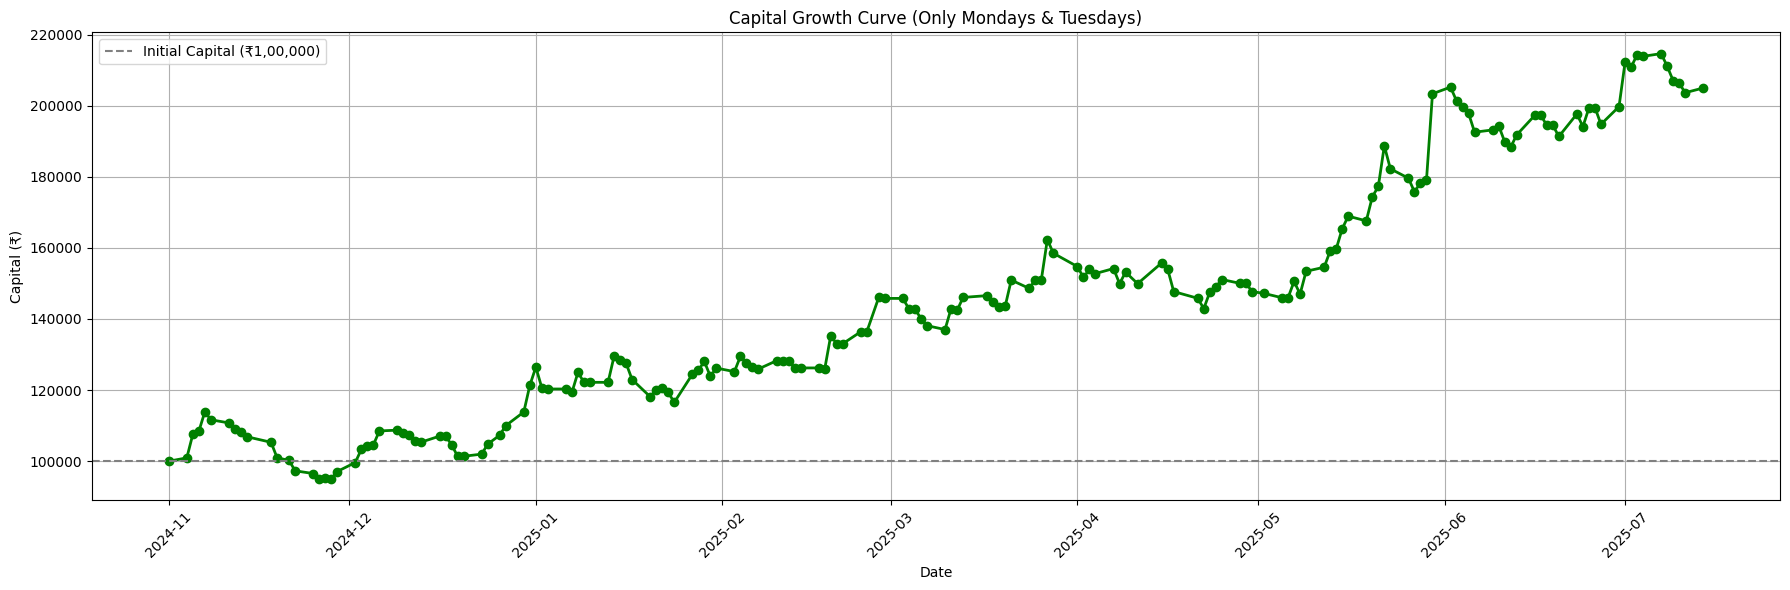


📈 Final Capital (Only Monday & Tuesday Trading): ₹204,964.49


In [3]:
#Day-wise returns

import pandas as pd
import matplotlib.pyplot as plt

strategy1_data = {"2024-11-01": 0.00,
    "2024-11-04": 1.53,"2024-11-05": 10.06,"2024-11-06": 2.14,"2024-11-07": 7.43,"2024-11-08": -2.47,
    "2024-11-11": -1.00,"2024-11-12": -1.76,"2024-11-13": -1.00,"2024-11-14": -1.58,"2024-11-18": -1.72,
    "2024-11-19": -5.13,"2024-11-21": -0.65,"2024-11-22": -3.53,"2024-11-25": -1.00,
    "2024-11-26": -0.98,"2024-11-27": 1.15,"2024-11-28": -0.31, "2024-11-29": 3.98,
    "2024-12-02": 4.50,"2024-12-03": 6.56,"2024-12-04": 1.39,"2024-12-05": 0.83,
    "2024-12-06": 5.70,"2024-12-09": 0.60,"2024-12-10": -0.65,
    "2024-12-11": 0.37,"2024-12-12": -1.73,"2024-12-13": -0.21,"2024-12-16": 2.82,"2024-12-17": 0.00,"2024-12-18": -2.48,
    "2024-12-19": -3.53,"2024-12-20": 0.00,"2024-12-23": 1.26,"2024-12-24": 4.37,"2024-12-26": 4.23,
    "2024-12-27": 4.34,"2024-12-30": 5.20,"2024-12-31": 10.48,

    '2025-01-01': 6.98, '2025-01-02': -5.08, '2025-01-03': 0.17, '2025-01-06': 0.00,
    '2025-01-07': -1.00, '2025-01-08': 7.02, '2025-01-09': -2.71, '2025-01-10': 0.00,
    '2025-01-13': 0.00, '2025-01-14': 8.59, '2025-01-15': -1.00, '2025-01-16': 0.02,
    '2025-01-17': -4.25, '2025-01-20': -4.45, '2025-01-21': 2.70, '2025-01-22': 0.63,
    '2025-01-23': -1.00, '2025-01-24': -3.00, '2025-01-27': 9.79, '2025-01-28': 1.81,
    '2025-01-29': 3.21, '2025-01-30': -4.04, '2025-01-31': 3.25, '2025-02-01': 5.46,
    '2025-02-03': -1.00, '2025-02-04': 5.77, '2025-02-05': -1.64, '2025-02-06': -0.67,
    '2025-02-07': -0.30, '2025-02-10': 2.79, '2025-02-11': 0.00, '2025-02-12': 0.00,
    '2025-02-13': -2.00, '2025-02-14': 0.00, '2025-02-17': 0.00, '2025-02-18': -0.07,
    '2025-02-19': 10.64, '2025-02-20': -1.77, '2025-02-21': 0.00, '2025-02-24': 3.87,
    '2025-02-25': 0.00, '2025-02-27': 10.62, '2025-02-28': -0.02,

    '2025-03-03': 0.00, '2025-03-04': -2.32, '2025-03-05': 0.40, '2025-03-06': -2.20,
    '2025-03-07': -1.36, '2025-03-10': -1.00, '2025-03-11': 6.51, '2025-03-12': -0.27,
    '2025-03-13': 4.03, '2025-03-17': 0.60, '2025-03-18': -0.47, '2025-03-19': 0.18,
    '2025-03-20': 0.53, '2025-03-21': 7.88, '2025-03-24': -1.65, '2025-03-25': 2.39,
    '2025-03-26': 0.00, '2025-03-27': 12.19, '2025-03-28': -3.00,

    '2025-04-01': -3.00, '2025-04-02': -2.24, '2025-04-03': 3.63, '2025-04-04': -1.00,
    '2025-04-07': 1.39, '2025-04-08': -3.33, '2025-04-09': 3.45, '2025-04-11': -1.90,
    '2025-04-15': 6.19, '2025-04-16': -1.37, '2025-04-17': -4.14, '2025-04-21': -0.41,
    '2025-04-22': -1.95, '2025-04-23': 5.33, '2025-04-24': 1.65, '2025-04-25': 2.09,
    '2025-04-28': -0.36, '2025-04-29': 0.38, '2025-04-30': -2.00,
    '2025-05-02': -0.18, '2025-05-05': -0.00, '2025-05-06': 0.00, '2025-05-07': 4.83,
    '2025-05-08': -3.00, '2025-05-09': 6.86, '2025-05-12': 2.09, '2025-05-13': 4.37,
    '2025-05-14': 0.91, '2025-05-15': 6.35, '2025-05-16': 4.18, '2025-05-19': -1.00,
    '2025-05-20': 5.95, '2025-05-21': 2.59, '2025-05-22': 9.65, '2025-05-23': -3.95,
    '2025-05-26': -1.07, '2025-05-27': -2.55, '2025-05-28': 2.58, '2025-05-29': 1.21,
    '2025-05-30': 20.66,

    '2025-06-02': 2.13, '2025-06-03': -2.31, '2025-06-04': 0.19, '2025-06-05': -0.11,
    '2025-06-06': -2.79, '2025-06-09': 1.74, '2025-06-10': 2.04, '2025-06-11': -2.63,
    '2025-06-12': -1.00, '2025-06-13': 3.19, '2025-06-16': 4.96, '2025-06-17': 0.00,
    '2025-06-18': -1.65, '2025-06-19': 0.00, '2025-06-20': -1.86, '2025-06-23': 5.91,
    '2025-06-24': -2.10, '2025-06-25': 4.43, '2025-06-26': 0.61, '2025-06-27': -3.00,
    '2025-06-30': 4.11,

    '2025-07-01': 9.35, '2025-07-02': 0.17, '2025-07-03': 2.73, '2025-07-04': -0.06,
    '2025-07-07': 0.93, '2025-07-08': -1.79, '2025-07-09': -1.96, '2025-07-10': -0.28,
    '2025-07-11': -1.05, '2025-07-14': 1.34
}

strategy1_trades = {
    "2024-11-01": 0,
    "2024-11-04": 2,"2024-11-05": 8,"2024-11-06": 10,"2024-11-07": 3,"2024-11-08": 3,"2024-11-11": 1,
    "2024-11-12": 3,"2024-11-13": 1,"2024-11-14": 2,"2024-11-18": 3,
    "2024-11-19": 6,"2024-11-21": 4,"2024-11-22": 5,"2024-11-25": 1,
    "2024-11-26": 10,"2024-11-27": 8,"2024-11-28": 1,"2024-11-29": 9,

    "2024-12-02": 8,"2024-12-03": 13,"2024-12-04": 1,"2024-12-05": 4,"2024-12-06": 4,
    "2024-12-09": 3,"2024-12-10": 5,"2024-12-11": 10,"2024-12-12": 3,
    "2024-12-13": 2,"2024-12-16": 6,"2024-12-17": 0,"2024-12-18": 6,
    "2024-12-19": 8,"2024-12-20": 0,"2024-12-23": 4,"2024-12-24": 5,
    "2024-12-26": 8,"2024-12-27": 8,"2024-12-30": 3,"2024-12-31": 12,
    '2025-01-01': 10, '2025-01-02': 13, '2025-01-03': 5, '2025-01-06': 0,
    '2025-01-07': 1, '2025-01-08': 4, '2025-01-09': 4, '2025-01-10': 0,
    '2025-01-13': 0, '2025-01-14': 2, '2025-01-15': 1, '2025-01-16': 10,
    '2025-01-17': 7, '2025-01-20': 10, '2025-01-21': 3, '2025-01-22': 1,
    '2025-01-23': 4, '2025-01-24': 3, '2025-01-27': 3, '2025-01-28': 5,
    '2025-01-29': 4, '2025-01-30': 5, '2025-01-31': 6, '2025-02-01': 2,
    '2025-02-03': 1, '2025-02-04': 9, '2025-02-05': 3, '2025-02-06': 6,
    '2025-02-07': 3, '2025-02-10': 2, '2025-02-11': 0, '2025-02-12': 0,
    '2025-02-13': 2, '2025-02-14': 0, '2025-02-17': 0, '2025-02-18': 3,
    '2025-02-19': 2, '2025-02-20': 5, '2025-02-21': 0, '2025-02-24': 3,
    '2025-02-25': 0, '2025-02-27': 6, '2025-02-28': 3,'2025-03-03': 0,
    '2025-03-04': 5, '2025-03-05': 4, '2025-03-06': 4,
    '2025-03-07': 6, '2025-03-10': 1, '2025-03-11': 5, '2025-03-12': 2,
    '2025-03-13': 4, '2025-03-17': 1, '2025-03-18': 12, '2025-03-19': 14,
    '2025-03-20': 3, '2025-03-21': 7, '2025-03-24': 5, '2025-03-25': 1,
    '2025-03-26': 0, '2025-03-27': 16, '2025-03-28': 3,

    '2025-04-01': 3, '2025-04-02': 5, '2025-04-03': 14, '2025-04-04': 1,
    '2025-04-07': 1, '2025-04-08': 5, '2025-04-09': 4, '2025-04-11': 10,
    '2025-04-15': 7, '2025-04-16': 2, '2025-04-17': 15, '2025-04-21': 13,
    '2025-04-22': 8, '2025-04-23': 7, '2025-04-24': 3, '2025-04-25': 1,
    '2025-04-28': 6, '2025-04-29': 3, '2025-04-30': 2,'2025-05-02': 3,
    '2025-05-05': 11, '2025-05-06': 0, '2025-05-07': 4,
    '2025-05-08': 3, '2025-05-09': 7, '2025-05-12': 10, '2025-05-13': 2,
    '2025-05-14': 4, '2025-05-15': 13, '2025-05-16': 11, '2025-05-19': 1,
    '2025-05-20': 3, '2025-05-21': 2, '2025-05-22': 6, '2025-05-23': 8,
    '2025-05-26': 9, '2025-05-27': 4, '2025-05-28': 6, '2025-05-29': 6,
    '2025-05-30': 15,

    '2025-06-02': 8, '2025-06-03': 3, '2025-06-04': 13, '2025-06-05': 11,
    '2025-06-06': 9, '2025-06-09': 12, '2025-06-10': 11, '2025-06-11': 6,
    '2025-06-12': 1, '2025-06-13': 6, '2025-06-16': 9, '2025-06-17': 0,
    '2025-06-18': 3, '2025-06-19': 0, '2025-06-20': 4, '2025-06-23': 12,
    '2025-06-24': 4, '2025-06-25': 6, '2025-06-26': 5, '2025-06-27': 3,
    '2025-06-30': 5,

    '2025-07-01': 6, '2025-07-02': 10, '2025-07-03': 4, '2025-07-04': 2,
    '2025-07-07': 4, '2025-07-08': 5, '2025-07-09': 7, '2025-07-10': 2,
    '2025-07-11': 7, '2025-07-14': 4}

# Step 1: Filter only Monday and Tuesday entries
strategy1_data_filtered = {
    date: ret
    for date, ret in strategy1_data.items()
    if pd.to_datetime(date).weekday() in [0,1,2,3,4]  # Monday=0, Tuesday=1
}

strategy1_trades_filtered = {
    date: trades
    for date, trades in strategy1_trades.items()
    if pd.to_datetime(date).weekday() in [0,1,2,3,4]
}

# Step 2: Process the strategy
def process_monday_tuesday_strategy(data_dict, trades_dict, cost_per_trade=40, initial_capital=100000, leverage=5,
                                    trades_per_day=7, slippage_pct=0.25):
    df = pd.DataFrame({
        'Return (%)': data_dict,
        'Trades': trades_dict
    })
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    df['Adjusted Return (%)'] = df['Return (%)'] * (1 / trades_per_day) * leverage

    slippage_total_pct = slippage_pct / 100
    df['Cost (₹)'] = df['Trades'] * cost_per_trade + (
        initial_capital * slippage_total_pct * (df['Trades'] / trades_per_day)
    )

    df['Net Return (%)'] = df['Adjusted Return (%)'] - (df['Cost (₹)'] / initial_capital * 100)

    df['Capital'] = initial_capital
    for i in range(1, len(df)):
        prev_cap = df.iloc[i - 1]['Capital']
        net_ret = df.iloc[i]['Net Return (%)']
        df.iloc[i, df.columns.get_loc('Capital')] = prev_cap * (1 + net_ret / 100)

    return df

# Process only Monday and Tuesday trades
df_filtered = process_monday_tuesday_strategy(strategy1_data_filtered, strategy1_trades_filtered)

# Step 3: Plot the capital curve
plt.figure(figsize=(18, 6))
plt.plot(df_filtered.index, df_filtered['Capital'], marker='o', linewidth=2, color='green')
plt.axhline(100000, linestyle='--', color='gray', label='Initial Capital (₹1,00,000)')
plt.title("Capital Growth Curve (Only Mondays & Tuesdays)")
plt.xlabel("Date")
plt.ylabel("Capital (₹)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Final capital
final_capital = df_filtered['Capital'].iloc[-1]
print(f"\n📈 Final Capital (Only Monday & Tuesday Trading): ₹{final_capital:,.2f}")
